In [351]:
import pandas as pd
import numpy as np

import os
import warnings

from scipy.io import wavfile

from hmmlearn import hmm      

from python_speech_features import mfcc

from sklearn.externals import joblib

import feature_extraction

import random

import matplotlib.pyplot as plt
mixed_dir = "../../mixed"

In [352]:
# load in mixed_metadata

metadata = pd.read_csv(mixed_dir + "/mixed_metadata.csv")

# create set of labels

labels_set = set(metadata['class'].value_counts().index)

# determine the number of states

n_states = 15

# determine the number of iterations for each HMM

num_iterations = 200

In [353]:
# initialize feature extraction class

fe = feature_extraction.feature_extraction()


(399, 13)


Text(0.5, 1.05, 'MFCC')

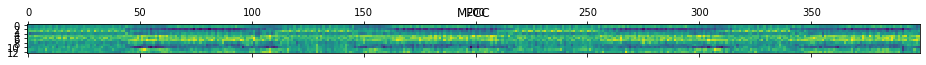

In [354]:
# test data intake

time_signal = fe.read("mixed_1_209864-5-0-0.wav")
mfccs = fe.return_mfcc(time_signal)
print(mfccs.shape)
plt.matshow(mfccs.T)
plt.title('MFCC')

In [355]:
### Define a class to train the HMM ###

# Parameters of `hmm.GaussianHMM()`:
# `n_components`: number of states of HMM
# `covariance_type`: type of covariance matrix for each state. 
# Each state is a random vector. 
# This parameter is a string defining the type of covariance matrix of this vector. Defaults to `"diagonal"`

class HMM_Model(object):
    
    def __init__(self, num_components=12, num_iter=100):
        
        self.n_components = num_components
        self.n_iter = num_iter
        
        # define the covariance type and the type of HMM:
        self.cov_type = 'diag'
        self.model_name = 'GaussianHMM'
        
        # initialize the variable in which we will store the models for each word:
        self.models = []
        
        # define the model using the specified parameters:
        self.model = hmm.GaussianHMM(n_components=self.n_components,
                                     covariance_type=self.cov_type,
                                     n_iter=self.n_iter, verbose=True)

    def train(self, training_data):
        
        """
        Defines a method to train the model
        'training_data' is a 2D numpy array where each row has the 
        length of number of mfcc coefficients
        """
        np.seterr(all='ignore')
        cur_model = self.model.fit(training_data)
        self.models.append(cur_model)

    
    def compute_score(self, input_data):
        
        """
        Define a method to compute log likelihood score for input features
        Returns: Log likelihood of sample input_data
        """
        return self.model.score(input_data)

In [356]:
def build_one_model(features_vector, num_states, num_iterations):
    
    """
    features_vector: nparray of features from Class above
    num_states: number of hidden states in HMM
    """
    
    # initiate HMM model object
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore',category=DeprecationWarning)
        model = HMM_Model(num_components=num_states, num_iter=num_iterations)

    # train HMM model, calculate likelihood of the sample by the trained model
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore',category=DeprecationWarning)
        model.train(features_vector)
        model_score = model.compute_score(features_vector)
        
    return model, model_score

In [357]:
def hmm_aic(LLik, n, k):
    
    """
    Takes in loglikelihood of trained HMM plus number of params
    Returns: Model AIC
    """
    return -2*LLik+2*(n*n+k*n-1)

In [358]:
def build_all_models(labels_set, metadata, num_states, num_iterations):
    
    """
    Given an input data folder with subfolders for each response label
    """
    
    # empty list for storing model results
    model_results = []
    validation_set = []
    
    for i in labels_set:

        # load in filenames relevant to a particular label
        label_file_names = metadata[metadata['class'] == i]['slice_file_name'].tolist()
        # reserve 20 percent for validation
        num_to_train = int(np.ceil(len(label_file_names) * .8))
        train = random.sample(label_file_names, num_to_train)
        print(i,"train length:", len(train))
        validate = list(set(label_file_names) - set(train))
        print(i," validation length:", len(validate))
        # append the list of validation filenames and respective label to validation_set
        validation_set.append((validate, i))
        
        # create an empty array for appending features
        X = np.array([])
    
        print("loading in files for label: ", i)

        for j in range(len(train)):
        
            loaded = fe.read(train[j])
            mfcc_features = fe.return_mfcc(loaded)

            if len(X) == 0:
                
                X = mfcc_features
            
            else:
                
                X = np.append(X, mfcc_features, axis=0)
            
        print("training...")
        model = build_one_model(X, num_states, num_iterations)
        
        # add the model to the results list
        model_results.append((model, i))
        
        # Reset model variable
        model = None

    return model_results, validation_set


In [359]:
model_results, validation_set = build_all_models(labels_set, metadata, n_states, num_iterations)

siren train length: 2230
siren  validation length: 557
loading in files for label:  siren


training...


         1   -41705027.2207             +nan
         2   -39424077.4057    +2280949.8150
         3   -38879940.4952     +544136.9105
         4   -38758904.8161     +121035.6791
         5   -38720361.3353      +38543.4809
         6   -38700834.4947      +19526.8406
         7   -38688651.7335      +12182.7612
         8   -38679822.3438       +8829.3897
         9   -38673925.5275       +5896.8164
        10   -38669715.7727       +4209.7548
        11   -38666060.2226       +3655.5501
        12   -38662284.1652       +3776.0574
        13   -38657870.7479       +4413.4174
        14   -38652314.5018       +5556.2460
        15   -38645213.4647       +7101.0371
        16   -38636477.1618       +8736.3029
        17   -38626491.4029       +9985.7589
        18   -38616403.1208      +10088.2821
        19   -38607648.3760       +8754.7448
        20   -38600884.8904       +6763.4856
        21   -38595749.6280       +5135.2623
        22   -38591579.5940       +4170.0340
        23

       184   -38516079.4753          +0.2979
       185   -38516079.1837          +0.2916
       186   -38516079.0129          +0.1708
       187   -38516078.9455          +0.0674
       188   -38516078.9218          +0.0237
       189   -38516078.9123          +0.0095


jackhammer train length: 2400
jackhammer  validation length: 600
loading in files for label:  jackhammer


training...


         1   -40275772.3222             +nan
         2   -38085689.2805    +2190083.0417
         3   -37623211.0830     +462478.1974
         4   -37513524.4763     +109686.6067
         5   -37470004.0864      +43520.3899
         6   -37437570.6997      +32433.3866
         7   -37405646.6137      +31924.0860
         8   -37383638.4026      +22008.2111
         9   -37369340.1664      +14298.2362
        10   -37359314.9257      +10025.2407
        11   -37353320.8916       +5994.0341
        12   -37349499.2458       +3821.6458
        13   -37347129.5048       +2369.7409
        14   -37345511.2325       +1618.2724
        15   -37344216.5336       +1294.6989
        16   -37342875.3453       +1341.1883
        17   -37341278.6634       +1596.6819
        18   -37339479.7265       +1798.9369
        19   -37337894.6382       +1585.0883
        20   -37336928.1109        +966.5273
        21   -37336406.2934        +521.8175
        22   -37336096.7901        +309.5033
        23

air_conditioner train length: 2400
air_conditioner  validation length: 600
loading in files for label:  air_conditioner


training...


         1   -45599602.1903             +nan
         2   -42605276.9515    +2994325.2388
         3   -42074949.3360     +530327.6155
         4   -41966119.5043     +108829.8317
         5   -41931019.3979      +35100.1065
         6   -41903714.6048      +27304.7931
         7   -41879570.0673      +24144.5375
         8   -41859161.9905      +20408.0768
         9   -41838444.3854      +20717.6050
        10   -41818134.0868      +20310.2986
        11   -41809470.7403       +8663.3466
        12   -41802901.4638       +6569.2765
        13   -41794720.4962       +8180.9676
        14   -41781325.7694      +13394.7268
        15   -41774332.7553       +6993.0140
        16   -41771207.3925       +3125.3628
        17   -41769191.6263       +2015.7662
        18   -41767725.2274       +1466.3988
        19   -41766590.4106       +1134.8168
        20   -41765314.3361       +1276.0745
        21   -41762307.3800       +3006.9561
        22   -41754681.3842       +7625.9957
        23

dog_bark train length: 2400
dog_bark  validation length: 600
loading in files for label:  dog_bark


training...


         1   -37103621.0625             +nan
         2   -34662127.0023    +2441494.0602
         3   -34153807.4960     +508319.5062
         4   -34071096.4550      +82711.0410
         5   -34047483.1873      +23613.2678
         6   -34035342.8251      +12140.3622
         7   -34028131.4974       +7211.3277
         8   -34023621.2933       +4510.2041
         9   -34020378.8189       +3242.4744
        10   -34017688.1290       +2690.6899
        11   -34015143.5253       +2544.6037
        12   -34012334.6316       +2808.8938
        13   -34009533.8609       +2800.7707
        14   -34007079.1171       +2454.7438
        15   -34004753.1715       +2325.9455
        16   -34002589.4810       +2163.6905
        17   -34000665.3709       +1924.1102
        18   -33999261.6729       +1403.6979
        19   -33998019.9155       +1241.7574
        20   -33996624.8297       +1395.0858
        21   -33994706.5606       +1918.2691
        22   -33992517.3843       +2189.1763
        23

engine_idling train length: 2400
engine_idling  validation length: 600
loading in files for label:  engine_idling


training...


         1   -44744182.7185             +nan
         2   -41809076.0059    +2935106.7126
         3   -41272822.9705     +536253.0354
         4   -41158284.9506     +114538.0199
         5   -41125841.1242      +32443.8264
         6   -41111769.1662      +14071.9580
         7   -41103221.3621       +8547.8042
         8   -41097359.9041       +5861.4580
         9   -41092674.2238       +4685.6802
        10   -41088535.7000       +4138.5238
        11   -41085699.8902       +2835.8098
        12   -41083643.8067       +2056.0835
        13   -41081922.6229       +1721.1838
        14   -41080481.4013       +1441.2216
        15   -41079285.9860       +1195.4153
        16   -41078295.6043        +990.3817
        17   -41077469.8442        +825.7601
        18   -41076770.4269        +699.4173
        19   -41076163.5643        +606.8626
        20   -41075621.6759        +541.8884
        21   -41075118.6556        +503.0203
        22   -41074645.7642        +472.8915
        23

children_playing train length: 2400
children_playing  validation length: 600
loading in files for label:  children_playing


training...


         1   -45382965.7894             +nan
         2   -42715158.4964    +2667807.2930
         3   -42139639.3573     +575519.1391
         4   -42025937.4285     +113701.9288
         5   -41986896.9404      +39040.4881
         6   -41966763.5178      +20133.4226
         7   -41952508.9652      +14254.5525
         8   -41940652.3461      +11856.6191
         9   -41930198.7054      +10453.6408
        10   -41920479.7682       +9718.9372
        11   -41911161.2187       +9318.5495
        12   -41902551.0417       +8610.1770
        13   -41895058.7138       +7492.3279
        14   -41888683.5362       +6375.1776
        15   -41883123.1346       +5560.4015
        16   -41877842.6251       +5280.5096
        17   -41872024.7102       +5817.9148
        18   -41865231.2716       +6793.4386
        19   -41858297.8773       +6933.3944
        20   -41852756.7557       +5541.1215
        21   -41848577.1727       +4179.5831
        22   -41844950.9512       +3626.2215
        23

drilling train length: 2400
drilling  validation length: 600
loading in files for label:  drilling


training...


         1   -41539940.0909             +nan
         2   -39354339.3409    +2185600.7500
         3   -38823631.1443     +530708.1966
         4   -38734278.6845      +89352.4599
         5   -38708586.0322      +25692.6522
         6   -38690687.2731      +17898.7592
         7   -38683460.7515       +7226.5216
         8   -38673893.9457       +9566.8058
         9   -38657558.5886      +16335.3572
        10   -38649427.7903       +8130.7983
        11   -38643324.3141       +6103.4762
        12   -38638227.9731       +5096.3410
        13   -38634381.4620       +3846.5110
        14   -38631689.1525       +2692.3095
        15   -38629438.3894       +2250.7631
        16   -38628017.0195       +1421.3699
        17   -38627030.5255        +986.4940
        18   -38626344.3201        +686.2055
        19   -38625864.5602        +479.7599
        20   -38625496.4289        +368.1312
        21   -38625224.0841        +272.3448
        22   -38625040.7135        +183.3706
        23

       184   -38572700.9917          +2.2852
       185   -38572698.8751          +2.1166
       186   -38572696.9135          +1.9616
       187   -38572695.0940          +1.8194
       188   -38572693.4054          +1.6887
       189   -38572691.8365          +1.5688
       190   -38572690.3791          +1.4575
       191   -38572689.0251          +1.3539
       192   -38572687.7680          +1.2571
       193   -38572686.6018          +1.1662
       194   -38572685.5206          +1.0812
       195   -38572684.5197          +1.0009
       196   -38572683.5930          +0.9268
       197   -38572682.7359          +0.8570
       198   -38572681.9428          +0.7932
       199   -38572681.2092          +0.7335
       200   -38572680.5305          +0.6787


gun_shot train length: 898
gun_shot  validation length: 224
loading in files for label:  gun_shot


training...


         1    -7026138.4958             +nan
         2    -6510849.6567     +515288.8391
         3    -6415032.9130      +95816.7438
         4    -6397513.3152      +17519.5977
         5    -6390451.9067       +7061.4085
         6    -6386907.8849       +3544.0218
         7    -6385205.9951       +1701.8898
         8    -6384398.4462        +807.5489
         9    -6383765.2079        +633.2383
        10    -6383110.9856        +654.2223
        11    -6382237.6647        +873.3209
        12    -6380874.2860       +1363.3787
        13    -6378822.9187       +2051.3672
        14    -6376677.0594       +2145.8593
        15    -6375253.6821       +1423.3772
        16    -6374281.6973        +971.9848
        17    -6373609.0058        +672.6915
        18    -6373181.1722        +427.8336
        19    -6372898.3219        +282.8503
        20    -6372680.1425        +218.1794
        21    -6372522.6750        +157.4675
        22    -6372396.3559        +126.3191
        23

car_horn train length: 1030
car_horn  validation length: 257
loading in files for label:  car_horn


training...


         1   -12020554.6144             +nan
         2   -11347418.9765     +673135.6379
         3   -11211512.4189     +135906.5576
         4   -11180241.1665      +31271.2524
         5   -11164102.5582      +16138.6082
         6   -11152515.8517      +11586.7065
         7   -11143574.7381       +8941.1136
         8   -11135850.5443       +7724.1937
         9   -11131853.7510       +3996.7934
        10   -11129926.8960       +1926.8550
        11   -11128700.8860       +1226.0100
        12   -11127860.6217        +840.2643
        13   -11127080.9298        +779.6918
        14   -11126246.0803        +834.8496
        15   -11125445.6654        +800.4149
        16   -11124837.7319        +607.9334
        17   -11124469.8074        +367.9245
        18   -11124123.2092        +346.5982
        19   -11123825.6525        +297.5567
        20   -11123459.6329        +366.0197
        21   -11122987.6487        +471.9842
        22   -11122410.4305        +577.2181
        23

street_music train length: 2400
street_music  validation length: 600
loading in files for label:  street_music


training...


         1   -46045091.5053             +nan
         2   -43578984.3773    +2466107.1280
         3   -43068091.8226     +510892.5548
         4   -42970423.7741      +97668.0484
         5   -42939675.2000      +30748.5741
         6   -42923631.4946      +16043.7054
         7   -42912934.2115      +10697.2831
         8   -42904841.9324       +8092.2791
         9   -42897299.8397       +7542.0927
        10   -42889681.6264       +7618.2133
        11   -42881440.4438       +8241.1826
        12   -42871609.8940       +9830.5499
        13   -42861804.1882       +9805.7058
        14   -42854134.4913       +7669.6968
        15   -42848875.0539       +5259.4375
        16   -42845410.5428       +3464.5111
        17   -42843047.9618       +2362.5809
        18   -42841283.0198       +1764.9420
        19   -42839878.2508       +1404.7690
        20   -42838630.5441       +1247.7067
        21   -42837470.1297       +1160.4144
        22   -42836400.9810       +1069.1487
        23

       184   -42826870.3457          +2.1538
       185   -42826867.9146          +2.4310
       186   -42826865.1283          +2.7864
       187   -42826861.9051          +3.2232
       188   -42826858.1990          +3.7060
       189   -42826854.0158          +4.1832
       190   -42826849.3552          +4.6606
       191   -42826844.1389          +5.2164
       192   -42826838.1532          +5.9856
       193   -42826831.0117          +7.1415
       194   -42826822.1000          +8.9118
       195   -42826810.5152         +11.5848
       196   -42826795.1188         +15.3964
       197   -42826774.2209         +20.8979
       198   -42826744.2761         +29.9448
       199   -42826706.7081         +37.5680
       200   -42826659.0238         +47.6843


In [360]:
model_results

[((<__main__.HMM_Model at 0x1c25f609d0>, -38516078.90741597), 'siren'),
 ((<__main__.HMM_Model at 0x1c25f60450>, -37317569.660494), 'jackhammer'),
 ((<__main__.HMM_Model at 0x1c25f60a50>, -41740087.70802354),
  'air_conditioner'),
 ((<__main__.HMM_Model at 0x1c25f60890>, -33983326.47933271), 'dog_bark'),
 ((<__main__.HMM_Model at 0x1c25f72590>, -41039635.10124011), 'engine_idling'),
 ((<__main__.HMM_Model at 0x1c25f72390>, -41794609.72270538),
  'children_playing'),
 ((<__main__.HMM_Model at 0x1c25f72710>, -38572679.90127143), 'drilling'),
 ((<__main__.HMM_Model at 0x1c25f72750>, -6367004.659538903), 'gun_shot'),
 ((<__main__.HMM_Model at 0x1c25f72850>, -11115531.545813773), 'car_horn'),
 ((<__main__.HMM_Model at 0x1c25f72310>, -42826582.5078975), 'street_music')]

In [361]:
validation_sample = [(validation_set[0][0][i],validation_set[0][1]) for i in range(len(validation_set[0][0]))] + \
[(validation_set[1][0][i],validation_set[1][1]) for i in range(len(validation_set[1][0]))] + \
[(validation_set[2][0][i],validation_set[2][1]) for i in range(len(validation_set[2][0]))] + \
[(validation_set[3][0][i],validation_set[3][1]) for i in range(len(validation_set[3][0]))] + \
[(validation_set[4][0][i],validation_set[4][1]) for i in range(len(validation_set[4][0]))] + \
[(validation_set[5][0][i],validation_set[5][1]) for i in range(len(validation_set[5][0]))] + \
[(validation_set[6][0][i],validation_set[6][1]) for i in range(len(validation_set[6][0]))] + \
[(validation_set[7][0][i],validation_set[7][1]) for i in range(len(validation_set[7][0]))] + \
[(validation_set[8][0][i],validation_set[8][1]) for i in range(len(validation_set[8][0]))] + \
[(validation_set[9][0][i],validation_set[9][1]) for i in range(len(validation_set[9][0]))]

In [362]:
# save to pkl

joblib.dump(model_results,'../../hmm_models/saved_models_{}-states.pkl'.format(n_states))

['../../hmm_models/saved_models_15-states.pkl']

In [363]:
# load from pkl

trained_models = set(joblib.load('../../hmm_models/saved_models_{}-states.pkl'.format(n_states)))

In [364]:
trained_models

{((<__main__.HMM_Model at 0x1c25f60050>, -41794609.72270538),
  'children_playing'),
 ((<__main__.HMM_Model at 0x1c25f72890>, -38516078.90741597), 'siren'),
 ((<__main__.HMM_Model at 0x1c25f72e90>, -38572679.90127143), 'drilling'),
 ((<__main__.HMM_Model at 0x1c25f790d0>, -37317569.660494), 'jackhammer'),
 ((<__main__.HMM_Model at 0x1c25f792d0>, -41740087.70802354),
  'air_conditioner'),
 ((<__main__.HMM_Model at 0x1c25f794d0>, -33983326.47933271), 'dog_bark'),
 ((<__main__.HMM_Model at 0x1c25f796d0>, -41039635.10124011), 'engine_idling'),
 ((<__main__.HMM_Model at 0x1c25f79a90>, -6367004.659538903), 'gun_shot'),
 ((<__main__.HMM_Model at 0x1c25f79c90>, -11115531.545813773), 'car_horn'),
 ((<__main__.HMM_Model at 0x1c2683a450>, -42826582.5078975), 'street_music')}

In [365]:
def score_one_sample(trained_models, test_file_name):
    
    """
    trained_model: ModelHMM object with trained model
    test_file_path: path to wav file
    """
    # empty list to hold all of the scores
    scores = []
    
    # load in file from validation set and convert to mfcc features
    loaded = fe.read(test_file_name)
    mfcc_features = fe.return_mfcc(loaded)
    
    # iterate through each of the trained models
    for i in trained_models:
        
        # compute log likelihood score for using each of the trained models
        sample_score = i[0][0].compute_score(mfcc_features)
        scores.append(sample_score)
        
    predicted = scores.index(max(scores))
    predicted = list(trained_models)[predicted][1]
   
    return predicted

In [366]:
points = 0
validation_list = []

for i in range(len(validation_sample)):
    
    actual = validation_sample[i][1]
    print("actual:", actual)
    predicted = score_one_sample(trained_models, validation_sample[i][0])
    print("predicted:", predicted)
    validation_list.append((actual,predicted))
    if actual == predicted:
        
        points += 1
        print("scored a point!")
        print(points, "points")
    
    


actual: siren
predicted: siren
scored a point!
1 points
actual: siren
predicted: children_playing
actual: siren


predicted: siren
scored a point!
2 points
actual: siren
predicted: siren
scored a point!
3 points
actual: siren
predicted: siren
scored a point!
4 points
actual: siren
predicted: siren
scored a point!
5 points
actual: siren


predicted: dog_bark
actual: siren
predicted: siren
scored a point!
6 points
actual: siren
predicted: dog_bark
actual: siren
predicted: children_playing
actual: siren


predicted: siren
scored a point!
7 points
actual: siren
predicted: dog_bark
actual: siren
predicted: siren
scored a point!
8 points
actual: siren
predicted: siren
scored a point!
9 points
actual: siren


predicted: siren
scored a point!
10 points
actual: siren
predicted: siren
scored a point!
11 points
actual: siren
predicted: siren
scored a point!
12 points
actual: siren


predicted: siren
scored a point!
13 points
actual: siren
predicted: siren
scored a point!
14 points
actual: siren
predicted: siren
scored a point!
15 points
actual: siren


predicted: siren
scored a point!
16 points
actual: siren
predicted: siren
scored a point!
17 points
actual: siren


predicted: siren
scored a point!
18 points
actual: siren
predicted: siren
scored a point!
19 points
actual: siren


predicted: street_music
actual: siren
predicted: car_horn
actual: siren
predicted: siren
scored a point!
20 points
actual: siren
predicted: dog_bark
actual: siren


predicted: siren
scored a point!
21 points
actual: siren
predicted: siren
scored a point!
22 points
actual: siren
predicted: siren
scored a point!
23 points
actual: siren
predicted: siren
scored a point!
24 points
actual: siren


predicted: siren
scored a point!
25 points
actual: siren
predicted: children_playing
actual: siren
predicted: siren
scored a point!
26 points
actual: siren
predicted: children_playing
actual: siren
predicted: siren
scored a point!
27 points
actual: siren


predicted: children_playing
actual: siren
predicted: siren
scored a point!
28 points
actual: siren
predicted: siren
scored a point!
29 points
actual: siren
predicted: siren
scored a point!
30 points
actual: siren
predicted: siren
scored a point!
31 points
actual: siren


predicted: siren
scored a point!
32 points
actual: siren
predicted: siren
scored a point!
33 points
actual: siren
predicted: children_playing
actual: siren
predicted: siren
scored a point!
34 points
actual: siren
predicted: siren
scored a point!
35 points
actual: siren


predicted: siren
scored a point!
36 points
actual: siren
predicted: siren
scored a point!
37 points
actual: siren
predicted: siren
scored a point!
38 points
actual: siren
predicted: siren
scored a point!
39 points
actual: siren


predicted: siren
scored a point!
40 points
actual: siren
predicted: siren
scored a point!
41 points
actual: siren
predicted: dog_bark
actual: siren
predicted: children_playing
actual: siren
predicted: engine_idling
actual: siren


predicted: siren
scored a point!
42 points
actual: siren
predicted: children_playing
actual: siren
predicted: children_playing
actual: siren
predicted: air_conditioner
actual: siren


predicted: siren
scored a point!
43 points
actual: siren
predicted: siren
scored a point!
44 points
actual: siren
predicted: dog_bark
actual: siren
predicted: car_horn
actual: siren


predicted: children_playing
actual: siren
predicted: siren
scored a point!
45 points
actual: siren
predicted: dog_bark
actual: siren
predicted: dog_bark
actual: siren


predicted: children_playing
actual: siren
predicted: siren
scored a point!
46 points
actual: siren
predicted: jackhammer
actual: siren
predicted: children_playing
actual: siren


predicted: siren
scored a point!
47 points
actual: siren
predicted: siren
scored a point!
48 points
actual: siren
predicted: children_playing
actual: siren
predicted: children_playing
actual: siren
predicted: siren
scored a point!
49 points
actual: siren


predicted: siren
scored a point!
50 points
actual: siren
predicted: siren
scored a point!
51 points
actual: siren
predicted: dog_bark
actual: siren
predicted: siren
scored a point!
52 points
actual: siren
predicted: siren
scored a point!
53 points
actual: siren


predicted: siren
scored a point!
54 points
actual: siren
predicted: children_playing
actual: siren
predicted: siren
scored a point!
55 points
actual: siren
predicted: siren
scored a point!
56 points
actual: siren
predicted: children_playing
actual: siren


predicted: gun_shot
actual: siren
predicted: gun_shot
actual: siren
predicted: siren
scored a point!
57 points
actual: siren
predicted: siren
scored a point!
58 points
actual: siren
predicted: children_playing
actual: siren


predicted: jackhammer
actual: siren
predicted: dog_bark
actual: siren
predicted: street_music
actual: siren
predicted: children_playing
actual: siren
predicted: siren
scored a point!
59 points
actual: siren


predicted: siren
scored a point!
60 points
actual: siren
predicted: siren
scored a point!
61 points
actual: siren
predicted: drilling
actual: siren
predicted: siren
scored a point!
62 points
actual: siren
predicted: children_playing
actual: siren


predicted: children_playing
actual: siren
predicted: siren
scored a point!
63 points
actual: siren
predicted: siren
scored a point!
64 points
actual: siren
predicted: siren
scored a point!
65 points
actual: siren
predicted: siren
scored a point!
66 points
actual: siren


predicted: dog_bark
actual: siren
predicted: siren
scored a point!
67 points
actual: siren
predicted: siren
scored a point!
68 points
actual: siren
predicted: street_music
actual: siren
predicted: siren
scored a point!
69 points
actual: siren


predicted: children_playing
actual: siren
predicted: siren
scored a point!
70 points
actual: siren
predicted: children_playing
actual: siren
predicted: engine_idling
actual: siren
predicted: children_playing
actual: siren


predicted: engine_idling
actual: siren
predicted: siren
scored a point!
71 points
actual: siren
predicted: siren
scored a point!
72 points
actual: siren
predicted: siren
scored a point!
73 points
actual: siren


predicted: siren
scored a point!
74 points
actual: siren
predicted: gun_shot
actual: siren
predicted: siren
scored a point!
75 points
actual: siren
predicted: siren
scored a point!
76 points
actual: siren
predicted: children_playing
actual: siren


predicted: children_playing
actual: siren
predicted: siren
scored a point!
77 points
actual: siren
predicted: siren
scored a point!
78 points
actual: siren
predicted: children_playing
actual: siren
predicted: gun_shot
actual: siren


predicted: siren
scored a point!
79 points
actual: siren
predicted: siren
scored a point!
80 points
actual: siren
predicted: siren
scored a point!
81 points
actual: siren
predicted: siren
scored a point!
82 points
actual: siren
predicted: siren
scored a point!
83 points
actual: siren


predicted: siren
scored a point!
84 points
actual: siren
predicted: siren
scored a point!
85 points
actual: siren
predicted: dog_bark
actual: siren
predicted: siren
scored a point!
86 points
actual: siren


predicted: siren
scored a point!
87 points
actual: siren
predicted: siren
scored a point!
88 points
actual: siren
predicted: siren
scored a point!
89 points
actual: siren
predicted: siren
scored a point!
90 points
actual: siren
predicted: siren
scored a point!
91 points
actual: siren


predicted: children_playing
actual: siren
predicted: siren
scored a point!
92 points
actual: siren
predicted: siren
scored a point!
93 points
actual: siren
predicted: siren
scored a point!
94 points
actual: siren
predicted: siren
scored a point!
95 points
actual: siren


predicted: children_playing
actual: siren
predicted: siren
scored a point!
96 points
actual: siren
predicted: siren
scored a point!
97 points
actual: siren
predicted: children_playing
actual: siren


predicted: children_playing
actual: siren
predicted: siren
scored a point!
98 points
actual: siren
predicted: siren
scored a point!
99 points
actual: siren
predicted: gun_shot
actual: siren


predicted: children_playing
actual: siren
predicted: siren
scored a point!
100 points
actual: siren
predicted: siren
scored a point!
101 points
actual: siren
predicted: gun_shot
actual: siren


predicted: siren
scored a point!
102 points
actual: siren
predicted: siren
scored a point!
103 points
actual: siren
predicted: dog_bark
actual: siren
predicted: children_playing
actual: siren


predicted: siren
scored a point!
104 points
actual: siren
predicted: children_playing
actual: siren
predicted: children_playing
actual: siren
predicted: siren
scored a point!
105 points
actual: siren


predicted: siren
scored a point!
106 points
actual: siren
predicted: siren
scored a point!
107 points
actual: siren
predicted: siren
scored a point!
108 points
actual: siren
predicted: car_horn
actual: siren
predicted: siren
scored a point!
109 points
actual: siren


predicted: siren
scored a point!
110 points
actual: siren
predicted: children_playing
actual: siren
predicted: children_playing
actual: siren
predicted: children_playing
actual: siren


predicted: children_playing
actual: siren
predicted: siren
scored a point!
111 points
actual: siren
predicted: siren
scored a point!
112 points
actual: siren
predicted: engine_idling
actual: siren


predicted: children_playing
actual: siren
predicted: children_playing
actual: siren
predicted: siren
scored a point!
113 points
actual: siren
predicted: siren
scored a point!
114 points
actual: siren
predicted: dog_bark
actual: siren


predicted: siren
scored a point!
115 points
actual: siren
predicted: children_playing
actual: siren
predicted: street_music
actual: siren
predicted: siren
scored a point!
116 points
actual: siren
predicted: siren
scored a point!
117 points
actual: siren


predicted: dog_bark
actual: siren
predicted: siren
scored a point!
118 points
actual: siren
predicted: gun_shot
actual: siren
predicted: siren
scored a point!
119 points
actual: siren
predicted: siren
scored a point!
120 points
actual: siren


predicted: siren
scored a point!
121 points
actual: siren
predicted: siren
scored a point!
122 points
actual: siren
predicted: siren
scored a point!
123 points
actual: siren
predicted: siren
scored a point!
124 points
actual: siren


predicted: siren
scored a point!
125 points
actual: siren
predicted: siren
scored a point!
126 points
actual: siren
predicted: siren
scored a point!
127 points
actual: siren
predicted: dog_bark
actual: siren


predicted: siren
scored a point!
128 points
actual: siren
predicted: children_playing
actual: siren
predicted: car_horn
actual: siren
predicted: siren
scored a point!
129 points
actual: siren


predicted: siren
scored a point!
130 points
actual: siren
predicted: siren
scored a point!
131 points
actual: siren
predicted: car_horn
actual: siren
predicted: car_horn
actual: siren
predicted: dog_bark
actual: siren


predicted: siren
scored a point!
132 points
actual: siren
predicted: dog_bark
actual: siren
predicted: engine_idling
actual: siren
predicted: children_playing
actual: siren


predicted: siren
scored a point!
133 points
actual: siren
predicted: siren
scored a point!
134 points
actual: siren
predicted: siren
scored a point!
135 points
actual: siren
predicted: gun_shot
actual: siren


predicted: siren
scored a point!
136 points
actual: siren
predicted: gun_shot
actual: siren
predicted: engine_idling
actual: siren
predicted: siren
scored a point!
137 points
actual: siren


predicted: children_playing
actual: siren
predicted: siren
scored a point!
138 points
actual: siren
predicted: siren
scored a point!
139 points
actual: siren
predicted: siren
scored a point!
140 points
actual: siren
predicted: gun_shot
actual: siren


predicted: siren
scored a point!
141 points
actual: siren
predicted: siren
scored a point!
142 points
actual: siren
predicted: children_playing
actual: siren
predicted: gun_shot
actual: siren
predicted: siren
scored a point!
143 points
actual: siren


predicted: siren
scored a point!
144 points
actual: siren
predicted: siren
scored a point!
145 points
actual: siren
predicted: children_playing
actual: siren
predicted: children_playing
actual: siren
predicted: siren
scored a point!
146 points
actual: siren


predicted: children_playing
actual: siren
predicted: children_playing
actual: siren
predicted: siren
scored a point!
147 points
actual: siren
predicted: siren
scored a point!
148 points
actual: siren
predicted: car_horn
actual: siren


predicted: children_playing
actual: siren
predicted: children_playing
actual: siren
predicted: siren
scored a point!
149 points
actual: siren
predicted: siren
scored a point!
150 points
actual: siren
predicted: siren
scored a point!
151 points
actual: siren


predicted: children_playing
actual: siren
predicted: siren
scored a point!
152 points
actual: siren
predicted: siren
scored a point!
153 points
actual: siren
predicted: siren
scored a point!
154 points
actual: siren


predicted: siren
scored a point!
155 points
actual: siren
predicted: children_playing
actual: siren
predicted: siren
scored a point!
156 points
actual: siren
predicted: siren
scored a point!
157 points
actual: siren
predicted: siren
scored a point!
158 points
actual: siren


predicted: siren
scored a point!
159 points
actual: siren
predicted: siren
scored a point!
160 points
actual: siren
predicted: children_playing
actual: siren
predicted: siren
scored a point!
161 points
actual: siren
predicted: siren
scored a point!
162 points
actual: siren


predicted: children_playing
actual: siren
predicted: children_playing
actual: siren
predicted: jackhammer
actual: siren
predicted: children_playing
actual: siren
predicted: siren
scored a point!
163 points
actual: siren


predicted: children_playing
actual: siren
predicted: children_playing
actual: siren
predicted: children_playing
actual: siren
predicted: siren
scored a point!
164 points
actual: siren
predicted: street_music
actual: siren


predicted: siren
scored a point!
165 points
actual: siren
predicted: siren
scored a point!
166 points
actual: siren
predicted: children_playing
actual: siren
predicted: siren
scored a point!
167 points
actual: siren
predicted: children_playing
actual: siren


predicted: siren
scored a point!
168 points
actual: siren
predicted: children_playing
actual: siren
predicted: siren
scored a point!
169 points
actual: siren
predicted: siren
scored a point!
170 points
actual: siren
predicted: children_playing
actual: siren


predicted: siren
scored a point!
171 points
actual: siren
predicted: siren
scored a point!
172 points
actual: siren
predicted: car_horn
actual: siren


predicted: siren
scored a point!
173 points
actual: siren
predicted: siren
scored a point!
174 points
actual: siren
predicted: street_music
actual: siren
predicted: siren
scored a point!
175 points
actual: siren


predicted: siren
scored a point!
176 points
actual: siren
predicted: children_playing
actual: siren
predicted: street_music
actual: siren
predicted: car_horn
actual: siren
predicted: siren
scored a point!
177 points
actual: siren


predicted: children_playing
actual: siren
predicted: siren
scored a point!
178 points
actual: siren
predicted: children_playing
actual: siren
predicted: siren
scored a point!
179 points
actual: siren
predicted: siren
scored a point!
180 points
actual: siren


predicted: siren
scored a point!
181 points
actual: siren
predicted: dog_bark
actual: siren
predicted: children_playing
actual: siren
predicted: dog_bark
actual: siren
predicted: siren
scored a point!
182 points
actual: siren


predicted: street_music
actual: siren
predicted: street_music
actual: siren
predicted: siren
scored a point!
183 points
actual: siren
predicted: siren
scored a point!
184 points
actual: siren
predicted: children_playing
actual: siren


predicted: siren
scored a point!
185 points
actual: siren
predicted: dog_bark
actual: siren
predicted: siren
scored a point!
186 points
actual: siren
predicted: siren
scored a point!
187 points
actual: siren
predicted: children_playing
actual: siren


predicted: siren
scored a point!
188 points
actual: siren
predicted: siren
scored a point!
189 points
actual: siren
predicted: siren
scored a point!
190 points
actual: siren
predicted: children_playing
actual: siren
predicted: siren
scored a point!
191 points
actual: siren


predicted: children_playing
actual: siren
predicted: children_playing
actual: siren
predicted: siren
scored a point!
192 points
actual: siren
predicted: siren
scored a point!
193 points
actual: siren


predicted: gun_shot
actual: siren
predicted: siren
scored a point!
194 points
actual: siren
predicted: siren
scored a point!
195 points
actual: siren
predicted: children_playing
actual: siren
predicted: siren
scored a point!
196 points
actual: siren


predicted: siren
scored a point!
197 points
actual: siren
predicted: street_music
actual: siren
predicted: siren
scored a point!
198 points
actual: siren
predicted: siren
scored a point!
199 points
actual: siren
predicted: siren
scored a point!
200 points
actual: siren


predicted: street_music
actual: siren
predicted: jackhammer
actual: siren
predicted: siren
scored a point!
201 points
actual: siren
predicted: siren
scored a point!
202 points
actual: siren


predicted: children_playing
actual: siren
predicted: siren
scored a point!
203 points
actual: siren
predicted: siren
scored a point!
204 points
actual: siren
predicted: siren
scored a point!
205 points
actual: siren


predicted: siren
scored a point!
206 points
actual: siren
predicted: siren
scored a point!
207 points
actual: siren
predicted: siren
scored a point!
208 points
actual: siren
predicted: siren
scored a point!
209 points
actual: siren


predicted: gun_shot
actual: siren
predicted: siren
scored a point!
210 points
actual: siren
predicted: siren
scored a point!
211 points
actual: siren
predicted: children_playing
actual: siren


predicted: siren
scored a point!
212 points
actual: siren
predicted: siren
scored a point!
213 points
actual: siren
predicted: siren
scored a point!
214 points
actual: siren
predicted: siren
scored a point!
215 points
actual: siren


predicted: engine_idling
actual: siren
predicted: siren
scored a point!
216 points
actual: siren
predicted: siren
scored a point!
217 points
actual: siren
predicted: siren
scored a point!
218 points
actual: siren


predicted: siren
scored a point!
219 points
actual: siren
predicted: siren
scored a point!
220 points
actual: siren
predicted: children_playing
actual: siren
predicted: children_playing
actual: siren


predicted: children_playing
actual: siren
predicted: siren
scored a point!
221 points
actual: siren
predicted: siren
scored a point!
222 points
actual: siren
predicted: street_music
actual: siren
predicted: siren
scored a point!
223 points
actual: siren


predicted: siren
scored a point!
224 points
actual: siren
predicted: siren
scored a point!
225 points
actual: siren
predicted: siren
scored a point!
226 points
actual: siren
predicted: siren
scored a point!
227 points
actual: siren


predicted: children_playing
actual: siren
predicted: siren
scored a point!
228 points
actual: siren
predicted: siren
scored a point!
229 points
actual: siren
predicted: siren
scored a point!
230 points
actual: siren
predicted: siren
scored a point!
231 points
actual: siren


predicted: siren
scored a point!
232 points
actual: siren
predicted: siren
scored a point!
233 points
actual: siren
predicted: children_playing
actual: siren
predicted: siren
scored a point!
234 points
actual: siren
predicted: siren
scored a point!
235 points
actual: siren


predicted: siren
scored a point!
236 points
actual: siren
predicted: children_playing
actual: siren
predicted: siren
scored a point!
237 points
actual: siren
predicted: siren
scored a point!
238 points
actual: siren
predicted: siren
scored a point!
239 points
actual: siren


predicted: siren
scored a point!
240 points
actual: siren
predicted: street_music
actual: siren
predicted: siren
scored a point!
241 points
actual: siren
predicted: children_playing
actual: siren
predicted: siren
scored a point!
242 points
actual: siren


predicted: siren
scored a point!
243 points
actual: siren
predicted: children_playing
actual: siren
predicted: siren
scored a point!
244 points
actual: siren
predicted: children_playing
actual: siren
predicted: siren
scored a point!
245 points


actual: siren
predicted: children_playing
actual: siren
predicted: children_playing
actual: siren
predicted: siren
scored a point!
246 points
actual: siren


predicted: siren
scored a point!
247 points
actual: siren
predicted: children_playing
actual: siren
predicted: siren
scored a point!
248 points
actual: siren
predicted: siren
scored a point!
249 points
actual: siren
predicted: siren
scored a point!
250 points
actual: siren


predicted: car_horn
actual: siren
predicted: engine_idling
actual: siren
predicted: children_playing
actual: siren
predicted: siren
scored a point!
251 points
actual: siren
predicted: gun_shot
actual: siren


predicted: siren
scored a point!
252 points
actual: siren
predicted: siren
scored a point!
253 points
actual: siren
predicted: siren
scored a point!
254 points
actual: siren
predicted: siren
scored a point!
255 points
actual: siren


predicted: siren
scored a point!
256 points
actual: siren
predicted: siren
scored a point!
257 points
actual: siren
predicted: gun_shot
actual: siren
predicted: siren
scored a point!
258 points
actual: siren


predicted: siren
scored a point!
259 points
actual: siren
predicted: siren
scored a point!
260 points
actual: siren
predicted: siren
scored a point!
261 points
actual: siren
predicted: children_playing
actual: siren
predicted: siren
scored a point!
262 points
actual: siren


predicted: engine_idling
actual: siren
predicted: children_playing
actual: siren
predicted: siren
scored a point!
263 points
actual: siren
predicted: siren
scored a point!
264 points
actual: siren


predicted: children_playing
actual: siren
predicted: children_playing
actual: siren
predicted: siren
scored a point!
265 points
actual: siren
predicted: children_playing
actual: siren
predicted: siren
scored a point!
266 points
actual: siren


predicted: siren
scored a point!
267 points
actual: siren
predicted: siren
scored a point!
268 points
actual: siren
predicted: siren
scored a point!
269 points
actual: siren
predicted: siren
scored a point!
270 points
actual: siren
predicted: children_playing
actual: siren


predicted: siren
scored a point!
271 points
actual: siren
predicted: gun_shot
actual: siren
predicted: siren
scored a point!
272 points
actual: siren
predicted: siren
scored a point!
273 points
actual: siren


predicted: siren
scored a point!
274 points
actual: siren
predicted: street_music
actual: siren
predicted: siren
scored a point!
275 points
actual: siren
predicted: children_playing
actual: siren


predicted: siren
scored a point!
276 points
actual: siren
predicted: siren
scored a point!
277 points
actual: siren
predicted: siren
scored a point!
278 points
actual: siren
predicted: siren
scored a point!
279 points
actual: siren


predicted: dog_bark
actual: siren
predicted: engine_idling
actual: siren
predicted: siren
scored a point!
280 points
actual: siren
predicted: siren
scored a point!
281 points
actual: siren
predicted: children_playing
actual: siren


predicted: siren
scored a point!
282 points
actual: siren
predicted: siren
scored a point!
283 points
actual: siren
predicted: gun_shot
actual: siren
predicted: siren
scored a point!
284 points
actual: siren
predicted: children_playing
actual: siren


predicted: gun_shot
actual: siren
predicted: siren
scored a point!
285 points
actual: siren
predicted: siren
scored a point!
286 points
actual: siren
predicted: siren
scored a point!
287 points
actual: siren
predicted: jackhammer
actual: siren


predicted: children_playing
actual: siren
predicted: siren
scored a point!
288 points
actual: siren
predicted: siren
scored a point!
289 points
actual: siren
predicted: dog_bark
actual: siren


predicted: gun_shot
actual: siren
predicted: siren
scored a point!
290 points
actual: siren
predicted: siren
scored a point!
291 points
actual: siren
predicted: siren
scored a point!
292 points
actual: siren


predicted: siren
scored a point!
293 points
actual: siren
predicted: siren
scored a point!
294 points
actual: siren
predicted: siren
scored a point!
295 points
actual: siren
predicted: siren
scored a point!
296 points
actual: siren


predicted: children_playing
actual: siren
predicted: siren
scored a point!
297 points
actual: siren
predicted: children_playing
actual: siren
predicted: siren
scored a point!
298 points
actual: siren
predicted: siren
scored a point!


299 points
actual: siren
predicted: siren
scored a point!
300 points
actual: siren
predicted: children_playing
actual: siren
predicted: siren
scored a point!
301 points
actual: siren


predicted: children_playing
actual: siren
predicted: children_playing
actual: siren
predicted: siren
scored a point!
302 points
actual: siren
predicted: siren
scored a point!
303 points
actual: siren


predicted: siren
scored a point!
304 points
actual: siren
predicted: children_playing
actual: siren
predicted: siren
scored a point!
305 points
actual: siren
predicted: siren
scored a point!
306 points
actual: siren
predicted: jackhammer
actual: siren


predicted: engine_idling
actual: siren
predicted: street_music
actual: siren
predicted: dog_bark
actual: siren
predicted: dog_bark
actual: siren


predicted: siren
scored a point!
307 points
actual: siren
predicted: dog_bark
actual: siren
predicted: siren
scored a point!
308 points
actual: siren
predicted: siren
scored a point!
309 points
actual: siren


predicted: siren
scored a point!
310 points
actual: siren
predicted: siren
scored a point!
311 points
actual: siren
predicted: siren
scored a point!
312 points
actual: siren
predicted: siren
scored a point!
313 points
actual: siren


predicted: siren
scored a point!
314 points
actual: siren
predicted: siren
scored a point!
315 points
actual: siren
predicted: gun_shot
actual: siren
predicted: gun_shot
actual: siren


predicted: siren
scored a point!
316 points
actual: siren
predicted: children_playing
actual: siren
predicted: children_playing
actual: siren
predicted: siren
scored a point!
317 points
actual: siren


predicted: children_playing
actual: siren
predicted: siren
scored a point!
318 points
actual: siren
predicted: siren
scored a point!
319 points
actual: siren
predicted: siren
scored a point!
320 points
actual: siren


predicted: children_playing
actual: siren
predicted: engine_idling
actual: siren
predicted: siren
scored a point!
321 points
actual: siren
predicted: siren
scored a point!
322 points
actual: siren
predicted: children_playing
actual: siren


predicted: children_playing
actual: siren
predicted: siren
scored a point!
323 points
actual: siren
predicted: siren
scored a point!
324 points
actual: siren
predicted: siren
scored a point!
325 points
actual: siren
predicted: siren
scored a point!
326 points
actual: siren


predicted: siren
scored a point!
327 points
actual: siren
predicted: children_playing
actual: siren
predicted: siren
scored a point!
328 points
actual: siren
predicted: siren
scored a point!
329 points
actual: siren


predicted: siren
scored a point!
330 points
actual: siren
predicted: children_playing
actual: siren
predicted: siren
scored a point!
331 points
actual: siren
predicted: siren
scored a point!
332 points
actual: siren
predicted: engine_idling
actual: siren


predicted: children_playing
actual: siren
predicted: siren
scored a point!
333 points
actual: siren
predicted: engine_idling
actual: siren
predicted: children_playing
actual: siren
predicted: children_playing
actual: siren


predicted: siren
scored a point!
334 points
actual: siren
predicted: children_playing
actual: siren
predicted: siren
scored a point!
335 points
actual: siren
predicted: siren
scored a point!
336 points
actual: siren


predicted: siren
scored a point!
337 points
actual: siren
predicted: siren
scored a point!
338 points
actual: siren
predicted: siren
scored a point!
339 points
actual: siren
predicted: siren
scored a point!
340 points
actual: siren
predicted: siren
scored a point!
341 points
actual: siren


predicted: siren
scored a point!
342 points
actual: siren
predicted: air_conditioner
actual: siren
predicted: siren
scored a point!
343 points
actual: siren
predicted: children_playing
actual: siren


predicted: gun_shot
actual: jackhammer
predicted: jackhammer
scored a point!
344 points
actual: jackhammer
predicted: jackhammer
scored a point!
345 points
actual: jackhammer
predicted: drilling
actual: jackhammer
predicted: jackhammer
scored a point!
346 points
actual: jackhammer


predicted: engine_idling
actual: jackhammer
predicted: jackhammer
scored a point!
347 points
actual: jackhammer
predicted: jackhammer
scored a point!
348 points
actual: jackhammer
predicted: children_playing
actual: jackhammer
predicted: street_music
actual: jackhammer


predicted: jackhammer
scored a point!
349 points
actual: jackhammer
predicted: jackhammer
scored a point!
350 points
actual: jackhammer
predicted: drilling
actual: jackhammer
predicted: jackhammer
scored a point!
351 points
actual: jackhammer


predicted: jackhammer
scored a point!
352 points
actual: jackhammer
predicted: jackhammer
scored a point!
353 points
actual: jackhammer
predicted: jackhammer
scored a point!
354 points
actual: jackhammer
predicted: drilling
actual: jackhammer
predicted: car_horn
actual: jackhammer
predicted: jackhammer
scored a point!
355 points
actual: jackhammer


predicted: jackhammer
scored a point!
356 points
actual: jackhammer
predicted: jackhammer
scored a point!
357 points
actual: jackhammer
predicted: engine_idling
actual: jackhammer
predicted: jackhammer
scored a point!
358 points
actual: jackhammer
predicted: jackhammer
scored a point!
359 points
actual: jackhammer


predicted: dog_bark
actual: jackhammer
predicted: jackhammer
scored a point!
360 points
actual: jackhammer
predicted: engine_idling
actual: jackhammer
predicted: air_conditioner
actual: jackhammer


predicted: jackhammer
scored a point!
361 points
actual: jackhammer
predicted: jackhammer
scored a point!
362 points
actual: jackhammer
predicted: jackhammer
scored a point!
363 points
actual: jackhammer
predicted: jackhammer
scored a point!
364 points
actual: jackhammer
predicted: street_music
actual: jackhammer


predicted: children_playing
actual: jackhammer
predicted: jackhammer
scored a point!
365 points
actual: jackhammer
predicted: jackhammer
scored a point!
366 points
actual: jackhammer
predicted: jackhammer
scored a point!
367 points
actual: jackhammer
predicted: jackhammer
scored a point!
368 points
actual: jackhammer


predicted: jackhammer
scored a point!
369 points
actual: jackhammer
predicted: jackhammer
scored a point!
370 points
actual: jackhammer
predicted: jackhammer
scored a point!
371 points
actual: jackhammer
predicted: jackhammer
scored a point!
372 points
actual: jackhammer


predicted: engine_idling
actual: jackhammer
predicted: jackhammer
scored a point!
373 points
actual: jackhammer
predicted: jackhammer
scored a point!
374 points
actual: jackhammer
predicted: air_conditioner
actual: jackhammer
predicted: jackhammer
scored a point!
375 points
actual: jackhammer


predicted: jackhammer
scored a point!
376 points
actual: jackhammer
predicted: jackhammer
scored a point!
377 points
actual: jackhammer
predicted: jackhammer
scored a point!
378 points
actual: jackhammer
predicted: jackhammer
scored a point!
379 points
actual: jackhammer


predicted: jackhammer
scored a point!
380 points
actual: jackhammer
predicted: jackhammer
scored a point!
381 points
actual: jackhammer
predicted: street_music
actual: jackhammer
predicted: jackhammer
scored a point!
382 points
actual: jackhammer
predicted: drilling
actual: jackhammer


predicted: jackhammer
scored a point!
383 points
actual: jackhammer
predicted: jackhammer
scored a point!
384 points
actual: jackhammer
predicted: jackhammer
scored a point!
385 points
actual: jackhammer
predicted: street_music
actual: jackhammer
predicted: jackhammer
scored a point!
386 points
actual: jackhammer


predicted: jackhammer
scored a point!
387 points
actual: jackhammer
predicted: jackhammer
scored a point!
388 points
actual: jackhammer
predicted: jackhammer
scored a point!
389 points
actual: jackhammer
predicted: jackhammer
scored a point!
390 points
actual: jackhammer
predicted: jackhammer
scored a point!
391 points
actual: jackhammer


predicted: jackhammer
scored a point!
392 points
actual: jackhammer
predicted: jackhammer
scored a point!
393 points
actual: jackhammer
predicted: jackhammer
scored a point!
394 points
actual: jackhammer
predicted: jackhammer
scored a point!
395 points
actual: jackhammer
predicted: jackhammer
scored a point!
396 points
actual: jackhammer


predicted: jackhammer
scored a point!
397 points
actual: jackhammer
predicted: jackhammer
scored a point!
398 points
actual: jackhammer
predicted: jackhammer
scored a point!
399 points
actual: jackhammer
predicted: engine_idling
actual: jackhammer


predicted: jackhammer
scored a point!
400 points
actual: jackhammer
predicted: jackhammer
scored a point!
401 points
actual: jackhammer
predicted: gun_shot
actual: jackhammer
predicted: jackhammer
scored a point!
402 points
actual: jackhammer
predicted: drilling
actual: jackhammer
predicted: jackhammer
scored a point!
403 points
actual: jackhammer


predicted: engine_idling
actual: jackhammer
predicted: jackhammer
scored a point!
404 points
actual: jackhammer
predicted: jackhammer
scored a point!
405 points
actual: jackhammer
predicted: jackhammer
scored a point!
406 points
actual: jackhammer


predicted: jackhammer
scored a point!
407 points
actual: jackhammer
predicted: drilling
actual: jackhammer
predicted: jackhammer
scored a point!
408 points
actual: jackhammer
predicted: drilling
actual: jackhammer
predicted: jackhammer
scored a point!
409 points
actual: jackhammer


predicted: jackhammer
scored a point!
410 points
actual: jackhammer
predicted: car_horn
actual: jackhammer
predicted: jackhammer
scored a point!
411 points
actual: jackhammer
predicted: drilling
actual: jackhammer
predicted: jackhammer
scored a point!
412 points
actual: jackhammer


predicted: jackhammer
scored a point!
413 points
actual: jackhammer
predicted: jackhammer
scored a point!
414 points
actual: jackhammer
predicted: drilling
actual: jackhammer
predicted: jackhammer
scored a point!
415 points
actual: jackhammer
predicted: children_playing
actual: jackhammer


predicted: jackhammer
scored a point!
416 points
actual: jackhammer
predicted: jackhammer
scored a point!
417 points
actual: jackhammer
predicted: jackhammer
scored a point!
418 points
actual: jackhammer
predicted: jackhammer
scored a point!
419 points
actual: jackhammer
predicted: jackhammer
scored a point!
420 points
actual: jackhammer


predicted: jackhammer
scored a point!
421 points
actual: jackhammer
predicted: jackhammer
scored a point!
422 points
actual: jackhammer
predicted: air_conditioner
actual: jackhammer
predicted: jackhammer
scored a point!
423 points
actual: jackhammer


predicted: jackhammer
scored a point!
424 points
actual: jackhammer
predicted: jackhammer
scored a point!
425 points
actual: jackhammer
predicted: jackhammer
scored a point!
426 points
actual: jackhammer
predicted: children_playing
actual: jackhammer
predicted: engine_idling
actual: jackhammer


predicted: jackhammer
scored a point!
427 points
actual: jackhammer
predicted: drilling
actual: jackhammer
predicted: jackhammer
scored a point!
428 points
actual: jackhammer
predicted: children_playing
actual: jackhammer
predicted: engine_idling
actual: jackhammer


predicted: jackhammer
scored a point!
429 points
actual: jackhammer
predicted: jackhammer
scored a point!
430 points
actual: jackhammer
predicted: jackhammer
scored a point!
431 points
actual: jackhammer
predicted: jackhammer
scored a point!
432 points
actual: jackhammer
predicted: jackhammer
scored a point!
433 points
actual: jackhammer


predicted: jackhammer
scored a point!
434 points
actual: jackhammer
predicted: jackhammer
scored a point!
435 points
actual: jackhammer
predicted: children_playing
actual: jackhammer
predicted: jackhammer
scored a point!
436 points
actual: jackhammer
predicted: jackhammer
scored a point!
437 points
actual: jackhammer


predicted: jackhammer
scored a point!
438 points
actual: jackhammer
predicted: jackhammer
scored a point!
439 points
actual: jackhammer
predicted: engine_idling
actual: jackhammer
predicted: jackhammer
scored a point!
440 points
actual: jackhammer
predicted: jackhammer
scored a point!
441 points
actual: jackhammer


predicted: jackhammer
scored a point!
442 points
actual: jackhammer
predicted: jackhammer
scored a point!
443 points
actual: jackhammer
predicted: jackhammer
scored a point!
444 points
actual: jackhammer
predicted: jackhammer
scored a point!
445 points
actual: jackhammer
predicted: jackhammer
scored a point!
446 points
actual: jackhammer


predicted: jackhammer
scored a point!
447 points
actual: jackhammer
predicted: jackhammer
scored a point!
448 points
actual: jackhammer
predicted: drilling
actual: jackhammer
predicted: jackhammer
scored a point!
449 points
actual: jackhammer
predicted: jackhammer
scored a point!
450 points
actual: jackhammer


predicted: jackhammer
scored a point!
451 points
actual: jackhammer
predicted: jackhammer
scored a point!
452 points
actual: jackhammer
predicted: jackhammer
scored a point!
453 points
actual: jackhammer
predicted: children_playing
actual: jackhammer
predicted: jackhammer
scored a point!
454 points
actual: jackhammer


predicted: jackhammer
scored a point!
455 points
actual: jackhammer
predicted: jackhammer
scored a point!
456 points
actual: jackhammer
predicted: jackhammer
scored a point!
457 points
actual: jackhammer
predicted: jackhammer
scored a point!
458 points
actual: jackhammer
predicted: jackhammer
scored a point!
459 points
actual: jackhammer


predicted: jackhammer
scored a point!
460 points
actual: jackhammer
predicted: drilling
actual: jackhammer
predicted: jackhammer
scored a point!
461 points
actual: jackhammer
predicted: air_conditioner
actual: jackhammer
predicted: drilling
actual: jackhammer
predicted: drilling
actual: jackhammer


predicted: street_music
actual: jackhammer
predicted: engine_idling
actual: jackhammer
predicted: car_horn
actual: jackhammer
predicted: jackhammer
scored a point!
462 points
actual: jackhammer


predicted: jackhammer
scored a point!
463 points
actual: jackhammer
predicted: jackhammer
scored a point!
464 points
actual: jackhammer
predicted: drilling
actual: jackhammer
predicted: jackhammer
scored a point!
465 points
actual: jackhammer
predicted: jackhammer
scored a point!
466 points
actual: jackhammer


predicted: jackhammer
scored a point!
467 points
actual: jackhammer
predicted: jackhammer
scored a point!
468 points
actual: jackhammer
predicted: engine_idling
actual: jackhammer
predicted: jackhammer
scored a point!
469 points
actual: jackhammer
predicted: jackhammer
scored a point!
470 points
actual: jackhammer


predicted: jackhammer
scored a point!
471 points
actual: jackhammer
predicted: jackhammer
scored a point!
472 points
actual: jackhammer
predicted: jackhammer
scored a point!
473 points
actual: jackhammer
predicted: drilling
actual: jackhammer


predicted: jackhammer
scored a point!
474 points
actual: jackhammer
predicted: jackhammer
scored a point!
475 points
actual: jackhammer
predicted: jackhammer
scored a point!
476 points
actual: jackhammer
predicted: jackhammer
scored a point!
477 points
actual: jackhammer


predicted: jackhammer
scored a point!
478 points
actual: jackhammer
predicted: jackhammer
scored a point!
479 points
actual: jackhammer
predicted: jackhammer
scored a point!
480 points
actual: jackhammer
predicted: jackhammer
scored a point!
481 points
actual: jackhammer


predicted: jackhammer
scored a point!
482 points
actual: jackhammer
predicted: air_conditioner
actual: jackhammer
predicted: jackhammer
scored a point!
483 points
actual: jackhammer
predicted: jackhammer
scored a point!
484 points
actual: jackhammer


predicted: jackhammer
scored a point!
485 points
actual: jackhammer
predicted: children_playing
actual: jackhammer
predicted: jackhammer
scored a point!
486 points
actual: jackhammer
predicted: jackhammer
scored a point!
487 points
actual: jackhammer
predicted: jackhammer
scored a point!
488 points
actual: jackhammer
predicted: jackhammer
scored a point!
489 points
actual: jackhammer


predicted: jackhammer
scored a point!
490 points
actual: jackhammer
predicted: car_horn
actual: jackhammer
predicted: jackhammer
scored a point!
491 points
actual: jackhammer
predicted: jackhammer
scored a point!
492 points
actual: jackhammer


predicted: jackhammer
scored a point!
493 points
actual: jackhammer
predicted: jackhammer
scored a point!
494 points
actual: jackhammer
predicted: jackhammer
scored a point!
495 points
actual: jackhammer
predicted: jackhammer
scored a point!
496 points
actual: jackhammer


predicted: street_music
actual: jackhammer
predicted: jackhammer
scored a point!
497 points
actual: jackhammer
predicted: jackhammer
scored a point!
498 points
actual: jackhammer
predicted: jackhammer
scored a point!
499 points
actual: jackhammer
predicted: jackhammer
scored a point!
500 points
actual: jackhammer


predicted: jackhammer
scored a point!
501 points
actual: jackhammer
predicted: engine_idling
actual: jackhammer
predicted: engine_idling
actual: jackhammer
predicted: jackhammer
scored a point!
502 points
actual: jackhammer


predicted: children_playing
actual: jackhammer
predicted: engine_idling
actual: jackhammer
predicted: jackhammer
scored a point!
503 points
actual: jackhammer
predicted: jackhammer
scored a point!
504 points
actual: jackhammer
predicted: jackhammer
scored a point!
505 points
actual: jackhammer


predicted: street_music
actual: jackhammer
predicted: jackhammer
scored a point!
506 points
actual: jackhammer
predicted: jackhammer
scored a point!
507 points
actual: jackhammer
predicted: jackhammer
scored a point!
508 points
actual: jackhammer
predicted: jackhammer
scored a point!
509 points
actual: jackhammer


predicted: jackhammer
scored a point!
510 points
actual: jackhammer
predicted: jackhammer
scored a point!
511 points
actual: jackhammer
predicted: jackhammer
scored a point!
512 points
actual: jackhammer
predicted: jackhammer
scored a point!
513 points
actual: jackhammer


predicted: jackhammer
scored a point!
514 points
actual: jackhammer
predicted: jackhammer
scored a point!
515 points
actual: jackhammer
predicted: air_conditioner
actual: jackhammer
predicted: jackhammer
scored a point!
516 points
actual: jackhammer
predicted: jackhammer
scored a point!
517 points
actual: jackhammer


predicted: drilling
actual: jackhammer
predicted: jackhammer
scored a point!
518 points
actual: jackhammer
predicted: jackhammer
scored a point!
519 points
actual: jackhammer
predicted: street_music
actual: jackhammer


predicted: jackhammer
scored a point!
520 points
actual: jackhammer
predicted: air_conditioner
actual: jackhammer
predicted: street_music
actual: jackhammer
predicted: jackhammer
scored a point!
521 points
actual: jackhammer
predicted: children_playing
actual: jackhammer


predicted: jackhammer
scored a point!
522 points
actual: jackhammer
predicted: jackhammer
scored a point!
523 points
actual: jackhammer
predicted: jackhammer
scored a point!
524 points
actual: jackhammer
predicted: jackhammer
scored a point!
525 points
actual: jackhammer


predicted: jackhammer
scored a point!
526 points
actual: jackhammer
predicted: jackhammer
scored a point!
527 points
actual: jackhammer
predicted: air_conditioner
actual: jackhammer
predicted: dog_bark
actual: jackhammer
predicted: jackhammer
scored a point!
528 points
actual: jackhammer


predicted: jackhammer
scored a point!
529 points
actual: jackhammer
predicted: engine_idling
actual: jackhammer
predicted: jackhammer
scored a point!
530 points
actual: jackhammer
predicted: jackhammer
scored a point!
531 points
actual: jackhammer
predicted: street_music
actual: jackhammer


predicted: jackhammer
scored a point!
532 points
actual: jackhammer
predicted: jackhammer
scored a point!
533 points
actual: jackhammer
predicted: jackhammer
scored a point!
534 points
actual: jackhammer
predicted: jackhammer
scored a point!
535 points
actual: jackhammer
predicted: jackhammer
scored a point!
536 points
actual: jackhammer


predicted: engine_idling
actual: jackhammer
predicted: jackhammer
scored a point!
537 points
actual: jackhammer
predicted: jackhammer
scored a point!
538 points
actual: jackhammer
predicted: engine_idling
actual: jackhammer


predicted: jackhammer
scored a point!
539 points
actual: jackhammer
predicted: jackhammer
scored a point!
540 points
actual: jackhammer
predicted: jackhammer
scored a point!
541 points
actual: jackhammer
predicted: jackhammer
scored a point!
542 points
actual: jackhammer
predicted: jackhammer
scored a point!
543 points
actual: jackhammer


predicted: jackhammer
scored a point!
544 points
actual: jackhammer
predicted: engine_idling
actual: jackhammer
predicted: jackhammer
scored a point!
545 points
actual: jackhammer
predicted: jackhammer
scored a point!
546 points
actual: jackhammer
predicted: jackhammer
scored a point!
547 points
actual: jackhammer


predicted: drilling
actual: jackhammer
predicted: drilling
actual: jackhammer
predicted: air_conditioner
actual: jackhammer
predicted: jackhammer
scored a point!
548 points
actual: jackhammer


predicted: jackhammer
scored a point!
549 points
actual: jackhammer
predicted: jackhammer
scored a point!
550 points
actual: jackhammer
predicted: jackhammer
scored a point!
551 points
actual: jackhammer
predicted: jackhammer
scored a point!
552 points
actual: jackhammer
predicted: air_conditioner
actual: jackhammer


predicted: children_playing
actual: jackhammer
predicted: engine_idling
actual: jackhammer
predicted: jackhammer
scored a point!
553 points
actual: jackhammer
predicted: jackhammer
scored a point!
554 points
actual: jackhammer


predicted: jackhammer
scored a point!
555 points
actual: jackhammer
predicted: jackhammer
scored a point!
556 points
actual: jackhammer
predicted: siren
actual: jackhammer
predicted: jackhammer
scored a point!
557 points
actual: jackhammer
predicted: jackhammer
scored a point!
558 points
actual: jackhammer


predicted: jackhammer
scored a point!
559 points
actual: jackhammer
predicted: jackhammer
scored a point!
560 points
actual: jackhammer
predicted: drilling
actual: jackhammer
predicted: jackhammer
scored a point!
561 points
actual: jackhammer
predicted: jackhammer
scored a point!
562 points
actual: jackhammer


predicted: jackhammer
scored a point!
563 points
actual: jackhammer
predicted: jackhammer
scored a point!
564 points
actual: jackhammer
predicted: jackhammer
scored a point!
565 points
actual: jackhammer
predicted: jackhammer
scored a point!
566 points
actual: jackhammer


predicted: jackhammer
scored a point!
567 points
actual: jackhammer
predicted: jackhammer
scored a point!
568 points
actual: jackhammer
predicted: jackhammer
scored a point!
569 points
actual: jackhammer
predicted: jackhammer
scored a point!
570 points
actual: jackhammer


predicted: jackhammer
scored a point!
571 points
actual: jackhammer
predicted: jackhammer
scored a point!
572 points
actual: jackhammer
predicted: jackhammer
scored a point!
573 points
actual: jackhammer
predicted: jackhammer
scored a point!
574 points
actual: jackhammer


predicted: drilling
actual: jackhammer
predicted: jackhammer
scored a point!
575 points
actual: jackhammer
predicted: drilling
actual: jackhammer
predicted: jackhammer
scored a point!
576 points
actual: jackhammer
predicted: jackhammer
scored a point!
577 points
actual: jackhammer
predicted: dog_bark
actual: jackhammer


predicted: jackhammer
scored a point!
578 points
actual: jackhammer
predicted: jackhammer
scored a point!
579 points
actual: jackhammer
predicted: jackhammer
scored a point!
580 points
actual: jackhammer
predicted: street_music
actual: jackhammer


predicted: engine_idling
actual: jackhammer
predicted: jackhammer
scored a point!
581 points
actual: jackhammer
predicted: engine_idling
actual: jackhammer
predicted: jackhammer
scored a point!
582 points
actual: jackhammer


predicted: jackhammer
scored a point!
583 points
actual: jackhammer
predicted: jackhammer
scored a point!
584 points
actual: jackhammer
predicted: siren
actual: jackhammer
predicted: children_playing
actual: jackhammer


predicted: jackhammer
scored a point!
585 points
actual: jackhammer
predicted: jackhammer
scored a point!
586 points
actual: jackhammer
predicted: jackhammer
scored a point!
587 points
actual: jackhammer
predicted: jackhammer
scored a point!
588 points
actual: jackhammer
predicted: jackhammer
scored a point!
589 points
actual: jackhammer


predicted: jackhammer
scored a point!
590 points
actual: jackhammer
predicted: jackhammer
scored a point!
591 points
actual: jackhammer
predicted: jackhammer
scored a point!
592 points
actual: jackhammer
predicted: jackhammer
scored a point!
593 points
actual: jackhammer


predicted: jackhammer
scored a point!
594 points
actual: jackhammer
predicted: jackhammer
scored a point!
595 points
actual: jackhammer
predicted: car_horn
actual: jackhammer
predicted: jackhammer
scored a point!
596 points
actual: jackhammer


predicted: jackhammer
scored a point!
597 points
actual: jackhammer
predicted: jackhammer
scored a point!
598 points
actual: jackhammer
predicted: jackhammer
scored a point!
599 points
actual: jackhammer
predicted: jackhammer
scored a point!
600 points
actual: jackhammer


predicted: jackhammer
scored a point!
601 points
actual: jackhammer
predicted: jackhammer
scored a point!
602 points
actual: jackhammer
predicted: jackhammer
scored a point!
603 points
actual: jackhammer
predicted: jackhammer
scored a point!
604 points
actual: jackhammer
predicted: jackhammer
scored a point!
605 points
actual: jackhammer


predicted: jackhammer
scored a point!
606 points
actual: jackhammer
predicted: children_playing
actual: jackhammer
predicted: jackhammer
scored a point!
607 points
actual: jackhammer
predicted: jackhammer
scored a point!
608 points
actual: jackhammer


predicted: jackhammer
scored a point!
609 points
actual: jackhammer
predicted: jackhammer
scored a point!
610 points
actual: jackhammer
predicted: engine_idling
actual: jackhammer
predicted: jackhammer
scored a point!
611 points
actual: jackhammer
predicted: jackhammer
scored a point!
612 points
actual: jackhammer


predicted: jackhammer
scored a point!
613 points
actual: jackhammer
predicted: jackhammer
scored a point!
614 points
actual: jackhammer
predicted: jackhammer
scored a point!
615 points
actual: jackhammer
predicted: jackhammer
scored a point!
616 points
actual: jackhammer
predicted: jackhammer
scored a point!
617 points
actual: jackhammer


predicted: jackhammer
scored a point!
618 points
actual: jackhammer
predicted: jackhammer
scored a point!
619 points
actual: jackhammer
predicted: jackhammer
scored a point!
620 points
actual: jackhammer
predicted: engine_idling
actual: jackhammer


predicted: jackhammer
scored a point!
621 points
actual: jackhammer
predicted: street_music
actual: jackhammer
predicted: air_conditioner
actual: jackhammer
predicted: street_music
actual: jackhammer


predicted: jackhammer
scored a point!
622 points
actual: jackhammer
predicted: jackhammer
scored a point!
623 points
actual: jackhammer
predicted: jackhammer
scored a point!
624 points
actual: jackhammer
predicted: jackhammer
scored a point!
625 points
actual: jackhammer
predicted: jackhammer
scored a point!
626 points
actual: jackhammer


predicted: jackhammer
scored a point!
627 points
actual: jackhammer
predicted: jackhammer
scored a point!
628 points
actual: jackhammer
predicted: jackhammer
scored a point!
629 points
actual: jackhammer
predicted: jackhammer
scored a point!
630 points
actual: jackhammer


predicted: jackhammer
scored a point!
631 points
actual: jackhammer
predicted: air_conditioner
actual: jackhammer
predicted: jackhammer
scored a point!
632 points
actual: jackhammer
predicted: engine_idling
actual: jackhammer
predicted: jackhammer
scored a point!
633 points
actual: jackhammer


predicted: jackhammer
scored a point!
634 points
actual: jackhammer
predicted: jackhammer
scored a point!
635 points
actual: jackhammer
predicted: jackhammer
scored a point!
636 points
actual: jackhammer
predicted: jackhammer
scored a point!
637 points
actual: jackhammer


predicted: jackhammer
scored a point!
638 points
actual: jackhammer
predicted: engine_idling
actual: jackhammer
predicted: engine_idling
actual: jackhammer
predicted: jackhammer
scored a point!
639 points
actual: jackhammer


predicted: jackhammer
scored a point!
640 points
actual: jackhammer
predicted: jackhammer
scored a point!
641 points
actual: jackhammer
predicted: jackhammer
scored a point!
642 points
actual: jackhammer
predicted: jackhammer
scored a point!
643 points
actual: jackhammer
predicted: drilling
actual: jackhammer


predicted: jackhammer
scored a point!
644 points
actual: jackhammer
predicted: jackhammer
scored a point!
645 points
actual: jackhammer
predicted: jackhammer
scored a point!
646 points
actual: jackhammer
predicted: jackhammer
scored a point!
647 points
actual: jackhammer


predicted: jackhammer
scored a point!
648 points
actual: jackhammer
predicted: jackhammer
scored a point!
649 points
actual: jackhammer
predicted: jackhammer
scored a point!
650 points
actual: jackhammer
predicted: jackhammer
scored a point!
651 points
actual: jackhammer


predicted: jackhammer
scored a point!
652 points
actual: jackhammer
predicted: jackhammer
scored a point!
653 points
actual: jackhammer
predicted: jackhammer
scored a point!
654 points
actual: jackhammer
predicted: jackhammer
scored a point!
655 points
actual: jackhammer
predicted: jackhammer
scored a point!
656 points
actual: jackhammer


predicted: jackhammer
scored a point!
657 points
actual: jackhammer
predicted: jackhammer
scored a point!
658 points
actual: jackhammer
predicted: jackhammer
scored a point!
659 points
actual: jackhammer
predicted: jackhammer
scored a point!
660 points
actual: jackhammer
predicted: jackhammer
scored a point!
661 points
actual: jackhammer


predicted: jackhammer
scored a point!
662 points
actual: jackhammer
predicted: jackhammer
scored a point!
663 points
actual: jackhammer
predicted: jackhammer
scored a point!
664 points
actual: jackhammer
predicted: jackhammer
scored a point!
665 points
actual: jackhammer


predicted: jackhammer
scored a point!
666 points
actual: jackhammer
predicted: jackhammer
scored a point!
667 points
actual: jackhammer
predicted: jackhammer
scored a point!
668 points
actual: jackhammer
predicted: jackhammer
scored a point!
669 points
actual: jackhammer
predicted: jackhammer
scored a point!
670 points
actual: jackhammer
predicted: jackhammer
scored a point!
671 points
actual: jackhammer


predicted: jackhammer
scored a point!
672 points
actual: jackhammer
predicted: children_playing
actual: jackhammer
predicted: jackhammer
scored a point!
673 points
actual: jackhammer
predicted: jackhammer
scored a point!
674 points
actual: jackhammer
predicted: jackhammer
scored a point!
675 points
actual: jackhammer


predicted: jackhammer
scored a point!
676 points
actual: jackhammer
predicted: jackhammer
scored a point!
677 points
actual: jackhammer
predicted: jackhammer
scored a point!
678 points
actual: jackhammer
predicted: jackhammer
scored a point!
679 points
actual: jackhammer
predicted: gun_shot
actual: jackhammer


predicted: jackhammer
scored a point!
680 points
actual: jackhammer
predicted: drilling
actual: jackhammer
predicted: jackhammer
scored a point!
681 points
actual: jackhammer
predicted: jackhammer
scored a point!
682 points
actual: jackhammer
predicted: jackhammer
scored a point!
683 points
actual: jackhammer


predicted: jackhammer
scored a point!
684 points
actual: jackhammer
predicted: air_conditioner
actual: jackhammer
predicted: jackhammer
scored a point!
685 points
actual: jackhammer
predicted: drilling
actual: jackhammer
predicted: jackhammer
scored a point!
686 points
actual: jackhammer


predicted: jackhammer
scored a point!
687 points
actual: jackhammer
predicted: jackhammer
scored a point!
688 points
actual: jackhammer
predicted: jackhammer
scored a point!
689 points
actual: jackhammer
predicted: jackhammer
scored a point!
690 points
actual: jackhammer


predicted: jackhammer
scored a point!
691 points
actual: jackhammer
predicted: jackhammer
scored a point!
692 points
actual: jackhammer
predicted: jackhammer
scored a point!
693 points
actual: jackhammer
predicted: jackhammer
scored a point!
694 points
actual: jackhammer


predicted: jackhammer
scored a point!
695 points
actual: jackhammer
predicted: jackhammer
scored a point!
696 points
actual: jackhammer
predicted: jackhammer
scored a point!
697 points
actual: jackhammer
predicted: jackhammer
scored a point!
698 points
actual: jackhammer


predicted: jackhammer
scored a point!
699 points
actual: jackhammer
predicted: children_playing
actual: jackhammer
predicted: drilling
actual: jackhammer
predicted: jackhammer
scored a point!
700 points
actual: jackhammer
predicted: jackhammer
scored a point!
701 points
actual: jackhammer


predicted: car_horn
actual: jackhammer
predicted: jackhammer
scored a point!
702 points
actual: jackhammer
predicted: jackhammer
scored a point!
703 points
actual: jackhammer
predicted: jackhammer
scored a point!
704 points
actual: jackhammer


predicted: jackhammer
scored a point!
705 points
actual: jackhammer
predicted: jackhammer
scored a point!
706 points
actual: jackhammer
predicted: jackhammer
scored a point!
707 points
actual: jackhammer
predicted: street_music
actual: jackhammer
predicted: jackhammer
scored a point!
708 points
actual: jackhammer


predicted: drilling
actual: jackhammer
predicted: jackhammer
scored a point!
709 points
actual: jackhammer
predicted: jackhammer
scored a point!
710 points
actual: jackhammer
predicted: jackhammer
scored a point!
711 points
actual: jackhammer
predicted: drilling
actual: jackhammer


predicted: jackhammer
scored a point!
712 points
actual: jackhammer
predicted: jackhammer
scored a point!
713 points
actual: jackhammer
predicted: jackhammer
scored a point!
714 points
actual: jackhammer
predicted: jackhammer
scored a point!
715 points
actual: jackhammer
predicted: jackhammer
scored a point!
716 points
actual: jackhammer


predicted: jackhammer
scored a point!
717 points
actual: jackhammer
predicted: jackhammer
scored a point!
718 points
actual: jackhammer
predicted: jackhammer
scored a point!
719 points
actual: jackhammer
predicted: jackhammer
scored a point!
720 points
actual: jackhammer


predicted: jackhammer
scored a point!
721 points
actual: jackhammer
predicted: jackhammer
scored a point!
722 points
actual: jackhammer
predicted: jackhammer
scored a point!
723 points
actual: jackhammer
predicted: air_conditioner
actual: jackhammer
predicted: street_music
actual: jackhammer


predicted: jackhammer
scored a point!
724 points
actual: jackhammer
predicted: engine_idling
actual: jackhammer
predicted: jackhammer
scored a point!
725 points
actual: jackhammer
predicted: jackhammer
scored a point!
726 points
actual: jackhammer


predicted: street_music
actual: jackhammer
predicted: jackhammer
scored a point!
727 points
actual: jackhammer
predicted: jackhammer
scored a point!
728 points
actual: jackhammer
predicted: drilling
actual: jackhammer


predicted: jackhammer
scored a point!
729 points
actual: jackhammer
predicted: jackhammer
scored a point!
730 points
actual: jackhammer
predicted: car_horn
actual: jackhammer
predicted: car_horn
actual: jackhammer


predicted: jackhammer
scored a point!
731 points
actual: jackhammer
predicted: jackhammer
scored a point!
732 points
actual: jackhammer
predicted: jackhammer
scored a point!
733 points
actual: jackhammer
predicted: jackhammer
scored a point!
734 points
actual: jackhammer
predicted: jackhammer
scored a point!
735 points
actual: jackhammer
predicted: jackhammer
scored a point!
736 points
actual: jackhammer


predicted: jackhammer
scored a point!
737 points
actual: jackhammer
predicted: jackhammer
scored a point!
738 points
actual: jackhammer
predicted: jackhammer
scored a point!
739 points
actual: jackhammer
predicted: jackhammer
scored a point!
740 points
actual: jackhammer
predicted: jackhammer
scored a point!
741 points
actual: jackhammer


predicted: children_playing
actual: jackhammer
predicted: jackhammer
scored a point!
742 points
actual: jackhammer
predicted: engine_idling
actual: jackhammer


predicted: jackhammer
scored a point!
743 points
actual: jackhammer
predicted: jackhammer
scored a point!
744 points
actual: jackhammer
predicted: jackhammer
scored a point!
745 points
actual: jackhammer
predicted: jackhammer
scored a point!
746 points
actual: jackhammer


predicted: jackhammer
scored a point!
747 points
actual: jackhammer
predicted: jackhammer
scored a point!
748 points
actual: jackhammer
predicted: jackhammer
scored a point!
749 points
actual: jackhammer
predicted: jackhammer
scored a point!
750 points
actual: jackhammer
predicted: jackhammer
scored a point!
751 points
actual: jackhammer


predicted: air_conditioner
actual: jackhammer
predicted: jackhammer
scored a point!
752 points
actual: jackhammer
predicted: engine_idling
actual: jackhammer
predicted: drilling
actual: jackhammer


predicted: jackhammer
scored a point!
753 points
actual: jackhammer
predicted: drilling
actual: jackhammer
predicted: jackhammer
scored a point!
754 points
actual: jackhammer
predicted: jackhammer
scored a point!
755 points
actual: jackhammer


predicted: jackhammer
scored a point!
756 points
actual: jackhammer
predicted: jackhammer
scored a point!
757 points
actual: jackhammer
predicted: drilling
actual: jackhammer
predicted: jackhammer
scored a point!
758 points
actual: jackhammer
predicted: jackhammer
scored a point!
759 points
actual: jackhammer


predicted: jackhammer
scored a point!
760 points
actual: jackhammer
predicted: jackhammer
scored a point!
761 points
actual: jackhammer
predicted: jackhammer
scored a point!
762 points
actual: jackhammer
predicted: jackhammer
scored a point!
763 points
actual: jackhammer


predicted: jackhammer
scored a point!
764 points
actual: jackhammer
predicted: jackhammer
scored a point!
765 points
actual: jackhammer
predicted: jackhammer
scored a point!
766 points
actual: jackhammer
predicted: jackhammer
scored a point!
767 points
actual: jackhammer
predicted: jackhammer
scored a point!
768 points
actual: jackhammer
predicted: jackhammer
scored a point!
769 points
actual: jackhammer


predicted: jackhammer
scored a point!
770 points
actual: jackhammer
predicted: jackhammer
scored a point!
771 points
actual: jackhammer
predicted: jackhammer
scored a point!
772 points
actual: jackhammer
predicted: jackhammer
scored a point!
773 points
actual: jackhammer


predicted: jackhammer
scored a point!
774 points
actual: jackhammer
predicted: air_conditioner
actual: jackhammer
predicted: jackhammer
scored a point!
775 points
actual: jackhammer
predicted: jackhammer
scored a point!
776 points
actual: jackhammer


predicted: drilling
actual: jackhammer
predicted: jackhammer
scored a point!
777 points
actual: jackhammer
predicted: drilling
actual: jackhammer
predicted: jackhammer
scored a point!
778 points
actual: jackhammer
predicted: jackhammer
scored a point!
779 points
actual: jackhammer


predicted: air_conditioner
actual: jackhammer
predicted: engine_idling
actual: jackhammer
predicted: jackhammer
scored a point!
780 points
actual: jackhammer
predicted: jackhammer
scored a point!
781 points
actual: jackhammer
predicted: drilling
actual: jackhammer


predicted: drilling
actual: jackhammer
predicted: jackhammer
scored a point!
782 points
actual: jackhammer
predicted: jackhammer
scored a point!
783 points
actual: jackhammer
predicted: street_music
actual: jackhammer


predicted: children_playing
actual: jackhammer
predicted: jackhammer
scored a point!
784 points
actual: jackhammer
predicted: street_music
actual: jackhammer
predicted: jackhammer
scored a point!
785 points
actual: jackhammer


predicted: jackhammer
scored a point!
786 points
actual: jackhammer
predicted: jackhammer
scored a point!
787 points
actual: jackhammer
predicted: jackhammer
scored a point!
788 points
actual: jackhammer
predicted: drilling
actual: jackhammer


predicted: jackhammer
scored a point!
789 points
actual: jackhammer
predicted: jackhammer
scored a point!
790 points
actual: jackhammer
predicted: jackhammer
scored a point!
791 points
actual: jackhammer
predicted: jackhammer
scored a point!
792 points
actual: jackhammer


predicted: jackhammer
scored a point!
793 points
actual: jackhammer
predicted: jackhammer
scored a point!
794 points
actual: jackhammer
predicted: jackhammer
scored a point!
795 points
actual: jackhammer
predicted: jackhammer
scored a point!
796 points
actual: jackhammer
predicted: jackhammer
scored a point!
797 points
actual: jackhammer


predicted: jackhammer
scored a point!
798 points
actual: jackhammer
predicted: jackhammer
scored a point!
799 points
actual: jackhammer
predicted: jackhammer
scored a point!
800 points
actual: jackhammer
predicted: air_conditioner
actual: jackhammer
predicted: jackhammer
scored a point!
801 points
actual: jackhammer


predicted: jackhammer
scored a point!
802 points
actual: jackhammer
predicted: jackhammer
scored a point!
803 points
actual: jackhammer
predicted: jackhammer
scored a point!
804 points
actual: jackhammer
predicted: jackhammer
scored a point!
805 points
actual: jackhammer


predicted: children_playing
actual: jackhammer
predicted: jackhammer
scored a point!
806 points
actual: jackhammer
predicted: jackhammer
scored a point!
807 points
actual: air_conditioner
predicted: car_horn
actual: air_conditioner


predicted: car_horn
actual: air_conditioner
predicted: jackhammer
actual: air_conditioner
predicted: air_conditioner
scored a point!
808 points
actual: air_conditioner


predicted: street_music
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: drilling
actual: air_conditioner


predicted: air_conditioner
scored a point!
809 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
810 points
actual: air_conditioner


predicted: air_conditioner
scored a point!
811 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
812 points
actual: air_conditioner
predicted: drilling
actual: air_conditioner


predicted: air_conditioner
scored a point!
813 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
814 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner


predicted: air_conditioner
scored a point!
815 points
actual: air_conditioner
predicted: drilling
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: air_conditioner
scored a point!
816 points
actual: air_conditioner


predicted: siren
actual: air_conditioner
predicted: street_music
actual: air_conditioner
predicted: air_conditioner
scored a point!
817 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
818 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
819 points
actual: air_conditioner


predicted: air_conditioner
scored a point!
820 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
821 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
822 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
823 points
actual: air_conditioner


predicted: air_conditioner
scored a point!
824 points
actual: air_conditioner
predicted: engine_idling
actual: air_conditioner
predicted: air_conditioner
scored a point!
825 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner


predicted: jackhammer
actual: air_conditioner
predicted: air_conditioner
scored a point!
826 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
827 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
828 points
actual: air_conditioner


predicted: air_conditioner
scored a point!
829 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
830 points
actual: air_conditioner
predicted: street_music
actual: air_conditioner
predicted: air_conditioner
scored a point!
831 points
actual: air_conditioner


predicted: gun_shot
actual: air_conditioner
predicted: gun_shot
actual: air_conditioner
predicted: air_conditioner
scored a point!
832 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: air_conditioner
scored a point!
833 points
actual: air_conditioner


predicted: street_music
actual: air_conditioner
predicted: air_conditioner
scored a point!
834 points
actual: air_conditioner
predicted: jackhammer
actual: air_conditioner
predicted: air_conditioner
scored a point!
835 points
actual: air_conditioner


predicted: children_playing
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: street_music
actual: air_conditioner
predicted: air_conditioner
scored a point!
836 points
actual: air_conditioner


predicted: air_conditioner
scored a point!
837 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
838 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
839 points
actual: air_conditioner
predicted: gun_shot
actual: air_conditioner


predicted: air_conditioner
scored a point!
840 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: air_conditioner
scored a point!
841 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner


predicted: air_conditioner
scored a point!
842 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: engine_idling
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: children_playing
actual: air_conditioner


predicted: children_playing
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: air_conditioner
scored a point!
843 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
844 points
actual: air_conditioner


predicted: jackhammer
actual: air_conditioner
predicted: drilling
actual: air_conditioner
predicted: air_conditioner
scored a point!
845 points
actual: air_conditioner
predicted: street_music
actual: air_conditioner


predicted: air_conditioner
scored a point!
846 points
actual: air_conditioner
predicted: drilling
actual: air_conditioner
predicted: jackhammer
actual: air_conditioner
predicted: air_conditioner
scored a point!
847 points
actual: air_conditioner
predicted: gun_shot
actual: air_conditioner


predicted: children_playing
actual: air_conditioner
predicted: air_conditioner
scored a point!
848 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
849 points
actual: air_conditioner
predicted: street_music
actual: air_conditioner


predicted: air_conditioner
scored a point!
850 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
851 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: jackhammer
actual: air_conditioner


predicted: air_conditioner
scored a point!
852 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
853 points
actual: air_conditioner
predicted: street_music
actual: air_conditioner
predicted: air_conditioner
scored a point!
854 points
actual: air_conditioner


predicted: gun_shot
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: air_conditioner
scored a point!
855 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
856 points
actual: air_conditioner


predicted: air_conditioner
scored a point!
857 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: air_conditioner
scored a point!
858 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
859 points
actual: air_conditioner


predicted: air_conditioner
scored a point!
860 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
861 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
862 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
863 points
actual: air_conditioner


predicted: air_conditioner
scored a point!
864 points
actual: air_conditioner
predicted: street_music
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: air_conditioner
scored a point!
865 points
actual: air_conditioner


predicted: air_conditioner
scored a point!
866 points
actual: air_conditioner
predicted: engine_idling
actual: air_conditioner
predicted: air_conditioner
scored a point!
867 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
868 points
actual: air_conditioner


predicted: drilling
actual: air_conditioner
predicted: drilling
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: air_conditioner
scored a point!
869 points
actual: air_conditioner


predicted: children_playing
actual: air_conditioner
predicted: air_conditioner
scored a point!
870 points
actual: air_conditioner
predicted: car_horn
actual: air_conditioner
predicted: engine_idling
actual: air_conditioner


predicted: air_conditioner
scored a point!
871 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: air_conditioner
scored a point!
872 points
actual: air_conditioner
predicted: street_music
actual: air_conditioner


predicted: siren
actual: air_conditioner
predicted: air_conditioner
scored a point!
873 points
actual: air_conditioner
predicted: jackhammer
actual: air_conditioner
predicted: jackhammer
actual: air_conditioner


predicted: street_music
actual: air_conditioner
predicted: gun_shot
actual: air_conditioner
predicted: air_conditioner
scored a point!
874 points
actual: air_conditioner
predicted: jackhammer
actual: air_conditioner


predicted: jackhammer
actual: air_conditioner
predicted: air_conditioner
scored a point!
875 points
actual: air_conditioner
predicted: gun_shot
actual: air_conditioner
predicted: engine_idling
actual: air_conditioner
predicted: children_playing
actual: air_conditioner


predicted: engine_idling
actual: air_conditioner
predicted: engine_idling
actual: air_conditioner
predicted: air_conditioner
scored a point!
876 points
actual: air_conditioner
predicted: dog_bark
actual: air_conditioner


predicted: air_conditioner
scored a point!
877 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: air_conditioner
scored a point!
878 points
actual: air_conditioner
predicted: jackhammer
actual: air_conditioner
predicted: gun_shot
actual: air_conditioner


predicted: air_conditioner
scored a point!
879 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: air_conditioner
scored a point!
880 points
actual: air_conditioner
predicted: jackhammer
actual: air_conditioner


predicted: air_conditioner
scored a point!
881 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
882 points
actual: air_conditioner
predicted: street_music
actual: air_conditioner
predicted: air_conditioner
scored a point!
883 points
actual: air_conditioner


predicted: children_playing
actual: air_conditioner
predicted: air_conditioner
scored a point!
884 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
885 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
886 points
actual: air_conditioner


predicted: children_playing
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: engine_idling
actual: air_conditioner


predicted: air_conditioner
scored a point!
887 points
actual: air_conditioner
predicted: drilling
actual: air_conditioner
predicted: dog_bark
actual: air_conditioner
predicted: engine_idling
actual: air_conditioner


predicted: children_playing
actual: air_conditioner
predicted: dog_bark
actual: air_conditioner
predicted: drilling
actual: air_conditioner
predicted: air_conditioner
scored a point!
888 points
actual: air_conditioner


predicted: air_conditioner
scored a point!
889 points
actual: air_conditioner
predicted: dog_bark
actual: air_conditioner
predicted: gun_shot
actual: air_conditioner
predicted: air_conditioner
scored a point!
890 points
actual: air_conditioner


predicted: air_conditioner
scored a point!
891 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
892 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: jackhammer
actual: air_conditioner


predicted: air_conditioner
scored a point!
893 points
actual: air_conditioner
predicted: car_horn
actual: air_conditioner
predicted: engine_idling
actual: air_conditioner
predicted: siren
actual: air_conditioner


predicted: air_conditioner
scored a point!
894 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
895 points
actual: air_conditioner
predicted: engine_idling
actual: air_conditioner
predicted: air_conditioner
scored a point!
896 points
actual: air_conditioner


predicted: engine_idling
actual: air_conditioner
predicted: car_horn
actual: air_conditioner
predicted: engine_idling
actual: air_conditioner
predicted: air_conditioner
scored a point!
897 points
actual: air_conditioner


predicted: air_conditioner
scored a point!
898 points
actual: air_conditioner
predicted: gun_shot
actual: air_conditioner
predicted: air_conditioner
scored a point!
899 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
900 points
actual: air_conditioner


predicted: air_conditioner
scored a point!
901 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
902 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: jackhammer
actual: air_conditioner


predicted: air_conditioner
scored a point!
903 points
actual: air_conditioner
predicted: gun_shot
actual: air_conditioner
predicted: dog_bark
actual: air_conditioner
predicted: air_conditioner
scored a point!
904 points
actual: air_conditioner


predicted: air_conditioner
scored a point!
905 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
906 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
907 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
908 points
actual: air_conditioner


predicted: children_playing
actual: air_conditioner
predicted: drilling
actual: air_conditioner
predicted: gun_shot
actual: air_conditioner
predicted: air_conditioner
scored a point!
909 points
actual: air_conditioner


predicted: children_playing
actual: air_conditioner
predicted: air_conditioner
scored a point!
910 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
911 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
912 points
actual: air_conditioner


predicted: engine_idling
actual: air_conditioner
predicted: air_conditioner
scored a point!
913 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: children_playing
actual: air_conditioner


predicted: car_horn
actual: air_conditioner
predicted: jackhammer
actual: air_conditioner
predicted: air_conditioner
scored a point!
914 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
915 points
actual: air_conditioner


predicted: air_conditioner
scored a point!
916 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
917 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
918 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner


predicted: children_playing
actual: air_conditioner
predicted: siren
actual: air_conditioner
predicted: air_conditioner
scored a point!
919 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner


predicted: air_conditioner
scored a point!
920 points
actual: air_conditioner
predicted: dog_bark
actual: air_conditioner
predicted: air_conditioner
scored a point!
921 points
actual: air_conditioner
predicted: engine_idling
actual: air_conditioner


predicted: engine_idling
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: air_conditioner
scored a point!
922 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
923 points
actual: air_conditioner


predicted: air_conditioner
scored a point!
924 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: air_conditioner
scored a point!
925 points
actual: air_conditioner
predicted: siren
actual: air_conditioner


predicted: air_conditioner
scored a point!
926 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: dog_bark
actual: air_conditioner


predicted: air_conditioner
scored a point!
927 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
928 points
actual: air_conditioner
predicted: street_music
actual: air_conditioner
predicted: air_conditioner
scored a point!
929 points
actual: air_conditioner


predicted: engine_idling
actual: air_conditioner
predicted: air_conditioner
scored a point!
930 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
931 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
932 points
actual: air_conditioner


predicted: air_conditioner
scored a point!
933 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
934 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
935 points
actual: air_conditioner
predicted: drilling
actual: air_conditioner


predicted: air_conditioner
scored a point!
936 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
937 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
938 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner


predicted: air_conditioner
scored a point!
939 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
940 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: children_playing
actual: air_conditioner


predicted: air_conditioner
scored a point!
941 points
actual: air_conditioner
predicted: street_music
actual: air_conditioner
predicted: street_music
actual: air_conditioner
predicted: air_conditioner
scored a point!
942 points
actual: air_conditioner


predicted: air_conditioner
scored a point!
943 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: air_conditioner
scored a point!
944 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner


predicted: air_conditioner
scored a point!
945 points
actual: air_conditioner
predicted: drilling
actual: air_conditioner
predicted: air_conditioner
scored a point!
946 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
947 points
actual: air_conditioner


predicted: air_conditioner
scored a point!
948 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: engine_idling
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: air_conditioner
scored a point!
949 points
actual: air_conditioner


predicted: children_playing
actual: air_conditioner
predicted: air_conditioner
scored a point!
950 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
951 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
952 points
actual: air_conditioner


predicted: air_conditioner
scored a point!
953 points
actual: air_conditioner
predicted: drilling
actual: air_conditioner
predicted: engine_idling
actual: air_conditioner
predicted: air_conditioner
scored a point!
954 points
actual: air_conditioner


predicted: air_conditioner
scored a point!
955 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: dog_bark
actual: air_conditioner
predicted: air_conditioner
scored a point!
956 points
actual: air_conditioner


predicted: air_conditioner
scored a point!
957 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
958 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
959 points
actual: air_conditioner
predicted: engine_idling
actual: air_conditioner


predicted: air_conditioner
scored a point!
960 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
961 points
actual: air_conditioner
predicted: drilling
actual: air_conditioner
predicted: air_conditioner
scored a point!
962 points
actual: air_conditioner


predicted: dog_bark
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: air_conditioner
scored a point!
963 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner


predicted: children_playing
actual: air_conditioner
predicted: street_music
actual: air_conditioner
predicted: air_conditioner
scored a point!
964 points
actual: air_conditioner
predicted: jackhammer
actual: air_conditioner


predicted: street_music
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: air_conditioner
scored a point!
965 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: children_playing
actual: air_conditioner


predicted: children_playing
actual: air_conditioner
predicted: street_music
actual: air_conditioner
predicted: air_conditioner
scored a point!
966 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner


predicted: air_conditioner
scored a point!
967 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
968 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: engine_idling
actual: air_conditioner


predicted: children_playing
actual: air_conditioner
predicted: air_conditioner
scored a point!
969 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
970 points
actual: air_conditioner
predicted: engine_idling
actual: air_conditioner
predicted: jackhammer
actual: air_conditioner


predicted: children_playing
actual: air_conditioner
predicted: air_conditioner
scored a point!
971 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
972 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
973 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
974 points
actual: air_conditioner


predicted: air_conditioner
scored a point!
975 points
actual: air_conditioner
predicted: jackhammer
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: jackhammer
actual: air_conditioner


predicted: air_conditioner
scored a point!
976 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
977 points
actual: air_conditioner
predicted: engine_idling
actual: air_conditioner
predicted: air_conditioner
scored a point!
978 points
actual: air_conditioner


predicted: engine_idling
actual: air_conditioner
predicted: air_conditioner
scored a point!
979 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
980 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
981 points
actual: air_conditioner


predicted: air_conditioner
scored a point!
982 points
actual: air_conditioner
predicted: gun_shot
actual: air_conditioner
predicted: air_conditioner
scored a point!
983 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner


predicted: engine_idling
actual: air_conditioner
predicted: air_conditioner
scored a point!
984 points
actual: air_conditioner
predicted: jackhammer
actual: air_conditioner
predicted: engine_idling
actual: air_conditioner


predicted: air_conditioner
scored a point!
985 points
actual: air_conditioner
predicted: engine_idling
actual: air_conditioner
predicted: air_conditioner
scored a point!
986 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
987 points
actual: air_conditioner


predicted: engine_idling
actual: air_conditioner
predicted: street_music
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: engine_idling
actual: air_conditioner


predicted: children_playing
actual: air_conditioner
predicted: engine_idling
actual: air_conditioner
predicted: air_conditioner
scored a point!
988 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
989 points
actual: air_conditioner


predicted: children_playing
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: air_conditioner
scored a point!
990 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
991 points
actual: air_conditioner


predicted: air_conditioner
scored a point!
992 points
actual: air_conditioner
predicted: drilling
actual: air_conditioner
predicted: air_conditioner
scored a point!
993 points
actual: air_conditioner


predicted: engine_idling
actual: air_conditioner
predicted: air_conditioner
scored a point!
994 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
995 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
996 points
actual: air_conditioner


predicted: street_music
actual: air_conditioner
predicted: air_conditioner
scored a point!
997 points
actual: air_conditioner
predicted: jackhammer
actual: air_conditioner
predicted: air_conditioner
scored a point!
998 points
actual: air_conditioner


predicted: car_horn
actual: air_conditioner
predicted: air_conditioner
scored a point!
999 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: street_music
actual: air_conditioner


predicted: engine_idling
actual: air_conditioner
predicted: air_conditioner
scored a point!
1000 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1001 points
actual: air_conditioner
predicted: gun_shot
actual: air_conditioner


predicted: air_conditioner
scored a point!
1002 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1003 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1004 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1005 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1006 points
actual: air_conditioner


predicted: air_conditioner
scored a point!
1007 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1008 points
actual: air_conditioner
predicted: engine_idling
actual: air_conditioner
predicted: air_conditioner
scored a point!
1009 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1010 points
actual: air_conditioner


predicted: air_conditioner
scored a point!
1011 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: air_conditioner
scored a point!
1012 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1013 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1014 points
actual: air_conditioner


predicted: children_playing
actual: air_conditioner
predicted: air_conditioner
scored a point!
1015 points
actual: air_conditioner
predicted: street_music
actual: air_conditioner
predicted: air_conditioner
scored a point!
1016 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1017 points
actual: air_conditioner


predicted: drilling
actual: air_conditioner
predicted: engine_idling
actual: air_conditioner
predicted: air_conditioner
scored a point!
1018 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1019 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1020 points
actual: air_conditioner


predicted: children_playing
actual: air_conditioner
predicted: dog_bark
actual: air_conditioner
predicted: engine_idling
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: air_conditioner
scored a point!
1021 points
actual: air_conditioner


predicted: street_music
actual: air_conditioner
predicted: drilling
actual: air_conditioner
predicted: air_conditioner
scored a point!
1022 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner


predicted: air_conditioner
scored a point!
1023 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1024 points
actual: air_conditioner
predicted: engine_idling
actual: air_conditioner
predicted: air_conditioner
scored a point!
1025 points
actual: air_conditioner


predicted: air_conditioner
scored a point!
1026 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1027 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1028 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1029 points
actual: air_conditioner


predicted: air_conditioner
scored a point!
1030 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1031 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: street_music
actual: air_conditioner


predicted: jackhammer
actual: air_conditioner
predicted: air_conditioner
scored a point!
1032 points
actual: air_conditioner
predicted: dog_bark
actual: air_conditioner
predicted: siren
actual: air_conditioner


predicted: air_conditioner
scored a point!
1033 points
actual: air_conditioner
predicted: engine_idling
actual: air_conditioner
predicted: engine_idling
actual: air_conditioner
predicted: air_conditioner
scored a point!
1034 points
actual: air_conditioner


predicted: air_conditioner
scored a point!
1035 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: air_conditioner
scored a point!
1036 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1037 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1038 points
actual: air_conditioner


predicted: air_conditioner
scored a point!
1039 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: air_conditioner
scored a point!
1040 points
actual: air_conditioner
predicted: engine_idling
actual: air_conditioner
predicted: air_conditioner
scored a point!
1041 points
actual: air_conditioner


predicted: air_conditioner
scored a point!
1042 points
actual: air_conditioner
predicted: street_music
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: street_music
actual: air_conditioner


predicted: street_music
actual: air_conditioner
predicted: drilling
actual: air_conditioner
predicted: air_conditioner
scored a point!
1043 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1044 points
actual: air_conditioner


predicted: children_playing
actual: air_conditioner
predicted: street_music
actual: air_conditioner
predicted: air_conditioner
scored a point!
1045 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1046 points
actual: air_conditioner


predicted: air_conditioner
scored a point!
1047 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: air_conditioner
scored a point!
1048 points
actual: air_conditioner
predicted: car_horn
actual: air_conditioner


predicted: air_conditioner
scored a point!
1049 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1050 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1051 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner


predicted: children_playing
actual: air_conditioner
predicted: air_conditioner
scored a point!
1052 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: children_playing
actual: air_conditioner


predicted: air_conditioner
scored a point!
1053 points
actual: air_conditioner
predicted: engine_idling
actual: air_conditioner
predicted: air_conditioner
scored a point!
1054 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1055 points
actual: air_conditioner
predicted: drilling
actual: air_conditioner


predicted: street_music
actual: air_conditioner
predicted: air_conditioner
scored a point!
1056 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: air_conditioner
scored a point!
1057 points
actual: air_conditioner


predicted: children_playing
actual: air_conditioner
predicted: air_conditioner
scored a point!
1058 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: air_conditioner
scored a point!
1059 points
actual: air_conditioner


predicted: air_conditioner
scored a point!
1060 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1061 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1062 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1063 points
actual: air_conditioner


predicted: siren
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: siren
actual: air_conditioner
predicted: engine_idling
actual: air_conditioner
predicted: dog_bark
actual: air_conditioner


predicted: air_conditioner
scored a point!
1064 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1065 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: siren
actual: air_conditioner


predicted: air_conditioner
scored a point!
1066 points
actual: air_conditioner
predicted: jackhammer
actual: air_conditioner
predicted: air_conditioner
scored a point!
1067 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1068 points
actual: air_conditioner


predicted: air_conditioner
scored a point!
1069 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1070 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1071 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1072 points
actual: air_conditioner
predicted: car_horn
actual: air_conditioner


predicted: street_music
actual: air_conditioner
predicted: engine_idling
actual: air_conditioner
predicted: air_conditioner
scored a point!
1073 points
actual: air_conditioner
predicted: street_music
actual: air_conditioner


predicted: air_conditioner
scored a point!
1074 points
actual: air_conditioner
predicted: jackhammer
actual: air_conditioner
predicted: air_conditioner
scored a point!
1075 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1076 points
actual: air_conditioner
predicted: gun_shot
actual: air_conditioner


predicted: air_conditioner
scored a point!
1077 points
actual: air_conditioner
predicted: street_music
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: gun_shot
actual: air_conditioner


predicted: gun_shot
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: air_conditioner
scored a point!
1078 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1079 points
actual: air_conditioner


predicted: air_conditioner
scored a point!
1080 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1081 points
actual: air_conditioner
predicted: jackhammer
actual: air_conditioner
predicted: engine_idling
actual: air_conditioner


predicted: air_conditioner
scored a point!
1082 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1083 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: street_music
actual: air_conditioner


predicted: air_conditioner
scored a point!
1084 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1085 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1086 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1087 points
actual: air_conditioner


predicted: street_music
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: jackhammer
actual: air_conditioner


predicted: air_conditioner
scored a point!
1088 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1089 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1090 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: air_conditioner
scored a point!
1091 points
actual: air_conditioner


predicted: gun_shot
actual: air_conditioner
predicted: air_conditioner
scored a point!
1092 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1093 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1094 points
actual: air_conditioner


predicted: dog_bark
actual: air_conditioner
predicted: air_conditioner
scored a point!
1095 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: street_music
actual: air_conditioner


predicted: air_conditioner
scored a point!
1096 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: air_conditioner
scored a point!
1097 points
actual: air_conditioner
predicted: engine_idling
actual: air_conditioner


predicted: air_conditioner
scored a point!
1098 points
actual: air_conditioner
predicted: engine_idling
actual: air_conditioner
predicted: air_conditioner
scored a point!
1099 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1100 points
actual: air_conditioner


predicted: air_conditioner
scored a point!
1101 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1102 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1103 points
actual: air_conditioner
predicted: engine_idling
actual: air_conditioner


predicted: children_playing
actual: air_conditioner
predicted: street_music
actual: air_conditioner
predicted: air_conditioner
scored a point!
1104 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1105 points
actual: air_conditioner


predicted: air_conditioner
scored a point!
1106 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1107 points
actual: air_conditioner
predicted: street_music
actual: air_conditioner
predicted: car_horn
actual: air_conditioner


predicted: air_conditioner
scored a point!
1108 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1109 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1110 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1111 points
actual: air_conditioner


predicted: air_conditioner
scored a point!
1112 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: air_conditioner
scored a point!
1113 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1114 points
actual: air_conditioner


predicted: air_conditioner
scored a point!
1115 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: air_conditioner
scored a point!
1116 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner


predicted: air_conditioner
scored a point!
1117 points
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: children_playing
actual: air_conditioner
predicted: children_playing
actual: air_conditioner


predicted: engine_idling
actual: air_conditioner
predicted: drilling
actual: air_conditioner
predicted: air_conditioner
scored a point!
1118 points
actual: air_conditioner
predicted: air_conditioner
scored a point!
1119 points
actual: air_conditioner


predicted: gun_shot
actual: air_conditioner
predicted: air_conditioner
scored a point!
1120 points
actual: dog_bark
predicted: siren
actual: dog_bark
predicted: street_music
actual: dog_bark
predicted: siren
actual: dog_bark


predicted: children_playing
actual: dog_bark
predicted: siren
actual: dog_bark
predicted: gun_shot
actual: dog_bark
predicted: dog_bark
scored a point!
1121 points
actual: dog_bark


predicted: siren
actual: dog_bark
predicted: siren
actual: dog_bark
predicted: dog_bark
scored a point!
1122 points
actual: dog_bark
predicted: street_music
actual: dog_bark
predicted: children_playing
actual: dog_bark


predicted: dog_bark
scored a point!
1123 points
actual: dog_bark
predicted: dog_bark
scored a point!
1124 points
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1125 points
actual: dog_bark
predicted: dog_bark
scored a point!
1126 points
actual: dog_bark


predicted: siren
actual: dog_bark
predicted: dog_bark
scored a point!
1127 points
actual: dog_bark
predicted: dog_bark
scored a point!
1128 points
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1129 points
actual: dog_bark


predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1130 points
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1131 points
actual: dog_bark


predicted: dog_bark
scored a point!
1132 points
actual: dog_bark
predicted: dog_bark
scored a point!
1133 points
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: street_music
actual: dog_bark
predicted: siren
actual: dog_bark


predicted: siren
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: engine_idling
actual: dog_bark
predicted: dog_bark
scored a point!
1134 points
actual: dog_bark
predicted: children_playing
actual: dog_bark


predicted: dog_bark
scored a point!
1135 points
actual: dog_bark
predicted: dog_bark
scored a point!
1136 points
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1137 points
actual: dog_bark
predicted: dog_bark
scored a point!
1138 points
actual: dog_bark


predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1139 points
actual: dog_bark
predicted: siren
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1140 points
actual: dog_bark


predicted: siren
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1141 points
actual: dog_bark
predicted: dog_bark
scored a point!
1142 points
actual: dog_bark
predicted: dog_bark
scored a point!
1143 points
actual: dog_bark


predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1144 points
actual: dog_bark
predicted: dog_bark
scored a point!
1145 points
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1146 points
actual: dog_bark


predicted: dog_bark
scored a point!
1147 points
actual: dog_bark
predicted: street_music
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1148 points
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1149 points
actual: dog_bark


predicted: dog_bark
scored a point!
1150 points
actual: dog_bark
predicted: air_conditioner
actual: dog_bark
predicted: dog_bark
scored a point!
1151 points
actual: dog_bark
predicted: siren
actual: dog_bark


predicted: dog_bark
scored a point!
1152 points
actual: dog_bark
predicted: dog_bark
scored a point!
1153 points
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1154 points
actual: dog_bark
predicted: dog_bark
scored a point!
1155 points
actual: dog_bark


predicted: dog_bark
scored a point!
1156 points
actual: dog_bark
predicted: gun_shot
actual: dog_bark
predicted: air_conditioner
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: children_playing
actual: dog_bark


predicted: dog_bark
scored a point!
1157 points
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: drilling
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1158 points
actual: dog_bark


predicted: dog_bark
scored a point!
1159 points
actual: dog_bark
predicted: dog_bark
scored a point!
1160 points
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: gun_shot
actual: dog_bark


predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1161 points
actual: dog_bark
predicted: dog_bark
scored a point!
1162 points
actual: dog_bark
predicted: siren
actual: dog_bark
predicted: children_playing
actual: dog_bark


predicted: dog_bark
scored a point!
1163 points
actual: dog_bark
predicted: dog_bark
scored a point!
1164 points
actual: dog_bark
predicted: street_music
actual: dog_bark
predicted: dog_bark
scored a point!
1165 points
actual: dog_bark
predicted: dog_bark
scored a point!
1166 points
actual: dog_bark


predicted: dog_bark
scored a point!
1167 points
actual: dog_bark
predicted: dog_bark
scored a point!
1168 points
actual: dog_bark
predicted: dog_bark
scored a point!
1169 points
actual: dog_bark
predicted: street_music
actual: dog_bark
predicted: dog_bark
scored a point!
1170 points
actual: dog_bark


predicted: street_music
actual: dog_bark
predicted: dog_bark
scored a point!
1171 points
actual: dog_bark
predicted: dog_bark
scored a point!
1172 points
actual: dog_bark
predicted: dog_bark
scored a point!
1173 points
actual: dog_bark


predicted: dog_bark
scored a point!
1174 points
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1175 points
actual: dog_bark


predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1176 points
actual: dog_bark
predicted: gun_shot
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: street_music
actual: dog_bark


predicted: dog_bark
scored a point!
1177 points
actual: dog_bark
predicted: dog_bark
scored a point!
1178 points
actual: dog_bark
predicted: gun_shot
actual: dog_bark
predicted: dog_bark
scored a point!
1179 points
actual: dog_bark
predicted: children_playing
actual: dog_bark


predicted: dog_bark
scored a point!
1180 points
actual: dog_bark
predicted: dog_bark
scored a point!
1181 points
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: street_music
actual: dog_bark


predicted: dog_bark
scored a point!
1182 points
actual: dog_bark
predicted: dog_bark
scored a point!
1183 points
actual: dog_bark
predicted: dog_bark
scored a point!
1184 points
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1185 points
actual: dog_bark


predicted: children_playing
actual: dog_bark
predicted: street_music
actual: dog_bark
predicted: air_conditioner
actual: dog_bark
predicted: dog_bark
scored a point!
1186 points
actual: dog_bark
predicted: children_playing
actual: dog_bark


predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1187 points
actual: dog_bark
predicted: street_music
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: children_playing
actual: dog_bark


predicted: engine_idling
actual: dog_bark
predicted: dog_bark
scored a point!
1188 points
actual: dog_bark
predicted: dog_bark
scored a point!
1189 points
actual: dog_bark
predicted: car_horn
actual: dog_bark
predicted: dog_bark
scored a point!
1190 points
actual: dog_bark
predicted: siren
actual: dog_bark


predicted: dog_bark
scored a point!
1191 points
actual: dog_bark
predicted: gun_shot
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1192 points
actual: dog_bark
predicted: dog_bark
scored a point!
1193 points
actual: dog_bark


predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1194 points
actual: dog_bark
predicted: dog_bark
scored a point!
1195 points
actual: dog_bark
predicted: children_playing
actual: dog_bark


predicted: dog_bark
scored a point!
1196 points
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: gun_shot
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: children_playing
actual: dog_bark


predicted: dog_bark
scored a point!
1197 points
actual: dog_bark
predicted: dog_bark
scored a point!
1198 points
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: engine_idling
actual: dog_bark
predicted: dog_bark
scored a point!
1199 points
actual: dog_bark
predicted: dog_bark
scored a point!
1200 points
actual: dog_bark


predicted: children_playing
actual: dog_bark
predicted: street_music
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1201 points
actual: dog_bark
predicted: dog_bark
scored a point!
1202 points
actual: dog_bark
predicted: dog_bark
scored a point!
1203 points
actual: dog_bark


predicted: dog_bark
scored a point!
1204 points
actual: dog_bark
predicted: dog_bark
scored a point!
1205 points
actual: dog_bark
predicted: dog_bark
scored a point!
1206 points
actual: dog_bark
predicted: street_music
actual: dog_bark
predicted: children_playing
actual: dog_bark


predicted: engine_idling
actual: dog_bark
predicted: dog_bark
scored a point!
1207 points
actual: dog_bark
predicted: dog_bark
scored a point!
1208 points
actual: dog_bark
predicted: dog_bark
scored a point!
1209 points
actual: dog_bark
predicted: gun_shot
actual: dog_bark
predicted: dog_bark
scored a point!
1210 points
actual: dog_bark


predicted: children_playing
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1211 points
actual: dog_bark
predicted: dog_bark
scored a point!
1212 points
actual: dog_bark
predicted: dog_bark
scored a point!
1213 points
actual: dog_bark


predicted: jackhammer
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1214 points
actual: dog_bark
predicted: dog_bark
scored a point!
1215 points
actual: dog_bark


predicted: dog_bark
scored a point!
1216 points
actual: dog_bark
predicted: dog_bark
scored a point!
1217 points
actual: dog_bark
predicted: dog_bark
scored a point!
1218 points
actual: dog_bark
predicted: gun_shot
actual: dog_bark
predicted: children_playing
actual: dog_bark


predicted: dog_bark
scored a point!
1219 points
actual: dog_bark
predicted: dog_bark
scored a point!
1220 points
actual: dog_bark
predicted: dog_bark
scored a point!
1221 points
actual: dog_bark
predicted: dog_bark
scored a point!
1222 points
actual: dog_bark


predicted: siren
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: gun_shot
actual: dog_bark
predicted: dog_bark
scored a point!
1223 points
actual: dog_bark
predicted: dog_bark
scored a point!
1224 points
actual: dog_bark
predicted: siren
actual: dog_bark


predicted: dog_bark
scored a point!
1225 points
actual: dog_bark
predicted: dog_bark
scored a point!
1226 points
actual: dog_bark
predicted: siren
actual: dog_bark
predicted: dog_bark
scored a point!
1227 points
actual: dog_bark
predicted: dog_bark
scored a point!
1228 points
actual: dog_bark
predicted: dog_bark
scored a point!
1229 points
actual: dog_bark


predicted: children_playing
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1230 points
actual: dog_bark
predicted: siren
actual: dog_bark


predicted: dog_bark
scored a point!
1231 points
actual: dog_bark
predicted: dog_bark
scored a point!
1232 points
actual: dog_bark
predicted: dog_bark
scored a point!
1233 points
actual: dog_bark
predicted: dog_bark
scored a point!
1234 points
actual: dog_bark


predicted: dog_bark
scored a point!
1235 points
actual: dog_bark
predicted: dog_bark
scored a point!
1236 points
actual: dog_bark
predicted: gun_shot
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1237 points
actual: dog_bark


predicted: dog_bark
scored a point!
1238 points
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1239 points
actual: dog_bark
predicted: street_music
actual: dog_bark


predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1240 points
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1241 points
actual: dog_bark
predicted: dog_bark
scored a point!
1242 points
actual: dog_bark
predicted: dog_bark
scored a point!
1243 points
actual: dog_bark


predicted: children_playing
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1244 points
actual: dog_bark
predicted: dog_bark
scored a point!
1245 points
actual: dog_bark
predicted: dog_bark
scored a point!
1246 points
actual: dog_bark


predicted: street_music
actual: dog_bark
predicted: dog_bark
scored a point!
1247 points
actual: dog_bark
predicted: siren
actual: dog_bark
predicted: gun_shot
actual: dog_bark
predicted: siren
actual: dog_bark


predicted: dog_bark
scored a point!
1248 points
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: street_music
actual: dog_bark
predicted: street_music
actual: dog_bark
predicted: dog_bark
scored a point!
1249 points
actual: dog_bark
predicted: dog_bark
scored a point!
1250 points
actual: dog_bark


predicted: air_conditioner
actual: dog_bark
predicted: dog_bark
scored a point!
1251 points
actual: dog_bark
predicted: dog_bark
scored a point!
1252 points
actual: dog_bark
predicted: jackhammer
actual: dog_bark
predicted: drilling
actual: dog_bark
predicted: gun_shot
actual: dog_bark


predicted: siren
actual: dog_bark
predicted: street_music
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: street_music
actual: dog_bark


predicted: dog_bark
scored a point!
1253 points
actual: dog_bark
predicted: dog_bark
scored a point!
1254 points
actual: dog_bark
predicted: siren
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1255 points
actual: dog_bark
predicted: dog_bark
scored a point!
1256 points
actual: dog_bark
predicted: dog_bark
scored a point!
1257 points
actual: dog_bark


predicted: gun_shot
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1258 points
actual: dog_bark
predicted: street_music
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1259 points
actual: dog_bark


predicted: dog_bark
scored a point!
1260 points
actual: dog_bark
predicted: gun_shot
actual: dog_bark
predicted: dog_bark
scored a point!
1261 points
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1262 points
actual: dog_bark
predicted: dog_bark
scored a point!
1263 points
actual: dog_bark


predicted: children_playing
actual: dog_bark
predicted: gun_shot
actual: dog_bark
predicted: gun_shot
actual: dog_bark
predicted: dog_bark
scored a point!
1264 points
actual: dog_bark
predicted: children_playing
actual: dog_bark


predicted: siren
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: air_conditioner
actual: dog_bark
predicted: dog_bark
scored a point!
1265 points
actual: dog_bark
predicted: dog_bark
scored a point!
1266 points
actual: dog_bark


predicted: dog_bark
scored a point!
1267 points
actual: dog_bark
predicted: dog_bark
scored a point!
1268 points
actual: dog_bark
predicted: dog_bark
scored a point!
1269 points
actual: dog_bark
predicted: drilling
actual: dog_bark
predicted: dog_bark
scored a point!
1270 points
actual: dog_bark
predicted: children_playing
actual: dog_bark


predicted: dog_bark
scored a point!
1271 points
actual: dog_bark
predicted: siren
actual: dog_bark
predicted: dog_bark
scored a point!
1272 points
actual: dog_bark
predicted: dog_bark
scored a point!
1273 points
actual: dog_bark
predicted: dog_bark
scored a point!
1274 points
actual: dog_bark
predicted: dog_bark
scored a point!
1275 points
actual: dog_bark


predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1276 points
actual: dog_bark
predicted: street_music
actual: dog_bark
predicted: dog_bark
scored a point!
1277 points
actual: dog_bark
predicted: street_music
actual: dog_bark


predicted: dog_bark
scored a point!
1278 points
actual: dog_bark
predicted: dog_bark
scored a point!
1279 points
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1280 points
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1281 points
actual: dog_bark


predicted: street_music
actual: dog_bark
predicted: dog_bark
scored a point!
1282 points
actual: dog_bark
predicted: dog_bark
scored a point!
1283 points
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: siren
actual: dog_bark


predicted: dog_bark
scored a point!
1284 points
actual: dog_bark
predicted: siren
actual: dog_bark
predicted: dog_bark
scored a point!
1285 points
actual: dog_bark
predicted: dog_bark
scored a point!
1286 points
actual: dog_bark
predicted: dog_bark
scored a point!
1287 points
actual: dog_bark


predicted: gun_shot
actual: dog_bark
predicted: street_music
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1288 points
actual: dog_bark
predicted: children_playing
actual: dog_bark


predicted: dog_bark
scored a point!
1289 points
actual: dog_bark
predicted: dog_bark
scored a point!
1290 points
actual: dog_bark
predicted: dog_bark
scored a point!
1291 points
actual: dog_bark
predicted: dog_bark
scored a point!
1292 points
actual: dog_bark
predicted: dog_bark
scored a point!
1293 points
actual: dog_bark


predicted: dog_bark
scored a point!
1294 points
actual: dog_bark
predicted: street_music
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1295 points
actual: dog_bark
predicted: dog_bark
scored a point!
1296 points
actual: dog_bark


predicted: children_playing
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1297 points
actual: dog_bark


predicted: dog_bark
scored a point!
1298 points
actual: dog_bark
predicted: siren
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1299 points
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: siren
actual: dog_bark


predicted: street_music
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: car_horn
actual: dog_bark
predicted: dog_bark
scored a point!
1300 points
actual: dog_bark


predicted: dog_bark
scored a point!
1301 points
actual: dog_bark
predicted: siren
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1302 points
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1303 points
actual: dog_bark


predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1304 points
actual: dog_bark
predicted: dog_bark
scored a point!
1305 points
actual: dog_bark
predicted: dog_bark
scored a point!
1306 points
actual: dog_bark
predicted: air_conditioner
actual: dog_bark
predicted: dog_bark
scored a point!
1307 points
actual: dog_bark


predicted: dog_bark
scored a point!
1308 points
actual: dog_bark
predicted: dog_bark
scored a point!
1309 points
actual: dog_bark
predicted: drilling
actual: dog_bark
predicted: dog_bark
scored a point!
1310 points
actual: dog_bark


predicted: dog_bark
scored a point!
1311 points
actual: dog_bark
predicted: dog_bark
scored a point!
1312 points
actual: dog_bark
predicted: siren
actual: dog_bark
predicted: gun_shot
actual: dog_bark
predicted: dog_bark
scored a point!
1313 points
actual: dog_bark


predicted: dog_bark
scored a point!
1314 points
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: engine_idling
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: children_playing
actual: dog_bark


predicted: dog_bark
scored a point!
1315 points
actual: dog_bark
predicted: dog_bark
scored a point!
1316 points
actual: dog_bark
predicted: dog_bark
scored a point!
1317 points
actual: dog_bark
predicted: dog_bark
scored a point!
1318 points
actual: dog_bark
predicted: dog_bark
scored a point!
1319 points
actual: dog_bark


predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1320 points
actual: dog_bark
predicted: air_conditioner
actual: dog_bark
predicted: engine_idling
actual: dog_bark
predicted: siren
actual: dog_bark


predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1321 points
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1322 points
actual: dog_bark
predicted: dog_bark
scored a point!
1323 points
actual: dog_bark
predicted: gun_shot
actual: dog_bark


predicted: dog_bark
scored a point!
1324 points
actual: dog_bark
predicted: dog_bark
scored a point!
1325 points
actual: dog_bark
predicted: siren
actual: dog_bark
predicted: dog_bark
scored a point!
1326 points
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1327 points
actual: dog_bark


predicted: children_playing
actual: dog_bark
predicted: siren
actual: dog_bark
predicted: siren
actual: dog_bark
predicted: dog_bark
scored a point!
1328 points
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1329 points
actual: dog_bark


predicted: dog_bark
scored a point!
1330 points
actual: dog_bark
predicted: air_conditioner
actual: dog_bark
predicted: dog_bark
scored a point!
1331 points
actual: dog_bark
predicted: gun_shot
actual: dog_bark


predicted: dog_bark
scored a point!
1332 points
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: air_conditioner
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: street_music
actual: dog_bark
predicted: dog_bark
scored a point!
1333 points
actual: dog_bark


predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1334 points
actual: dog_bark
predicted: car_horn
actual: dog_bark
predicted: dog_bark
scored a point!
1335 points
actual: dog_bark
predicted: dog_bark
scored a point!
1336 points
actual: dog_bark
predicted: dog_bark
scored a point!
1337 points
actual: dog_bark


predicted: dog_bark
scored a point!
1338 points
actual: dog_bark
predicted: dog_bark
scored a point!
1339 points
actual: dog_bark
predicted: dog_bark
scored a point!
1340 points
actual: dog_bark
predicted: dog_bark
scored a point!
1341 points
actual: dog_bark
predicted: dog_bark
scored a point!
1342 points
actual: dog_bark
predicted: air_conditioner
actual: dog_bark


predicted: dog_bark
scored a point!
1343 points
actual: dog_bark
predicted: dog_bark
scored a point!
1344 points
actual: dog_bark
predicted: siren
actual: dog_bark
predicted: dog_bark
scored a point!
1345 points
actual: dog_bark


predicted: street_music
actual: dog_bark
predicted: dog_bark
scored a point!
1346 points
actual: dog_bark
predicted: dog_bark
scored a point!
1347 points
actual: dog_bark


predicted: dog_bark
scored a point!
1348 points
actual: dog_bark
predicted: drilling
actual: dog_bark
predicted: street_music
actual: dog_bark
predicted: dog_bark
scored a point!
1349 points
actual: dog_bark


predicted: dog_bark
scored a point!
1350 points
actual: dog_bark
predicted: dog_bark
scored a point!
1351 points
actual: dog_bark
predicted: gun_shot
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1352 points
actual: dog_bark


predicted: dog_bark
scored a point!
1353 points
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: street_music
actual: dog_bark
predicted: dog_bark
scored a point!
1354 points
actual: dog_bark
predicted: engine_idling
actual: dog_bark


predicted: dog_bark
scored a point!
1355 points
actual: dog_bark
predicted: dog_bark
scored a point!
1356 points
actual: dog_bark
predicted: dog_bark
scored a point!
1357 points
actual: dog_bark
predicted: dog_bark
scored a point!
1358 points
actual: dog_bark


predicted: siren
actual: dog_bark
predicted: street_music
actual: dog_bark
predicted: siren
actual: dog_bark
predicted: dog_bark
scored a point!
1359 points
actual: dog_bark


predicted: drilling
actual: dog_bark
predicted: dog_bark
scored a point!
1360 points
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1361 points
actual: dog_bark


predicted: dog_bark
scored a point!
1362 points
actual: dog_bark
predicted: dog_bark
scored a point!
1363 points
actual: dog_bark


predicted: dog_bark
scored a point!
1364 points
actual: dog_bark
predicted: dog_bark
scored a point!
1365 points
actual: dog_bark
predicted: gun_shot
actual: dog_bark


predicted: engine_idling
actual: dog_bark
predicted: dog_bark
scored a point!
1366 points
actual: dog_bark
predicted: street_music
actual: dog_bark


predicted: dog_bark
scored a point!
1367 points
actual: dog_bark
predicted: dog_bark
scored a point!
1368 points
actual: dog_bark
predicted: gun_shot
actual: dog_bark
predicted: dog_bark
scored a point!
1369 points
actual: dog_bark


predicted: siren
actual: dog_bark
predicted: street_music
actual: dog_bark
predicted: dog_bark
scored a point!
1370 points
actual: dog_bark


predicted: children_playing
actual: dog_bark
predicted: children_playing
actual: dog_bark


predicted: dog_bark
scored a point!
1371 points
actual: dog_bark
predicted: children_playing
actual: dog_bark


predicted: dog_bark
scored a point!
1372 points
actual: dog_bark
predicted: dog_bark
scored a point!
1373 points
actual: dog_bark


predicted: children_playing
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1374 points
actual: dog_bark


predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1375 points
actual: dog_bark
predicted: siren
actual: dog_bark
predicted: dog_bark
scored a point!
1376 points
actual: dog_bark


predicted: siren
actual: dog_bark
predicted: siren
actual: dog_bark
predicted: dog_bark
scored a point!
1377 points
actual: dog_bark


predicted: dog_bark
scored a point!
1378 points
actual: dog_bark
predicted: dog_bark
scored a point!
1379 points
actual: dog_bark
predicted: dog_bark
scored a point!
1380 points
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: siren
actual: dog_bark


predicted: children_playing
actual: dog_bark
predicted: street_music
actual: dog_bark
predicted: dog_bark
scored a point!
1381 points
actual: dog_bark
predicted: dog_bark
scored a point!
1382 points
actual: dog_bark
predicted: air_conditioner
actual: dog_bark


predicted: dog_bark
scored a point!
1383 points
actual: dog_bark
predicted: dog_bark
scored a point!
1384 points
actual: dog_bark
predicted: dog_bark
scored a point!
1385 points
actual: dog_bark
predicted: siren
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1386 points
actual: dog_bark


predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1387 points
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1388 points
actual: dog_bark
predicted: children_playing
actual: dog_bark


predicted: children_playing
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1389 points
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: children_playing
actual: dog_bark


predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1390 points
actual: dog_bark
predicted: siren
actual: dog_bark


predicted: drilling
actual: dog_bark
predicted: dog_bark
scored a point!
1391 points
actual: dog_bark


predicted: siren
actual: dog_bark
predicted: dog_bark
scored a point!
1392 points
actual: dog_bark


predicted: dog_bark
scored a point!
1393 points
actual: dog_bark


predicted: dog_bark
scored a point!
1394 points
actual: dog_bark
predicted: air_conditioner
actual: dog_bark
predicted: dog_bark
scored a point!
1395 points
actual: dog_bark


predicted: children_playing
actual: dog_bark
predicted: car_horn
actual: dog_bark
predicted: jackhammer
actual: dog_bark


predicted: dog_bark
scored a point!
1396 points
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1397 points
actual: dog_bark
predicted: gun_shot
actual: dog_bark
predicted: dog_bark
scored a point!
1398 points
actual: dog_bark


predicted: dog_bark
scored a point!
1399 points
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1400 points
actual: dog_bark


predicted: dog_bark
scored a point!
1401 points
actual: dog_bark
predicted: dog_bark
scored a point!
1402 points
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: children_playing
actual: dog_bark


predicted: car_horn
actual: dog_bark
predicted: street_music
actual: dog_bark
predicted: dog_bark
scored a point!
1403 points
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1404 points
actual: dog_bark


predicted: children_playing
actual: dog_bark
predicted: siren
actual: dog_bark
predicted: dog_bark
scored a point!
1405 points
actual: dog_bark
predicted: dog_bark
scored a point!
1406 points
actual: dog_bark
predicted: street_music
actual: dog_bark


predicted: children_playing
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1407 points
actual: dog_bark
predicted: air_conditioner
actual: dog_bark


predicted: dog_bark
scored a point!
1408 points
actual: dog_bark
predicted: dog_bark
scored a point!
1409 points
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1410 points
actual: dog_bark


predicted: children_playing
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1411 points
actual: dog_bark
predicted: dog_bark
scored a point!
1412 points
actual: dog_bark


predicted: gun_shot
actual: dog_bark
predicted: dog_bark
scored a point!
1413 points
actual: dog_bark
predicted: street_music
actual: dog_bark
predicted: gun_shot
actual: dog_bark


predicted: dog_bark
scored a point!
1414 points
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1415 points
actual: dog_bark
predicted: dog_bark
scored a point!
1416 points
actual: dog_bark
predicted: dog_bark
scored a point!
1417 points
actual: dog_bark


predicted: children_playing
actual: dog_bark
predicted: dog_bark
scored a point!
1418 points
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: gun_shot
actual: dog_bark
predicted: gun_shot
actual: dog_bark
predicted: gun_shot
actual: dog_bark


predicted: dog_bark
scored a point!
1419 points
actual: dog_bark
predicted: siren
actual: dog_bark
predicted: children_playing
actual: dog_bark
predicted: street_music
actual: dog_bark
predicted: dog_bark
scored a point!
1420 points
actual: dog_bark
predicted: car_horn
actual: dog_bark


predicted: dog_bark
scored a point!
1421 points
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: engine_idling
scored a point!
1422 points
actual: engine_idling
predicted: engine_idling
scored a point!
1423 points
actual: engine_idling
predicted: children_playing
actual: engine_idling


predicted: engine_idling
scored a point!
1424 points
actual: engine_idling
predicted: engine_idling
scored a point!
1425 points
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: engine_idling
scored a point!
1426 points
actual: engine_idling


predicted: children_playing
actual: engine_idling
predicted: street_music
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: engine_idling
scored a point!
1427 points
actual: engine_idling


predicted: dog_bark
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: dog_bark
actual: engine_idling
predicted: engine_idling
scored a point!
1428 points
actual: engine_idling


predicted: street_music
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: street_music
actual: engine_idling
predicted: engine_idling
scored a point!
1429 points
actual: engine_idling


predicted: engine_idling
scored a point!
1430 points
actual: engine_idling
predicted: gun_shot
actual: engine_idling
predicted: gun_shot
actual: engine_idling
predicted: engine_idling
scored a point!
1431 points
actual: engine_idling


predicted: children_playing
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: engine_idling
scored a point!
1432 points
actual: engine_idling
predicted: engine_idling
scored a point!
1433 points
actual: engine_idling


predicted: siren
actual: engine_idling
predicted: engine_idling
scored a point!
1434 points
actual: engine_idling
predicted: engine_idling
scored a point!
1435 points
actual: engine_idling
predicted: dog_bark
actual: engine_idling


predicted: air_conditioner
actual: engine_idling
predicted: jackhammer
actual: engine_idling
predicted: engine_idling
scored a point!
1436 points
actual: engine_idling
predicted: engine_idling
scored a point!
1437 points
actual: engine_idling


predicted: engine_idling
scored a point!
1438 points
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: engine_idling
scored a point!
1439 points
actual: engine_idling


predicted: engine_idling
scored a point!
1440 points
actual: engine_idling
predicted: engine_idling
scored a point!
1441 points
actual: engine_idling
predicted: engine_idling
scored a point!
1442 points
actual: engine_idling
predicted: jackhammer
actual: engine_idling
predicted: children_playing
actual: engine_idling


predicted: dog_bark
actual: engine_idling
predicted: siren
actual: engine_idling
predicted: engine_idling
scored a point!
1443 points
actual: engine_idling
predicted: engine_idling
scored a point!
1444 points
actual: engine_idling
predicted: children_playing
actual: engine_idling


predicted: engine_idling
scored a point!
1445 points
actual: engine_idling
predicted: engine_idling
scored a point!
1446 points
actual: engine_idling
predicted: engine_idling
scored a point!
1447 points
actual: engine_idling
predicted: engine_idling
scored a point!
1448 points
actual: engine_idling


predicted: street_music
actual: engine_idling
predicted: engine_idling
scored a point!
1449 points
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: engine_idling
scored a point!
1450 points
actual: engine_idling
predicted: engine_idling
scored a point!
1451 points
actual: engine_idling


predicted: children_playing
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: engine_idling
scored a point!
1452 points
actual: engine_idling
predicted: air_conditioner
actual: engine_idling
predicted: engine_idling
scored a point!
1453 points
actual: engine_idling


predicted: siren
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: engine_idling
scored a point!
1454 points
actual: engine_idling


predicted: engine_idling
scored a point!
1455 points
actual: engine_idling
predicted: engine_idling
scored a point!
1456 points
actual: engine_idling
predicted: jackhammer
actual: engine_idling
predicted: street_music
actual: engine_idling


predicted: children_playing
actual: engine_idling
predicted: street_music
actual: engine_idling
predicted: engine_idling
scored a point!
1457 points
actual: engine_idling
predicted: air_conditioner
actual: engine_idling


predicted: engine_idling
scored a point!
1458 points
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: engine_idling
scored a point!
1459 points
actual: engine_idling
predicted: engine_idling
scored a point!
1460 points
actual: engine_idling
predicted: engine_idling
scored a point!
1461 points
actual: engine_idling


predicted: engine_idling
scored a point!
1462 points
actual: engine_idling
predicted: engine_idling
scored a point!
1463 points
actual: engine_idling
predicted: street_music
actual: engine_idling
predicted: engine_idling
scored a point!
1464 points
actual: engine_idling


predicted: street_music
actual: engine_idling
predicted: engine_idling
scored a point!
1465 points
actual: engine_idling
predicted: street_music
actual: engine_idling
predicted: engine_idling
scored a point!
1466 points
actual: engine_idling


predicted: engine_idling
scored a point!
1467 points
actual: engine_idling
predicted: engine_idling
scored a point!
1468 points
actual: engine_idling
predicted: engine_idling
scored a point!
1469 points
actual: engine_idling
predicted: engine_idling
scored a point!
1470 points
actual: engine_idling


predicted: car_horn
actual: engine_idling
predicted: engine_idling
scored a point!
1471 points
actual: engine_idling
predicted: dog_bark
actual: engine_idling
predicted: engine_idling
scored a point!
1472 points
actual: engine_idling


predicted: engine_idling
scored a point!
1473 points
actual: engine_idling
predicted: engine_idling
scored a point!
1474 points
actual: engine_idling
predicted: siren
actual: engine_idling
predicted: engine_idling
scored a point!
1475 points
actual: engine_idling
predicted: children_playing
actual: engine_idling


predicted: engine_idling
scored a point!
1476 points
actual: engine_idling
predicted: engine_idling
scored a point!
1477 points
actual: engine_idling
predicted: air_conditioner
actual: engine_idling
predicted: engine_idling
scored a point!
1478 points
actual: engine_idling


predicted: engine_idling
scored a point!
1479 points
actual: engine_idling
predicted: engine_idling
scored a point!
1480 points
actual: engine_idling
predicted: engine_idling
scored a point!
1481 points
actual: engine_idling
predicted: gun_shot
actual: engine_idling
predicted: engine_idling
scored a point!
1482 points
actual: engine_idling


predicted: engine_idling
scored a point!
1483 points
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: engine_idling
scored a point!
1484 points
actual: engine_idling
predicted: street_music
actual: engine_idling


predicted: children_playing
actual: engine_idling
predicted: engine_idling
scored a point!
1485 points
actual: engine_idling
predicted: engine_idling
scored a point!
1486 points
actual: engine_idling
predicted: children_playing
actual: engine_idling


predicted: engine_idling
scored a point!
1487 points
actual: engine_idling
predicted: engine_idling
scored a point!
1488 points
actual: engine_idling
predicted: engine_idling
scored a point!
1489 points
actual: engine_idling
predicted: engine_idling
scored a point!
1490 points
actual: engine_idling


predicted: children_playing
actual: engine_idling
predicted: street_music
actual: engine_idling
predicted: engine_idling
scored a point!
1491 points
actual: engine_idling
predicted: gun_shot
actual: engine_idling
predicted: engine_idling
scored a point!
1492 points
actual: engine_idling


predicted: engine_idling
scored a point!
1493 points
actual: engine_idling
predicted: engine_idling
scored a point!
1494 points
actual: engine_idling
predicted: engine_idling
scored a point!
1495 points
actual: engine_idling
predicted: engine_idling
scored a point!
1496 points
actual: engine_idling
predicted: engine_idling
scored a point!
1497 points
actual: engine_idling


predicted: engine_idling
scored a point!
1498 points
actual: engine_idling
predicted: car_horn
actual: engine_idling
predicted: engine_idling
scored a point!
1499 points
actual: engine_idling
predicted: engine_idling
scored a point!
1500 points
actual: engine_idling
predicted: engine_idling
scored a point!
1501 points
actual: engine_idling


predicted: engine_idling
scored a point!
1502 points
actual: engine_idling
predicted: engine_idling
scored a point!
1503 points
actual: engine_idling
predicted: engine_idling
scored a point!
1504 points
actual: engine_idling
predicted: drilling
actual: engine_idling


predicted: engine_idling
scored a point!
1505 points
actual: engine_idling
predicted: engine_idling
scored a point!
1506 points
actual: engine_idling
predicted: engine_idling
scored a point!
1507 points
actual: engine_idling
predicted: engine_idling
scored a point!
1508 points
actual: engine_idling
predicted: children_playing
actual: engine_idling


predicted: engine_idling
scored a point!
1509 points
actual: engine_idling
predicted: engine_idling
scored a point!
1510 points
actual: engine_idling
predicted: street_music
actual: engine_idling
predicted: street_music
actual: engine_idling
predicted: engine_idling
scored a point!
1511 points
actual: engine_idling


predicted: engine_idling
scored a point!
1512 points
actual: engine_idling
predicted: drilling
actual: engine_idling
predicted: engine_idling
scored a point!
1513 points
actual: engine_idling
predicted: street_music
actual: engine_idling
predicted: children_playing
actual: engine_idling


predicted: engine_idling
scored a point!
1514 points
actual: engine_idling
predicted: engine_idling
scored a point!
1515 points
actual: engine_idling
predicted: engine_idling
scored a point!
1516 points
actual: engine_idling
predicted: engine_idling
scored a point!
1517 points
actual: engine_idling
predicted: engine_idling
scored a point!
1518 points
actual: engine_idling


predicted: engine_idling
scored a point!
1519 points
actual: engine_idling
predicted: engine_idling
scored a point!
1520 points
actual: engine_idling
predicted: engine_idling
scored a point!
1521 points
actual: engine_idling
predicted: engine_idling
scored a point!
1522 points
actual: engine_idling


predicted: children_playing
actual: engine_idling
predicted: engine_idling
scored a point!
1523 points
actual: engine_idling
predicted: engine_idling
scored a point!
1524 points
actual: engine_idling
predicted: engine_idling
scored a point!
1525 points
actual: engine_idling


predicted: street_music
actual: engine_idling
predicted: engine_idling
scored a point!
1526 points
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: children_playing
actual: engine_idling


predicted: children_playing
actual: engine_idling
predicted: engine_idling
scored a point!
1527 points
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: children_playing
actual: engine_idling


predicted: jackhammer
actual: engine_idling
predicted: gun_shot
actual: engine_idling
predicted: jackhammer
actual: engine_idling
predicted: children_playing
actual: engine_idling


predicted: engine_idling
scored a point!
1528 points
actual: engine_idling
predicted: engine_idling
scored a point!
1529 points
actual: engine_idling
predicted: siren
actual: engine_idling
predicted: engine_idling
scored a point!
1530 points
actual: engine_idling


predicted: engine_idling
scored a point!
1531 points
actual: engine_idling
predicted: air_conditioner
actual: engine_idling
predicted: engine_idling
scored a point!
1532 points
actual: engine_idling
predicted: engine_idling
scored a point!
1533 points
actual: engine_idling


predicted: engine_idling
scored a point!
1534 points
actual: engine_idling
predicted: jackhammer
actual: engine_idling
predicted: engine_idling
scored a point!
1535 points
actual: engine_idling
predicted: children_playing
actual: engine_idling


predicted: street_music
actual: engine_idling
predicted: engine_idling
scored a point!
1536 points
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: jackhammer
actual: engine_idling
predicted: engine_idling
scored a point!
1537 points
actual: engine_idling


predicted: engine_idling
scored a point!
1538 points
actual: engine_idling
predicted: engine_idling
scored a point!
1539 points
actual: engine_idling
predicted: engine_idling
scored a point!
1540 points
actual: engine_idling
predicted: engine_idling
scored a point!
1541 points
actual: engine_idling
predicted: air_conditioner
actual: engine_idling


predicted: dog_bark
actual: engine_idling
predicted: engine_idling
scored a point!
1542 points
actual: engine_idling
predicted: engine_idling
scored a point!
1543 points
actual: engine_idling
predicted: engine_idling
scored a point!
1544 points
actual: engine_idling
predicted: engine_idling
scored a point!
1545 points
actual: engine_idling


predicted: engine_idling
scored a point!
1546 points
actual: engine_idling
predicted: engine_idling
scored a point!
1547 points
actual: engine_idling
predicted: engine_idling
scored a point!
1548 points
actual: engine_idling
predicted: engine_idling
scored a point!
1549 points
actual: engine_idling


predicted: engine_idling
scored a point!
1550 points
actual: engine_idling
predicted: engine_idling
scored a point!
1551 points
actual: engine_idling
predicted: siren
actual: engine_idling
predicted: drilling
actual: engine_idling
predicted: dog_bark
actual: engine_idling


predicted: engine_idling
scored a point!
1552 points
actual: engine_idling
predicted: engine_idling
scored a point!
1553 points
actual: engine_idling
predicted: engine_idling
scored a point!
1554 points
actual: engine_idling
predicted: drilling
actual: engine_idling


predicted: air_conditioner
actual: engine_idling
predicted: air_conditioner
actual: engine_idling
predicted: engine_idling
scored a point!
1555 points
actual: engine_idling
predicted: engine_idling
scored a point!
1556 points
actual: engine_idling


predicted: children_playing
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: engine_idling
scored a point!
1557 points
actual: engine_idling
predicted: engine_idling
scored a point!
1558 points
actual: engine_idling


predicted: engine_idling
scored a point!
1559 points
actual: engine_idling
predicted: gun_shot
actual: engine_idling
predicted: air_conditioner
actual: engine_idling
predicted: engine_idling
scored a point!
1560 points
actual: engine_idling


predicted: engine_idling
scored a point!
1561 points
actual: engine_idling
predicted: engine_idling
scored a point!
1562 points
actual: engine_idling
predicted: engine_idling
scored a point!
1563 points
actual: engine_idling
predicted: engine_idling
scored a point!
1564 points
actual: engine_idling


predicted: engine_idling
scored a point!
1565 points
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: dog_bark
actual: engine_idling
predicted: engine_idling
scored a point!
1566 points
actual: engine_idling
predicted: engine_idling
scored a point!
1567 points
actual: engine_idling


predicted: street_music
actual: engine_idling
predicted: engine_idling
scored a point!
1568 points
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: air_conditioner
actual: engine_idling


predicted: engine_idling
scored a point!
1569 points
actual: engine_idling
predicted: engine_idling
scored a point!
1570 points
actual: engine_idling
predicted: engine_idling
scored a point!
1571 points
actual: engine_idling
predicted: engine_idling
scored a point!
1572 points
actual: engine_idling


predicted: engine_idling
scored a point!
1573 points
actual: engine_idling
predicted: engine_idling
scored a point!
1574 points
actual: engine_idling
predicted: air_conditioner
actual: engine_idling
predicted: jackhammer
actual: engine_idling


predicted: engine_idling
scored a point!
1575 points
actual: engine_idling
predicted: engine_idling
scored a point!
1576 points
actual: engine_idling
predicted: engine_idling
scored a point!
1577 points
actual: engine_idling
predicted: engine_idling
scored a point!
1578 points
actual: engine_idling


predicted: air_conditioner
actual: engine_idling
predicted: engine_idling
scored a point!
1579 points
actual: engine_idling
predicted: engine_idling
scored a point!
1580 points
actual: engine_idling
predicted: engine_idling
scored a point!
1581 points
actual: engine_idling
predicted: car_horn
actual: engine_idling


predicted: engine_idling
scored a point!
1582 points
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: engine_idling
scored a point!
1583 points
actual: engine_idling
predicted: engine_idling
scored a point!
1584 points
actual: engine_idling


predicted: engine_idling
scored a point!
1585 points
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: engine_idling
scored a point!
1586 points
actual: engine_idling
predicted: engine_idling
scored a point!
1587 points
actual: engine_idling


predicted: engine_idling
scored a point!
1588 points
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: street_music
actual: engine_idling


predicted: engine_idling
scored a point!
1589 points
actual: engine_idling
predicted: engine_idling
scored a point!
1590 points
actual: engine_idling
predicted: street_music
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: children_playing
actual: engine_idling


predicted: engine_idling
scored a point!
1591 points
actual: engine_idling
predicted: engine_idling
scored a point!
1592 points
actual: engine_idling
predicted: engine_idling
scored a point!
1593 points
actual: engine_idling
predicted: engine_idling
scored a point!
1594 points
actual: engine_idling
predicted: engine_idling
scored a point!
1595 points
actual: engine_idling


predicted: engine_idling
scored a point!
1596 points
actual: engine_idling
predicted: engine_idling
scored a point!
1597 points
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: engine_idling
scored a point!
1598 points
actual: engine_idling
predicted: children_playing
actual: engine_idling


predicted: children_playing
actual: engine_idling
predicted: engine_idling
scored a point!
1599 points
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: engine_idling
scored a point!
1600 points
actual: engine_idling


predicted: street_music
actual: engine_idling
predicted: engine_idling
scored a point!
1601 points
actual: engine_idling
predicted: dog_bark
actual: engine_idling
predicted: street_music
actual: engine_idling
predicted: engine_idling
scored a point!
1602 points
actual: engine_idling


predicted: engine_idling
scored a point!
1603 points
actual: engine_idling
predicted: street_music
actual: engine_idling
predicted: engine_idling
scored a point!
1604 points
actual: engine_idling
predicted: children_playing
actual: engine_idling


predicted: drilling
actual: engine_idling
predicted: jackhammer
actual: engine_idling
predicted: engine_idling
scored a point!
1605 points
actual: engine_idling
predicted: jackhammer
actual: engine_idling


predicted: engine_idling
scored a point!
1606 points
actual: engine_idling
predicted: engine_idling
scored a point!
1607 points
actual: engine_idling
predicted: engine_idling
scored a point!
1608 points
actual: engine_idling
predicted: engine_idling
scored a point!
1609 points
actual: engine_idling


predicted: children_playing
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: jackhammer
actual: engine_idling
predicted: children_playing
actual: engine_idling


predicted: engine_idling
scored a point!
1610 points
actual: engine_idling
predicted: gun_shot
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: children_playing
actual: engine_idling


predicted: drilling
actual: engine_idling
predicted: engine_idling
scored a point!
1611 points
actual: engine_idling
predicted: engine_idling
scored a point!
1612 points
actual: engine_idling
predicted: engine_idling
scored a point!
1613 points
actual: engine_idling


predicted: engine_idling
scored a point!
1614 points
actual: engine_idling
predicted: engine_idling
scored a point!
1615 points
actual: engine_idling
predicted: engine_idling
scored a point!
1616 points
actual: engine_idling
predicted: drilling
actual: engine_idling


predicted: engine_idling
scored a point!
1617 points
actual: engine_idling
predicted: engine_idling
scored a point!
1618 points
actual: engine_idling
predicted: engine_idling
scored a point!
1619 points
actual: engine_idling
predicted: street_music
actual: engine_idling


predicted: drilling
actual: engine_idling
predicted: engine_idling
scored a point!
1620 points
actual: engine_idling
predicted: jackhammer
actual: engine_idling
predicted: engine_idling
scored a point!
1621 points
actual: engine_idling
predicted: engine_idling
scored a point!
1622 points
actual: engine_idling


predicted: drilling
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: air_conditioner
actual: engine_idling


predicted: engine_idling
scored a point!
1623 points
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: engine_idling
scored a point!
1624 points
actual: engine_idling
predicted: engine_idling
scored a point!
1625 points
actual: engine_idling


predicted: engine_idling
scored a point!
1626 points
actual: engine_idling
predicted: engine_idling
scored a point!
1627 points
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: engine_idling
scored a point!
1628 points
actual: engine_idling


predicted: siren
actual: engine_idling
predicted: engine_idling
scored a point!
1629 points
actual: engine_idling
predicted: dog_bark
actual: engine_idling
predicted: air_conditioner
actual: engine_idling
predicted: engine_idling
scored a point!
1630 points
actual: engine_idling


predicted: engine_idling
scored a point!
1631 points
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: engine_idling
scored a point!
1632 points
actual: engine_idling
predicted: engine_idling
scored a point!
1633 points
actual: engine_idling
predicted: engine_idling
scored a point!
1634 points
actual: engine_idling


predicted: engine_idling
scored a point!
1635 points
actual: engine_idling
predicted: drilling
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: engine_idling
scored a point!
1636 points
actual: engine_idling
predicted: air_conditioner
actual: engine_idling


predicted: engine_idling
scored a point!
1637 points
actual: engine_idling
predicted: engine_idling
scored a point!
1638 points
actual: engine_idling
predicted: street_music
actual: engine_idling
predicted: engine_idling
scored a point!
1639 points
actual: engine_idling


predicted: engine_idling
scored a point!
1640 points
actual: engine_idling
predicted: engine_idling
scored a point!
1641 points
actual: engine_idling
predicted: siren
actual: engine_idling
predicted: children_playing
actual: engine_idling


predicted: children_playing
actual: engine_idling
predicted: siren
actual: engine_idling
predicted: gun_shot
actual: engine_idling
predicted: jackhammer
actual: engine_idling


predicted: engine_idling
scored a point!
1642 points
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: engine_idling
scored a point!
1643 points
actual: engine_idling
predicted: children_playing
actual: engine_idling


predicted: engine_idling
scored a point!
1644 points
actual: engine_idling
predicted: engine_idling
scored a point!
1645 points
actual: engine_idling
predicted: engine_idling
scored a point!
1646 points
actual: engine_idling
predicted: engine_idling
scored a point!
1647 points
actual: engine_idling


predicted: car_horn
actual: engine_idling
predicted: dog_bark
actual: engine_idling
predicted: engine_idling
scored a point!
1648 points
actual: engine_idling
predicted: jackhammer
actual: engine_idling


predicted: siren
actual: engine_idling
predicted: engine_idling
scored a point!
1649 points
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: engine_idling
scored a point!
1650 points
actual: engine_idling


predicted: children_playing
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: car_horn
actual: engine_idling
predicted: engine_idling
scored a point!
1651 points
actual: engine_idling
predicted: engine_idling
scored a point!
1652 points
actual: engine_idling


predicted: engine_idling
scored a point!
1653 points
actual: engine_idling
predicted: engine_idling
scored a point!
1654 points
actual: engine_idling
predicted: engine_idling
scored a point!
1655 points
actual: engine_idling
predicted: engine_idling
scored a point!
1656 points
actual: engine_idling


predicted: engine_idling
scored a point!
1657 points
actual: engine_idling
predicted: dog_bark
actual: engine_idling
predicted: engine_idling
scored a point!
1658 points
actual: engine_idling
predicted: engine_idling
scored a point!
1659 points
actual: engine_idling


predicted: gun_shot
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: siren
actual: engine_idling
predicted: gun_shot
actual: engine_idling


predicted: engine_idling
scored a point!
1660 points
actual: engine_idling
predicted: engine_idling
scored a point!
1661 points
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: car_horn
actual: engine_idling


predicted: siren
actual: engine_idling
predicted: engine_idling
scored a point!
1662 points
actual: engine_idling
predicted: engine_idling
scored a point!
1663 points
actual: engine_idling
predicted: jackhammer
actual: engine_idling


predicted: engine_idling
scored a point!
1664 points
actual: engine_idling
predicted: engine_idling
scored a point!
1665 points
actual: engine_idling
predicted: engine_idling
scored a point!
1666 points
actual: engine_idling
predicted: engine_idling
scored a point!
1667 points
actual: engine_idling
predicted: engine_idling
scored a point!
1668 points
actual: engine_idling


predicted: children_playing
actual: engine_idling
predicted: engine_idling
scored a point!
1669 points
actual: engine_idling
predicted: street_music
actual: engine_idling
predicted: engine_idling
scored a point!
1670 points
actual: engine_idling
predicted: children_playing
actual: engine_idling


predicted: engine_idling
scored a point!
1671 points
actual: engine_idling
predicted: engine_idling
scored a point!
1672 points
actual: engine_idling
predicted: engine_idling
scored a point!
1673 points
actual: engine_idling
predicted: engine_idling
scored a point!
1674 points
actual: engine_idling


predicted: engine_idling
scored a point!
1675 points
actual: engine_idling
predicted: engine_idling
scored a point!
1676 points
actual: engine_idling
predicted: engine_idling
scored a point!
1677 points
actual: engine_idling
predicted: engine_idling
scored a point!
1678 points
actual: engine_idling


predicted: engine_idling
scored a point!
1679 points
actual: engine_idling
predicted: engine_idling
scored a point!
1680 points
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: engine_idling
scored a point!
1681 points
actual: engine_idling


predicted: air_conditioner
actual: engine_idling
predicted: engine_idling
scored a point!
1682 points
actual: engine_idling
predicted: engine_idling
scored a point!
1683 points
actual: engine_idling
predicted: engine_idling
scored a point!
1684 points
actual: engine_idling


predicted: engine_idling
scored a point!
1685 points
actual: engine_idling
predicted: engine_idling
scored a point!
1686 points
actual: engine_idling
predicted: street_music
actual: engine_idling
predicted: engine_idling
scored a point!
1687 points
actual: engine_idling


predicted: engine_idling
scored a point!
1688 points
actual: engine_idling
predicted: engine_idling
scored a point!
1689 points
actual: engine_idling
predicted: engine_idling
scored a point!
1690 points
actual: engine_idling
predicted: engine_idling
scored a point!
1691 points
actual: engine_idling


predicted: engine_idling
scored a point!
1692 points
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: air_conditioner
actual: engine_idling
predicted: engine_idling
scored a point!
1693 points
actual: engine_idling


predicted: children_playing
actual: engine_idling
predicted: air_conditioner
actual: engine_idling
predicted: engine_idling
scored a point!
1694 points
actual: engine_idling


predicted: engine_idling
scored a point!
1695 points
actual: engine_idling
predicted: engine_idling
scored a point!
1696 points
actual: engine_idling
predicted: dog_bark
actual: engine_idling
predicted: engine_idling
scored a point!
1697 points
actual: engine_idling


predicted: engine_idling
scored a point!
1698 points
actual: engine_idling
predicted: engine_idling
scored a point!
1699 points
actual: engine_idling
predicted: engine_idling
scored a point!
1700 points
actual: engine_idling
predicted: air_conditioner
actual: engine_idling


predicted: engine_idling
scored a point!
1701 points
actual: engine_idling
predicted: engine_idling
scored a point!
1702 points
actual: engine_idling
predicted: engine_idling
scored a point!
1703 points
actual: engine_idling
predicted: drilling
actual: engine_idling
predicted: engine_idling
scored a point!
1704 points
actual: engine_idling


predicted: engine_idling
scored a point!
1705 points
actual: engine_idling
predicted: engine_idling
scored a point!
1706 points
actual: engine_idling
predicted: engine_idling
scored a point!
1707 points
actual: engine_idling
predicted: engine_idling
scored a point!
1708 points
actual: engine_idling


predicted: children_playing
actual: engine_idling
predicted: engine_idling
scored a point!
1709 points
actual: engine_idling
predicted: engine_idling
scored a point!
1710 points
actual: engine_idling
predicted: children_playing
actual: engine_idling


predicted: children_playing
actual: engine_idling
predicted: street_music
actual: engine_idling
predicted: engine_idling
scored a point!
1711 points
actual: engine_idling
predicted: siren
actual: engine_idling


predicted: engine_idling
scored a point!
1712 points
actual: engine_idling
predicted: engine_idling
scored a point!
1713 points
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: engine_idling
scored a point!
1714 points
actual: engine_idling


predicted: engine_idling
scored a point!
1715 points
actual: engine_idling
predicted: engine_idling
scored a point!
1716 points
actual: engine_idling
predicted: gun_shot
actual: engine_idling
predicted: air_conditioner
actual: engine_idling


predicted: engine_idling
scored a point!
1717 points
actual: engine_idling
predicted: engine_idling
scored a point!
1718 points
actual: engine_idling
predicted: engine_idling
scored a point!
1719 points
actual: engine_idling
predicted: engine_idling
scored a point!
1720 points
actual: engine_idling
predicted: engine_idling
scored a point!
1721 points
actual: engine_idling


predicted: street_music
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: engine_idling
scored a point!
1722 points
actual: engine_idling


predicted: engine_idling
scored a point!
1723 points
actual: engine_idling
predicted: engine_idling
scored a point!
1724 points
actual: engine_idling
predicted: gun_shot
actual: engine_idling
predicted: air_conditioner
actual: engine_idling


predicted: engine_idling
scored a point!
1725 points
actual: engine_idling
predicted: engine_idling
scored a point!
1726 points
actual: engine_idling
predicted: street_music
actual: engine_idling
predicted: street_music
actual: engine_idling
predicted: engine_idling
scored a point!
1727 points
actual: engine_idling


predicted: children_playing
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: engine_idling
scored a point!
1728 points
actual: engine_idling
predicted: engine_idling
scored a point!
1729 points
actual: engine_idling


predicted: engine_idling
scored a point!
1730 points
actual: engine_idling
predicted: engine_idling
scored a point!
1731 points
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: siren
actual: engine_idling


predicted: children_playing
actual: engine_idling
predicted: engine_idling
scored a point!
1732 points
actual: engine_idling
predicted: air_conditioner
actual: engine_idling
predicted: engine_idling
scored a point!
1733 points
actual: engine_idling


predicted: engine_idling
scored a point!
1734 points
actual: engine_idling
predicted: street_music
actual: engine_idling
predicted: engine_idling
scored a point!
1735 points
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: engine_idling
scored a point!
1736 points
actual: engine_idling


predicted: engine_idling
scored a point!
1737 points
actual: engine_idling
predicted: engine_idling
scored a point!
1738 points
actual: engine_idling
predicted: engine_idling
scored a point!
1739 points
actual: engine_idling
predicted: engine_idling
scored a point!
1740 points
actual: engine_idling
predicted: engine_idling
scored a point!
1741 points
actual: engine_idling


predicted: engine_idling
scored a point!
1742 points
actual: engine_idling
predicted: car_horn
actual: engine_idling
predicted: engine_idling
scored a point!
1743 points
actual: engine_idling
predicted: engine_idling
scored a point!
1744 points
actual: engine_idling
predicted: engine_idling
scored a point!
1745 points
actual: engine_idling


predicted: engine_idling
scored a point!
1746 points
actual: engine_idling
predicted: engine_idling
scored a point!
1747 points
actual: engine_idling
predicted: engine_idling
scored a point!
1748 points
actual: engine_idling
predicted: engine_idling
scored a point!
1749 points
actual: engine_idling


predicted: engine_idling
scored a point!
1750 points
actual: engine_idling
predicted: engine_idling
scored a point!
1751 points
actual: engine_idling
predicted: engine_idling
scored a point!
1752 points
actual: engine_idling
predicted: engine_idling
scored a point!
1753 points
actual: engine_idling


predicted: engine_idling
scored a point!
1754 points
actual: engine_idling
predicted: engine_idling
scored a point!
1755 points
actual: engine_idling
predicted: engine_idling
scored a point!
1756 points
actual: engine_idling
predicted: engine_idling
scored a point!
1757 points
actual: engine_idling


predicted: engine_idling
scored a point!
1758 points
actual: engine_idling
predicted: engine_idling
scored a point!
1759 points
actual: engine_idling
predicted: engine_idling
scored a point!
1760 points
actual: engine_idling
predicted: engine_idling
scored a point!
1761 points
actual: engine_idling


predicted: children_playing
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: engine_idling
scored a point!
1762 points
actual: engine_idling
predicted: jackhammer
actual: engine_idling


predicted: gun_shot
actual: engine_idling
predicted: engine_idling
scored a point!
1763 points
actual: engine_idling
predicted: engine_idling
scored a point!
1764 points
actual: engine_idling
predicted: car_horn
actual: engine_idling


predicted: street_music
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: street_music
actual: engine_idling
predicted: air_conditioner
actual: engine_idling


predicted: engine_idling
scored a point!
1765 points
actual: engine_idling
predicted: engine_idling
scored a point!
1766 points
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: engine_idling
scored a point!
1767 points
actual: engine_idling


predicted: engine_idling
scored a point!
1768 points
actual: engine_idling
predicted: engine_idling
scored a point!
1769 points
actual: engine_idling
predicted: street_music
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: engine_idling
scored a point!
1770 points
actual: engine_idling


predicted: engine_idling
scored a point!
1771 points
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: air_conditioner
actual: engine_idling
predicted: engine_idling
scored a point!
1772 points
actual: engine_idling


predicted: children_playing
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: engine_idling
scored a point!
1773 points
actual: engine_idling
predicted: car_horn
actual: engine_idling


predicted: engine_idling
scored a point!
1774 points
actual: engine_idling
predicted: engine_idling
scored a point!
1775 points
actual: engine_idling
predicted: children_playing
actual: engine_idling
predicted: engine_idling
scored a point!
1776 points
actual: engine_idling


predicted: car_horn
actual: engine_idling
predicted: engine_idling
scored a point!
1777 points
actual: engine_idling
predicted: engine_idling
scored a point!
1778 points
actual: engine_idling
predicted: engine_idling
scored a point!
1779 points
actual: engine_idling


predicted: engine_idling
scored a point!
1780 points
actual: engine_idling
predicted: engine_idling
scored a point!
1781 points
actual: engine_idling
predicted: engine_idling
scored a point!
1782 points
actual: engine_idling
predicted: engine_idling
scored a point!
1783 points
actual: engine_idling


predicted: air_conditioner
actual: engine_idling
predicted: engine_idling
scored a point!
1784 points
actual: engine_idling
predicted: air_conditioner
actual: engine_idling
predicted: drilling
actual: engine_idling
predicted: engine_idling
scored a point!
1785 points
actual: engine_idling


predicted: children_playing
actual: engine_idling
predicted: engine_idling
scored a point!
1786 points
actual: children_playing
predicted: children_playing
scored a point!
1787 points
actual: children_playing
predicted: engine_idling
actual: children_playing


predicted: dog_bark
actual: children_playing
predicted: engine_idling
actual: children_playing
predicted: children_playing
scored a point!
1788 points
actual: children_playing
predicted: children_playing
scored a point!
1789 points
actual: children_playing


predicted: car_horn
actual: children_playing
predicted: children_playing
scored a point!
1790 points
actual: children_playing
predicted: children_playing
scored a point!
1791 points
actual: children_playing
predicted: dog_bark
actual: children_playing


predicted: children_playing
scored a point!
1792 points
actual: children_playing
predicted: children_playing
scored a point!
1793 points
actual: children_playing
predicted: siren
actual: children_playing
predicted: children_playing
scored a point!
1794 points
actual: children_playing


predicted: children_playing
scored a point!
1795 points
actual: children_playing
predicted: engine_idling
actual: children_playing
predicted: children_playing
scored a point!
1796 points
actual: children_playing
predicted: children_playing
scored a point!
1797 points
actual: children_playing


predicted: street_music
actual: children_playing
predicted: children_playing
scored a point!
1798 points
actual: children_playing
predicted: siren
actual: children_playing
predicted: car_horn
actual: children_playing
predicted: children_playing
scored a point!
1799 points
actual: children_playing


predicted: drilling
actual: children_playing
predicted: children_playing
scored a point!
1800 points
actual: children_playing
predicted: gun_shot
actual: children_playing
predicted: dog_bark
actual: children_playing


predicted: children_playing
scored a point!
1801 points
actual: children_playing
predicted: children_playing
scored a point!
1802 points
actual: children_playing
predicted: children_playing
scored a point!
1803 points
actual: children_playing
predicted: street_music
actual: children_playing


predicted: children_playing
scored a point!
1804 points
actual: children_playing
predicted: children_playing
scored a point!
1805 points
actual: children_playing
predicted: children_playing
scored a point!
1806 points
actual: children_playing
predicted: street_music
actual: children_playing


predicted: gun_shot
actual: children_playing
predicted: street_music
actual: children_playing
predicted: children_playing
scored a point!
1807 points
actual: children_playing
predicted: children_playing
scored a point!
1808 points
actual: children_playing


predicted: children_playing
scored a point!
1809 points
actual: children_playing
predicted: gun_shot
actual: children_playing
predicted: children_playing
scored a point!
1810 points
actual: children_playing
predicted: children_playing
scored a point!
1811 points
actual: children_playing


predicted: children_playing
scored a point!
1812 points
actual: children_playing
predicted: children_playing
scored a point!
1813 points
actual: children_playing
predicted: children_playing
scored a point!
1814 points
actual: children_playing
predicted: children_playing
scored a point!
1815 points
actual: children_playing


predicted: children_playing
scored a point!
1816 points
actual: children_playing
predicted: children_playing
scored a point!
1817 points
actual: children_playing
predicted: children_playing
scored a point!
1818 points
actual: children_playing
predicted: children_playing
scored a point!
1819 points
actual: children_playing


predicted: dog_bark
actual: children_playing
predicted: children_playing
scored a point!
1820 points
actual: children_playing
predicted: children_playing
scored a point!
1821 points
actual: children_playing
predicted: gun_shot
actual: children_playing


predicted: children_playing
scored a point!
1822 points
actual: children_playing
predicted: gun_shot
actual: children_playing
predicted: children_playing
scored a point!
1823 points
actual: children_playing
predicted: children_playing
scored a point!
1824 points
actual: children_playing


predicted: street_music
actual: children_playing
predicted: children_playing
scored a point!
1825 points
actual: children_playing
predicted: children_playing
scored a point!
1826 points
actual: children_playing
predicted: engine_idling
actual: children_playing


predicted: gun_shot
actual: children_playing
predicted: street_music
actual: children_playing
predicted: children_playing
scored a point!
1827 points
actual: children_playing
predicted: children_playing
scored a point!
1828 points
actual: children_playing


predicted: siren
actual: children_playing
predicted: children_playing
scored a point!
1829 points
actual: children_playing
predicted: engine_idling
actual: children_playing
predicted: children_playing
scored a point!
1830 points
actual: children_playing


predicted: children_playing
scored a point!
1831 points
actual: children_playing
predicted: dog_bark
actual: children_playing
predicted: children_playing
scored a point!
1832 points
actual: children_playing
predicted: children_playing
scored a point!
1833 points
actual: children_playing


predicted: children_playing
scored a point!
1834 points
actual: children_playing
predicted: children_playing
scored a point!
1835 points
actual: children_playing
predicted: dog_bark
actual: children_playing
predicted: gun_shot
actual: children_playing


predicted: dog_bark
actual: children_playing
predicted: children_playing
scored a point!
1836 points
actual: children_playing
predicted: children_playing
scored a point!
1837 points
actual: children_playing
predicted: children_playing
scored a point!
1838 points
actual: children_playing


predicted: children_playing
scored a point!
1839 points
actual: children_playing
predicted: children_playing
scored a point!
1840 points
actual: children_playing
predicted: children_playing
scored a point!
1841 points
actual: children_playing
predicted: street_music
actual: children_playing


predicted: children_playing
scored a point!
1842 points
actual: children_playing
predicted: children_playing
scored a point!
1843 points
actual: children_playing
predicted: children_playing
scored a point!
1844 points
actual: children_playing
predicted: street_music
actual: children_playing


predicted: street_music
actual: children_playing
predicted: children_playing
scored a point!
1845 points
actual: children_playing
predicted: children_playing
scored a point!
1846 points
actual: children_playing
predicted: children_playing
scored a point!
1847 points
actual: children_playing


predicted: children_playing
scored a point!
1848 points
actual: children_playing
predicted: children_playing
scored a point!
1849 points
actual: children_playing
predicted: children_playing
scored a point!
1850 points
actual: children_playing
predicted: children_playing
scored a point!
1851 points
actual: children_playing


predicted: street_music
actual: children_playing
predicted: children_playing
scored a point!
1852 points
actual: children_playing
predicted: children_playing
scored a point!
1853 points
actual: children_playing
predicted: children_playing
scored a point!
1854 points
actual: children_playing
predicted: children_playing
scored a point!
1855 points
actual: children_playing


predicted: children_playing
scored a point!
1856 points
actual: children_playing
predicted: children_playing
scored a point!
1857 points
actual: children_playing
predicted: siren
actual: children_playing
predicted: children_playing
scored a point!
1858 points
actual: children_playing


predicted: street_music
actual: children_playing
predicted: jackhammer
actual: children_playing
predicted: engine_idling
actual: children_playing
predicted: jackhammer
actual: children_playing


predicted: children_playing
scored a point!
1859 points
actual: children_playing
predicted: dog_bark
actual: children_playing
predicted: dog_bark
actual: children_playing
predicted: gun_shot
actual: children_playing


predicted: drilling
actual: children_playing
predicted: children_playing
scored a point!
1860 points
actual: children_playing
predicted: drilling
actual: children_playing
predicted: children_playing
scored a point!
1861 points
actual: children_playing


predicted: children_playing
scored a point!
1862 points
actual: children_playing
predicted: children_playing
scored a point!
1863 points
actual: children_playing
predicted: children_playing
scored a point!
1864 points
actual: children_playing
predicted: children_playing
scored a point!
1865 points
actual: children_playing


predicted: children_playing
scored a point!
1866 points
actual: children_playing
predicted: children_playing
scored a point!
1867 points
actual: children_playing
predicted: children_playing
scored a point!
1868 points
actual: children_playing
predicted: children_playing
scored a point!
1869 points
actual: children_playing


predicted: car_horn
actual: children_playing
predicted: children_playing
scored a point!
1870 points
actual: children_playing
predicted: air_conditioner
actual: children_playing
predicted: dog_bark
actual: children_playing


predicted: gun_shot
actual: children_playing
predicted: dog_bark
actual: children_playing
predicted: children_playing
scored a point!
1871 points
actual: children_playing
predicted: children_playing
scored a point!
1872 points
actual: children_playing


predicted: children_playing
scored a point!
1873 points
actual: children_playing
predicted: children_playing
scored a point!
1874 points
actual: children_playing
predicted: children_playing
scored a point!
1875 points
actual: children_playing
predicted: children_playing
scored a point!
1876 points
actual: children_playing


predicted: children_playing
scored a point!
1877 points
actual: children_playing
predicted: children_playing
scored a point!
1878 points
actual: children_playing
predicted: children_playing
scored a point!
1879 points
actual: children_playing
predicted: children_playing
scored a point!
1880 points
actual: children_playing


predicted: children_playing
scored a point!
1881 points
actual: children_playing
predicted: children_playing
scored a point!
1882 points
actual: children_playing
predicted: children_playing
scored a point!
1883 points
actual: children_playing
predicted: children_playing
scored a point!
1884 points
actual: children_playing
predicted: engine_idling
actual: children_playing


predicted: children_playing
scored a point!
1885 points
actual: children_playing
predicted: children_playing
scored a point!
1886 points
actual: children_playing
predicted: street_music
actual: children_playing
predicted: dog_bark
actual: children_playing


predicted: dog_bark
actual: children_playing
predicted: engine_idling
actual: children_playing
predicted: children_playing
scored a point!
1887 points
actual: children_playing
predicted: children_playing
scored a point!
1888 points
actual: children_playing


predicted: children_playing
scored a point!
1889 points
actual: children_playing
predicted: children_playing
scored a point!
1890 points
actual: children_playing
predicted: children_playing
scored a point!
1891 points
actual: children_playing
predicted: children_playing
scored a point!
1892 points
actual: children_playing


predicted: children_playing
scored a point!
1893 points
actual: children_playing
predicted: children_playing
scored a point!
1894 points
actual: children_playing
predicted: children_playing
scored a point!
1895 points
actual: children_playing
predicted: children_playing
scored a point!
1896 points
actual: children_playing


predicted: street_music
actual: children_playing
predicted: children_playing
scored a point!
1897 points
actual: children_playing
predicted: air_conditioner
actual: children_playing
predicted: children_playing
scored a point!
1898 points
actual: children_playing


predicted: children_playing
scored a point!
1899 points
actual: children_playing
predicted: children_playing
scored a point!
1900 points
actual: children_playing
predicted: children_playing
scored a point!
1901 points
actual: children_playing
predicted: street_music
actual: children_playing
predicted: children_playing
scored a point!
1902 points
actual: children_playing


predicted: gun_shot
actual: children_playing
predicted: children_playing
scored a point!
1903 points
actual: children_playing
predicted: children_playing
scored a point!
1904 points
actual: children_playing
predicted: street_music
actual: children_playing


predicted: children_playing
scored a point!
1905 points
actual: children_playing
predicted: children_playing
scored a point!
1906 points
actual: children_playing
predicted: children_playing
scored a point!
1907 points
actual: children_playing
predicted: children_playing
scored a point!
1908 points
actual: children_playing


predicted: children_playing
scored a point!
1909 points
actual: children_playing
predicted: engine_idling
actual: children_playing
predicted: engine_idling
actual: children_playing
predicted: gun_shot
actual: children_playing


predicted: children_playing
scored a point!
1910 points
actual: children_playing
predicted: children_playing
scored a point!
1911 points
actual: children_playing
predicted: engine_idling
actual: children_playing
predicted: children_playing
scored a point!
1912 points
actual: children_playing


predicted: gun_shot
actual: children_playing
predicted: children_playing
scored a point!
1913 points
actual: children_playing
predicted: gun_shot
actual: children_playing
predicted: children_playing
scored a point!
1914 points
actual: children_playing


predicted: children_playing
scored a point!
1915 points
actual: children_playing
predicted: children_playing
scored a point!
1916 points
actual: children_playing
predicted: engine_idling
actual: children_playing
predicted: siren
actual: children_playing


predicted: street_music
actual: children_playing
predicted: air_conditioner
actual: children_playing
predicted: children_playing
scored a point!
1917 points
actual: children_playing
predicted: street_music
actual: children_playing


predicted: dog_bark
actual: children_playing
predicted: children_playing
scored a point!
1918 points
actual: children_playing
predicted: children_playing
scored a point!
1919 points
actual: children_playing
predicted: children_playing
scored a point!
1920 points
actual: children_playing
predicted: children_playing
scored a point!
1921 points
actual: children_playing


predicted: children_playing
scored a point!
1922 points
actual: children_playing
predicted: children_playing
scored a point!
1923 points
actual: children_playing
predicted: children_playing
scored a point!
1924 points
actual: children_playing
predicted: children_playing
scored a point!
1925 points
actual: children_playing


predicted: children_playing
scored a point!
1926 points
actual: children_playing
predicted: children_playing
scored a point!
1927 points
actual: children_playing
predicted: children_playing
scored a point!
1928 points
actual: children_playing
predicted: children_playing
scored a point!
1929 points
actual: children_playing


predicted: children_playing
scored a point!
1930 points
actual: children_playing
predicted: siren
actual: children_playing
predicted: children_playing
scored a point!
1931 points
actual: children_playing
predicted: gun_shot
actual: children_playing


predicted: children_playing
scored a point!
1932 points
actual: children_playing
predicted: air_conditioner
actual: children_playing
predicted: gun_shot
actual: children_playing
predicted: gun_shot
actual: children_playing


predicted: children_playing
scored a point!
1933 points
actual: children_playing
predicted: children_playing
scored a point!
1934 points
actual: children_playing
predicted: children_playing
scored a point!
1935 points
actual: children_playing
predicted: car_horn
actual: children_playing


predicted: dog_bark
actual: children_playing
predicted: children_playing
scored a point!
1936 points
actual: children_playing
predicted: children_playing
scored a point!
1937 points
actual: children_playing
predicted: dog_bark
actual: children_playing


predicted: engine_idling
actual: children_playing
predicted: children_playing
scored a point!
1938 points
actual: children_playing
predicted: children_playing
scored a point!
1939 points
actual: children_playing
predicted: children_playing
scored a point!
1940 points
actual: children_playing


predicted: engine_idling
actual: children_playing
predicted: children_playing
scored a point!
1941 points
actual: children_playing
predicted: children_playing
scored a point!
1942 points
actual: children_playing
predicted: children_playing
scored a point!
1943 points
actual: children_playing
predicted: engine_idling
actual: children_playing


predicted: siren
actual: children_playing
predicted: children_playing
scored a point!
1944 points
actual: children_playing
predicted: dog_bark
actual: children_playing
predicted: car_horn
actual: children_playing
predicted: dog_bark
actual: children_playing


predicted: gun_shot
actual: children_playing
predicted: children_playing
scored a point!
1945 points
actual: children_playing
predicted: children_playing
scored a point!
1946 points
actual: children_playing
predicted: children_playing
scored a point!
1947 points
actual: children_playing
predicted: engine_idling
actual: children_playing


predicted: children_playing
scored a point!
1948 points
actual: children_playing
predicted: children_playing
scored a point!
1949 points
actual: children_playing
predicted: gun_shot
actual: children_playing
predicted: children_playing
scored a point!
1950 points
actual: children_playing


predicted: car_horn
actual: children_playing
predicted: children_playing
scored a point!
1951 points
actual: children_playing
predicted: drilling
actual: children_playing
predicted: children_playing
scored a point!
1952 points
actual: children_playing


predicted: street_music
actual: children_playing
predicted: children_playing
scored a point!
1953 points
actual: children_playing
predicted: children_playing
scored a point!
1954 points
actual: children_playing
predicted: children_playing
scored a point!
1955 points
actual: children_playing


predicted: gun_shot
actual: children_playing
predicted: children_playing
scored a point!
1956 points
actual: children_playing
predicted: dog_bark
actual: children_playing
predicted: gun_shot
actual: children_playing


predicted: children_playing
scored a point!
1957 points
actual: children_playing
predicted: children_playing
scored a point!
1958 points
actual: children_playing
predicted: gun_shot
actual: children_playing
predicted: children_playing
scored a point!
1959 points
actual: children_playing
predicted: air_conditioner
actual: children_playing


predicted: children_playing
scored a point!
1960 points
actual: children_playing
predicted: children_playing
scored a point!
1961 points
actual: children_playing
predicted: children_playing
scored a point!
1962 points
actual: children_playing
predicted: children_playing
scored a point!
1963 points
actual: children_playing


predicted: gun_shot
actual: children_playing
predicted: children_playing
scored a point!
1964 points
actual: children_playing
predicted: children_playing
scored a point!
1965 points
actual: children_playing
predicted: children_playing
scored a point!
1966 points
actual: children_playing


predicted: children_playing
scored a point!
1967 points
actual: children_playing
predicted: children_playing
scored a point!
1968 points
actual: children_playing
predicted: children_playing
scored a point!
1969 points
actual: children_playing
predicted: children_playing
scored a point!
1970 points
actual: children_playing
predicted: siren
actual: children_playing


predicted: children_playing
scored a point!
1971 points
actual: children_playing
predicted: children_playing
scored a point!
1972 points
actual: children_playing
predicted: children_playing
scored a point!
1973 points
actual: children_playing
predicted: gun_shot
actual: children_playing


predicted: engine_idling
actual: children_playing
predicted: children_playing
scored a point!
1974 points
actual: children_playing
predicted: children_playing
scored a point!
1975 points
actual: children_playing
predicted: children_playing
scored a point!
1976 points
actual: children_playing


predicted: children_playing
scored a point!
1977 points
actual: children_playing
predicted: dog_bark
actual: children_playing
predicted: car_horn
actual: children_playing
predicted: children_playing
scored a point!
1978 points
actual: children_playing


predicted: dog_bark
actual: children_playing
predicted: children_playing
scored a point!
1979 points
actual: children_playing
predicted: children_playing
scored a point!
1980 points
actual: children_playing
predicted: street_music
actual: children_playing


predicted: children_playing
scored a point!
1981 points
actual: children_playing
predicted: dog_bark
actual: children_playing
predicted: children_playing
scored a point!
1982 points
actual: children_playing
predicted: drilling
actual: children_playing


predicted: children_playing
scored a point!
1983 points
actual: children_playing
predicted: engine_idling
actual: children_playing
predicted: children_playing
scored a point!
1984 points
actual: children_playing
predicted: engine_idling
actual: children_playing
predicted: children_playing
scored a point!
1985 points
actual: children_playing


predicted: gun_shot
actual: children_playing
predicted: car_horn
actual: children_playing
predicted: street_music
actual: children_playing
predicted: air_conditioner
actual: children_playing


predicted: dog_bark
actual: children_playing
predicted: children_playing
scored a point!
1986 points
actual: children_playing
predicted: children_playing
scored a point!
1987 points
actual: children_playing
predicted: children_playing
scored a point!
1988 points
actual: children_playing


predicted: children_playing
scored a point!
1989 points
actual: children_playing
predicted: children_playing
scored a point!
1990 points
actual: children_playing
predicted: children_playing
scored a point!
1991 points
actual: children_playing
predicted: children_playing
scored a point!
1992 points
actual: children_playing


predicted: children_playing
scored a point!
1993 points
actual: children_playing
predicted: children_playing
scored a point!
1994 points
actual: children_playing
predicted: children_playing
scored a point!
1995 points
actual: children_playing
predicted: car_horn
actual: children_playing


predicted: children_playing
scored a point!
1996 points
actual: children_playing
predicted: dog_bark
actual: children_playing
predicted: children_playing
scored a point!
1997 points
actual: children_playing
predicted: children_playing
scored a point!
1998 points
actual: children_playing


predicted: children_playing
scored a point!
1999 points
actual: children_playing
predicted: gun_shot
actual: children_playing
predicted: children_playing
scored a point!
2000 points
actual: children_playing
predicted: children_playing
scored a point!
2001 points
actual: children_playing


predicted: children_playing
scored a point!
2002 points
actual: children_playing
predicted: children_playing
scored a point!
2003 points
actual: children_playing
predicted: children_playing
scored a point!
2004 points
actual: children_playing
predicted: children_playing
scored a point!
2005 points
actual: children_playing


predicted: children_playing
scored a point!
2006 points
actual: children_playing
predicted: children_playing
scored a point!
2007 points
actual: children_playing
predicted: street_music
actual: children_playing
predicted: dog_bark
actual: children_playing


predicted: children_playing
scored a point!
2008 points
actual: children_playing
predicted: children_playing
scored a point!
2009 points
actual: children_playing
predicted: children_playing
scored a point!
2010 points
actual: children_playing
predicted: children_playing
scored a point!
2011 points
actual: children_playing


predicted: children_playing
scored a point!
2012 points
actual: children_playing
predicted: street_music
actual: children_playing
predicted: children_playing
scored a point!
2013 points
actual: children_playing


predicted: children_playing
scored a point!
2014 points
actual: children_playing
predicted: children_playing
scored a point!
2015 points
actual: children_playing
predicted: gun_shot
actual: children_playing
predicted: children_playing
scored a point!
2016 points
actual: children_playing


predicted: children_playing
scored a point!
2017 points
actual: children_playing
predicted: street_music
actual: children_playing
predicted: gun_shot
actual: children_playing
predicted: air_conditioner
actual: children_playing


predicted: children_playing
scored a point!
2018 points
actual: children_playing
predicted: engine_idling
actual: children_playing
predicted: dog_bark
actual: children_playing
predicted: gun_shot
actual: children_playing


predicted: dog_bark
actual: children_playing
predicted: children_playing
scored a point!
2019 points
actual: children_playing
predicted: dog_bark
actual: children_playing
predicted: dog_bark
actual: children_playing
predicted: children_playing
scored a point!
2020 points
actual: children_playing


predicted: siren
actual: children_playing
predicted: children_playing
scored a point!
2021 points
actual: children_playing
predicted: children_playing
scored a point!
2022 points
actual: children_playing
predicted: gun_shot
actual: children_playing


predicted: children_playing
scored a point!
2023 points
actual: children_playing
predicted: children_playing
scored a point!
2024 points
actual: children_playing
predicted: children_playing
scored a point!
2025 points
actual: children_playing
predicted: children_playing
scored a point!
2026 points
actual: children_playing
predicted: children_playing
scored a point!
2027 points
actual: children_playing


predicted: children_playing
scored a point!
2028 points
actual: children_playing
predicted: children_playing
scored a point!
2029 points
actual: children_playing
predicted: children_playing
scored a point!
2030 points
actual: children_playing
predicted: children_playing
scored a point!
2031 points
actual: children_playing


predicted: jackhammer
actual: children_playing
predicted: children_playing
scored a point!
2032 points
actual: children_playing
predicted: children_playing
scored a point!
2033 points
actual: children_playing
predicted: children_playing
scored a point!
2034 points
actual: children_playing


predicted: children_playing
scored a point!
2035 points
actual: children_playing
predicted: children_playing
scored a point!
2036 points
actual: children_playing
predicted: children_playing
scored a point!
2037 points
actual: children_playing
predicted: children_playing
scored a point!
2038 points
actual: children_playing


predicted: street_music
actual: children_playing
predicted: children_playing
scored a point!
2039 points
actual: children_playing
predicted: children_playing
scored a point!
2040 points
actual: children_playing
predicted: children_playing
scored a point!
2041 points
actual: children_playing


predicted: car_horn
actual: children_playing
predicted: children_playing
scored a point!
2042 points
actual: children_playing
predicted: street_music
actual: children_playing
predicted: children_playing
scored a point!
2043 points
actual: children_playing


predicted: children_playing
scored a point!
2044 points
actual: children_playing
predicted: children_playing
scored a point!
2045 points
actual: children_playing
predicted: children_playing
scored a point!
2046 points
actual: children_playing
predicted: children_playing
scored a point!
2047 points
actual: children_playing


predicted: children_playing
scored a point!
2048 points
actual: children_playing
predicted: children_playing
scored a point!
2049 points
actual: children_playing
predicted: street_music
actual: children_playing
predicted: children_playing
scored a point!
2050 points
actual: children_playing


predicted: children_playing
scored a point!
2051 points
actual: children_playing
predicted: children_playing
scored a point!
2052 points
actual: children_playing


predicted: children_playing
scored a point!
2053 points
actual: children_playing
predicted: children_playing
scored a point!
2054 points
actual: children_playing


predicted: children_playing
scored a point!
2055 points
actual: children_playing
predicted: children_playing
scored a point!
2056 points
actual: children_playing
predicted: children_playing
scored a point!
2057 points
actual: children_playing


predicted: children_playing
scored a point!
2058 points
actual: children_playing
predicted: car_horn
actual: children_playing
predicted: children_playing
scored a point!
2059 points
actual: children_playing


predicted: children_playing
scored a point!
2060 points
actual: children_playing
predicted: air_conditioner
actual: children_playing
predicted: children_playing
scored a point!
2061 points
actual: children_playing


predicted: children_playing
scored a point!
2062 points
actual: children_playing
predicted: street_music
actual: children_playing
predicted: children_playing
scored a point!
2063 points
actual: children_playing


predicted: children_playing
scored a point!
2064 points
actual: children_playing
predicted: children_playing
scored a point!
2065 points
actual: children_playing
predicted: children_playing
scored a point!
2066 points
actual: children_playing


predicted: children_playing
scored a point!
2067 points
actual: children_playing
predicted: children_playing
scored a point!
2068 points
actual: children_playing
predicted: children_playing
scored a point!
2069 points
actual: children_playing


predicted: children_playing
scored a point!
2070 points
actual: children_playing
predicted: children_playing
scored a point!
2071 points
actual: children_playing
predicted: children_playing
scored a point!
2072 points
actual: children_playing
predicted: children_playing
scored a point!
2073 points
actual: children_playing


predicted: children_playing
scored a point!
2074 points
actual: children_playing
predicted: children_playing
scored a point!
2075 points
actual: children_playing
predicted: children_playing
scored a point!
2076 points
actual: children_playing
predicted: engine_idling
actual: children_playing


predicted: children_playing
scored a point!
2077 points
actual: children_playing
predicted: children_playing
scored a point!
2078 points
actual: children_playing
predicted: children_playing
scored a point!
2079 points
actual: children_playing
predicted: children_playing
scored a point!
2080 points
actual: children_playing


predicted: children_playing
scored a point!
2081 points
actual: children_playing
predicted: engine_idling
actual: children_playing
predicted: children_playing
scored a point!
2082 points
actual: children_playing
predicted: children_playing
scored a point!
2083 points
actual: children_playing


predicted: children_playing
scored a point!
2084 points
actual: children_playing
predicted: street_music
actual: children_playing
predicted: siren
actual: children_playing
predicted: gun_shot
actual: children_playing


predicted: children_playing
scored a point!
2085 points
actual: children_playing
predicted: children_playing
scored a point!
2086 points
actual: children_playing
predicted: children_playing
scored a point!
2087 points
actual: children_playing
predicted: children_playing
scored a point!
2088 points
actual: children_playing


predicted: children_playing
scored a point!
2089 points
actual: children_playing
predicted: children_playing
scored a point!
2090 points
actual: children_playing
predicted: gun_shot
actual: children_playing
predicted: street_music
actual: children_playing


predicted: gun_shot
actual: children_playing
predicted: children_playing
scored a point!
2091 points
actual: children_playing
predicted: children_playing
scored a point!
2092 points
actual: children_playing
predicted: street_music
actual: children_playing


predicted: children_playing
scored a point!
2093 points
actual: children_playing
predicted: children_playing
scored a point!
2094 points
actual: children_playing
predicted: street_music
actual: children_playing
predicted: children_playing
scored a point!
2095 points
actual: children_playing


predicted: children_playing
scored a point!
2096 points
actual: children_playing
predicted: children_playing
scored a point!
2097 points
actual: children_playing
predicted: children_playing
scored a point!
2098 points
actual: children_playing
predicted: children_playing
scored a point!
2099 points
actual: children_playing


predicted: children_playing
scored a point!
2100 points
actual: children_playing
predicted: children_playing
scored a point!
2101 points
actual: children_playing
predicted: children_playing
scored a point!
2102 points
actual: children_playing
predicted: street_music
actual: children_playing


predicted: street_music
actual: children_playing
predicted: children_playing
scored a point!
2103 points
actual: children_playing
predicted: children_playing
scored a point!
2104 points
actual: children_playing
predicted: children_playing
scored a point!
2105 points
actual: children_playing


predicted: children_playing
scored a point!
2106 points
actual: children_playing
predicted: children_playing
scored a point!
2107 points
actual: children_playing
predicted: dog_bark
actual: children_playing
predicted: children_playing
scored a point!
2108 points
actual: children_playing


predicted: street_music
actual: children_playing
predicted: children_playing
scored a point!
2109 points
actual: children_playing
predicted: children_playing
scored a point!
2110 points
actual: children_playing
predicted: street_music
actual: children_playing


predicted: children_playing
scored a point!
2111 points
actual: children_playing
predicted: children_playing
scored a point!
2112 points
actual: children_playing
predicted: children_playing
scored a point!
2113 points
actual: children_playing
predicted: air_conditioner
actual: children_playing
predicted: gun_shot
actual: children_playing


predicted: children_playing
scored a point!
2114 points
actual: children_playing
predicted: dog_bark
actual: children_playing
predicted: children_playing
scored a point!
2115 points
actual: children_playing
predicted: children_playing
scored a point!
2116 points
actual: children_playing
predicted: children_playing
scored a point!
2117 points
actual: children_playing


predicted: children_playing
scored a point!
2118 points
actual: children_playing
predicted: children_playing
scored a point!
2119 points
actual: children_playing
predicted: children_playing
scored a point!
2120 points
actual: children_playing
predicted: children_playing
scored a point!
2121 points
actual: children_playing


predicted: dog_bark
actual: children_playing
predicted: children_playing
scored a point!
2122 points
actual: children_playing
predicted: children_playing
scored a point!
2123 points
actual: children_playing
predicted: children_playing
scored a point!
2124 points
actual: children_playing


predicted: children_playing
scored a point!
2125 points
actual: children_playing
predicted: drilling
actual: children_playing
predicted: dog_bark
actual: children_playing
predicted: children_playing
scored a point!
2126 points
actual: children_playing


predicted: children_playing
scored a point!
2127 points
actual: children_playing
predicted: dog_bark
actual: children_playing
predicted: children_playing
scored a point!
2128 points
actual: children_playing
predicted: children_playing
scored a point!
2129 points
actual: children_playing


predicted: children_playing
scored a point!
2130 points
actual: children_playing
predicted: children_playing
scored a point!
2131 points
actual: children_playing
predicted: gun_shot
actual: children_playing
predicted: children_playing
scored a point!
2132 points
actual: children_playing


predicted: street_music
actual: children_playing
predicted: children_playing
scored a point!
2133 points
actual: children_playing
predicted: children_playing
scored a point!
2134 points
actual: children_playing
predicted: children_playing
scored a point!
2135 points
actual: children_playing


predicted: street_music
actual: children_playing
predicted: air_conditioner
actual: children_playing
predicted: air_conditioner
actual: children_playing
predicted: children_playing
scored a point!
2136 points
actual: children_playing


predicted: children_playing
scored a point!
2137 points
actual: children_playing
predicted: children_playing
scored a point!
2138 points
actual: children_playing
predicted: street_music
actual: children_playing
predicted: dog_bark
actual: children_playing


predicted: children_playing
scored a point!
2139 points
actual: children_playing
predicted: children_playing
scored a point!
2140 points
actual: children_playing
predicted: children_playing
scored a point!
2141 points
actual: children_playing
predicted: children_playing
scored a point!
2142 points
actual: children_playing


predicted: gun_shot
actual: children_playing
predicted: children_playing
scored a point!
2143 points
actual: children_playing
predicted: children_playing
scored a point!
2144 points
actual: children_playing
predicted: children_playing
scored a point!
2145 points
actual: children_playing


predicted: children_playing
scored a point!
2146 points
actual: children_playing
predicted: children_playing
scored a point!
2147 points
actual: children_playing
predicted: siren
actual: children_playing
predicted: children_playing
scored a point!
2148 points
actual: children_playing


predicted: children_playing
scored a point!
2149 points
actual: children_playing
predicted: children_playing
scored a point!
2150 points
actual: children_playing
predicted: children_playing
scored a point!
2151 points
actual: children_playing
predicted: children_playing
scored a point!
2152 points
actual: children_playing


predicted: children_playing
scored a point!
2153 points
actual: children_playing
predicted: children_playing
scored a point!
2154 points
actual: children_playing
predicted: children_playing
scored a point!
2155 points
actual: children_playing
predicted: children_playing
scored a point!
2156 points
actual: children_playing


predicted: children_playing
scored a point!
2157 points
actual: children_playing
predicted: children_playing
scored a point!
2158 points
actual: children_playing
predicted: children_playing
scored a point!
2159 points
actual: children_playing
predicted: children_playing
scored a point!
2160 points
actual: children_playing


predicted: children_playing
scored a point!
2161 points
actual: children_playing
predicted: children_playing
scored a point!
2162 points
actual: children_playing
predicted: children_playing
scored a point!
2163 points
actual: children_playing
predicted: siren
actual: children_playing


predicted: children_playing
scored a point!
2164 points
actual: children_playing
predicted: children_playing
scored a point!
2165 points
actual: children_playing
predicted: street_music
actual: children_playing
predicted: children_playing
scored a point!
2166 points
actual: children_playing


predicted: dog_bark
actual: children_playing
predicted: children_playing
scored a point!
2167 points
actual: children_playing
predicted: children_playing
scored a point!
2168 points
actual: children_playing
predicted: children_playing
scored a point!
2169 points
actual: children_playing


predicted: children_playing
scored a point!
2170 points
actual: children_playing
predicted: children_playing
scored a point!
2171 points
actual: children_playing
predicted: children_playing
scored a point!
2172 points
actual: children_playing
predicted: children_playing
scored a point!
2173 points
actual: children_playing


predicted: children_playing
scored a point!
2174 points
actual: children_playing
predicted: engine_idling
actual: children_playing
predicted: children_playing
scored a point!
2175 points
actual: children_playing
predicted: street_music
actual: children_playing


predicted: children_playing
scored a point!
2176 points
actual: children_playing
predicted: children_playing
scored a point!
2177 points
actual: children_playing
predicted: children_playing
scored a point!
2178 points
actual: children_playing


predicted: street_music
actual: children_playing
predicted: children_playing
scored a point!
2179 points
actual: children_playing
predicted: children_playing
scored a point!
2180 points
actual: children_playing
predicted: children_playing
scored a point!
2181 points
actual: children_playing


predicted: air_conditioner
actual: children_playing
predicted: children_playing
scored a point!
2182 points
actual: children_playing
predicted: children_playing
scored a point!
2183 points
actual: children_playing
predicted: children_playing
scored a point!
2184 points
actual: children_playing


predicted: children_playing
scored a point!
2185 points
actual: children_playing
predicted: children_playing
scored a point!
2186 points
actual: children_playing
predicted: children_playing
scored a point!
2187 points
actual: children_playing
predicted: children_playing
scored a point!
2188 points
actual: children_playing


predicted: children_playing
scored a point!
2189 points
actual: children_playing
predicted: children_playing
scored a point!
2190 points
actual: children_playing
predicted: jackhammer
actual: children_playing
predicted: children_playing
scored a point!
2191 points
actual: children_playing


predicted: children_playing
scored a point!
2192 points
actual: children_playing
predicted: siren
actual: children_playing
predicted: dog_bark
actual: children_playing
predicted: street_music
actual: children_playing
predicted: children_playing
scored a point!
2193 points
actual: children_playing


predicted: children_playing
scored a point!
2194 points
actual: children_playing
predicted: car_horn
actual: children_playing
predicted: dog_bark
actual: children_playing
predicted: children_playing
scored a point!
2195 points
actual: children_playing
predicted: children_playing
scored a point!
2196 points
actual: children_playing


predicted: children_playing
scored a point!
2197 points
actual: children_playing
predicted: gun_shot
actual: children_playing
predicted: street_music
actual: children_playing
predicted: children_playing
scored a point!
2198 points
actual: children_playing


predicted: children_playing
scored a point!
2199 points
actual: drilling
predicted: drilling
scored a point!
2200 points
actual: drilling
predicted: car_horn
actual: drilling
predicted: gun_shot
actual: drilling
predicted: car_horn
actual: drilling


predicted: drilling
scored a point!
2201 points
actual: drilling
predicted: jackhammer
actual: drilling
predicted: drilling
scored a point!
2202 points
actual: drilling
predicted: air_conditioner
actual: drilling
predicted: drilling
scored a point!
2203 points
actual: drilling


predicted: jackhammer
actual: drilling
predicted: drilling
scored a point!
2204 points
actual: drilling
predicted: air_conditioner
actual: drilling
predicted: street_music
actual: drilling


predicted: drilling
scored a point!
2205 points
actual: drilling
predicted: drilling
scored a point!
2206 points
actual: drilling
predicted: drilling
scored a point!
2207 points
actual: drilling
predicted: drilling
scored a point!
2208 points
actual: drilling
predicted: street_music
actual: drilling


predicted: street_music
actual: drilling
predicted: jackhammer
actual: drilling
predicted: children_playing
actual: drilling
predicted: drilling
scored a point!
2209 points
actual: drilling
predicted: siren
actual: drilling


predicted: engine_idling
actual: drilling
predicted: drilling
scored a point!
2210 points
actual: drilling
predicted: drilling
scored a point!
2211 points
actual: drilling
predicted: drilling
scored a point!
2212 points
actual: drilling


predicted: jackhammer
actual: drilling
predicted: drilling
scored a point!
2213 points
actual: drilling
predicted: drilling
scored a point!
2214 points
actual: drilling


predicted: drilling
scored a point!
2215 points
actual: drilling
predicted: children_playing
actual: drilling
predicted: children_playing
actual: drilling
predicted: car_horn
actual: drilling


predicted: drilling
scored a point!
2216 points
actual: drilling
predicted: drilling
scored a point!
2217 points
actual: drilling
predicted: drilling
scored a point!
2218 points
actual: drilling
predicted: drilling
scored a point!
2219 points
actual: drilling


predicted: car_horn
actual: drilling
predicted: car_horn
actual: drilling
predicted: car_horn
actual: drilling
predicted: drilling
scored a point!
2220 points
actual: drilling
predicted: drilling
scored a point!
2221 points
actual: drilling


predicted: drilling
scored a point!
2222 points
actual: drilling
predicted: jackhammer
actual: drilling


predicted: engine_idling
actual: drilling
predicted: dog_bark
actual: drilling


predicted: drilling
scored a point!
2223 points
actual: drilling
predicted: car_horn
actual: drilling
predicted: drilling
scored a point!
2224 points
actual: drilling
predicted: dog_bark
actual: drilling
predicted: children_playing
actual: drilling


predicted: drilling
scored a point!
2225 points
actual: drilling
predicted: drilling
scored a point!
2226 points
actual: drilling
predicted: jackhammer
actual: drilling
predicted: drilling
scored a point!
2227 points
actual: drilling


predicted: drilling
scored a point!
2228 points
actual: drilling
predicted: drilling
scored a point!
2229 points
actual: drilling
predicted: street_music
actual: drilling
predicted: dog_bark
actual: drilling


predicted: siren
actual: drilling
predicted: jackhammer
actual: drilling
predicted: street_music
actual: drilling
predicted: drilling
scored a point!
2230 points
actual: drilling


predicted: drilling
scored a point!
2231 points
actual: drilling
predicted: jackhammer
actual: drilling
predicted: drilling
scored a point!
2232 points
actual: drilling


predicted: drilling
scored a point!
2233 points
actual: drilling
predicted: drilling
scored a point!
2234 points
actual: drilling
predicted: dog_bark
actual: drilling


predicted: children_playing
actual: drilling
predicted: dog_bark
actual: drilling
predicted: drilling
scored a point!
2235 points
actual: drilling
predicted: air_conditioner
actual: drilling


predicted: jackhammer
actual: drilling
predicted: children_playing
actual: drilling
predicted: car_horn
actual: drilling
predicted: jackhammer
actual: drilling
predicted: children_playing
actual: drilling


predicted: gun_shot
actual: drilling
predicted: children_playing
actual: drilling
predicted: jackhammer
actual: drilling
predicted: jackhammer
actual: drilling


predicted: drilling
scored a point!
2236 points
actual: drilling
predicted: engine_idling
actual: drilling
predicted: drilling
scored a point!
2237 points
actual: drilling
predicted: siren
actual: drilling
predicted: children_playing
actual: drilling


predicted: drilling
scored a point!
2238 points
actual: drilling
predicted: drilling
scored a point!
2239 points
actual: drilling
predicted: drilling
scored a point!
2240 points
actual: drilling
predicted: drilling
scored a point!
2241 points
actual: drilling
predicted: street_music
actual: drilling
predicted: jackhammer
actual: drilling


predicted: engine_idling
actual: drilling
predicted: street_music
actual: drilling
predicted: drilling
scored a point!
2242 points
actual: drilling
predicted: drilling
scored a point!
2243 points
actual: drilling


predicted: drilling
scored a point!
2244 points
actual: drilling
predicted: drilling
scored a point!
2245 points
actual: drilling
predicted: drilling
scored a point!
2246 points
actual: drilling
predicted: car_horn
actual: drilling
predicted: children_playing
actual: drilling


predicted: drilling
scored a point!
2247 points
actual: drilling
predicted: drilling
scored a point!
2248 points
actual: drilling
predicted: drilling
scored a point!
2249 points
actual: drilling
predicted: drilling
scored a point!
2250 points
actual: drilling
predicted: drilling
scored a point!
2251 points
actual: drilling


predicted: drilling
scored a point!
2252 points
actual: drilling
predicted: drilling
scored a point!
2253 points
actual: drilling
predicted: drilling
scored a point!
2254 points
actual: drilling


predicted: drilling
scored a point!
2255 points
actual: drilling
predicted: jackhammer
actual: drilling
predicted: drilling
scored a point!
2256 points
actual: drilling


predicted: car_horn
actual: drilling
predicted: drilling
scored a point!
2257 points
actual: drilling
predicted: drilling
scored a point!
2258 points
actual: drilling
predicted: drilling
scored a point!
2259 points
actual: drilling


predicted: drilling
scored a point!
2260 points
actual: drilling
predicted: car_horn
actual: drilling
predicted: dog_bark
actual: drilling
predicted: drilling
scored a point!
2261 points
actual: drilling


predicted: drilling
scored a point!
2262 points
actual: drilling
predicted: air_conditioner
actual: drilling
predicted: drilling
scored a point!
2263 points
actual: drilling
predicted: drilling
scored a point!
2264 points
actual: drilling


predicted: jackhammer
actual: drilling
predicted: drilling
scored a point!
2265 points
actual: drilling
predicted: drilling
scored a point!
2266 points
actual: drilling
predicted: car_horn
actual: drilling


predicted: engine_idling
actual: drilling
predicted: street_music
actual: drilling
predicted: children_playing
actual: drilling


predicted: drilling
scored a point!
2267 points
actual: drilling
predicted: drilling
scored a point!
2268 points
actual: drilling
predicted: jackhammer
actual: drilling
predicted: drilling
scored a point!
2269 points
actual: drilling


predicted: jackhammer
actual: drilling
predicted: dog_bark
actual: drilling
predicted: drilling
scored a point!
2270 points
actual: drilling
predicted: drilling
scored a point!
2271 points
actual: drilling


predicted: drilling
scored a point!
2272 points
actual: drilling
predicted: drilling
scored a point!
2273 points
actual: drilling
predicted: drilling
scored a point!
2274 points
actual: drilling
predicted: car_horn
actual: drilling


predicted: children_playing
actual: drilling
predicted: jackhammer
actual: drilling
predicted: children_playing
actual: drilling
predicted: car_horn
actual: drilling


predicted: drilling
scored a point!
2275 points
actual: drilling
predicted: street_music
actual: drilling
predicted: drilling
scored a point!
2276 points
actual: drilling
predicted: car_horn
actual: drilling
predicted: drilling
scored a point!
2277 points
actual: drilling


predicted: drilling
scored a point!
2278 points
actual: drilling
predicted: children_playing
actual: drilling
predicted: street_music
actual: drilling
predicted: street_music
actual: drilling
predicted: drilling
scored a point!
2279 points
actual: drilling


predicted: drilling
scored a point!
2280 points
actual: drilling
predicted: drilling
scored a point!
2281 points
actual: drilling
predicted: street_music
actual: drilling
predicted: street_music
actual: drilling


predicted: drilling
scored a point!
2282 points
actual: drilling
predicted: car_horn
actual: drilling
predicted: drilling
scored a point!
2283 points
actual: drilling
predicted: drilling
scored a point!
2284 points
actual: drilling
predicted: drilling
scored a point!
2285 points
actual: drilling


predicted: drilling
scored a point!
2286 points
actual: drilling
predicted: drilling
scored a point!
2287 points
actual: drilling
predicted: children_playing
actual: drilling
predicted: drilling
scored a point!
2288 points
actual: drilling
predicted: jackhammer
actual: drilling


predicted: drilling
scored a point!
2289 points
actual: drilling
predicted: street_music
actual: drilling
predicted: street_music
actual: drilling
predicted: drilling
scored a point!
2290 points
actual: drilling
predicted: drilling
scored a point!
2291 points
actual: drilling


predicted: drilling
scored a point!
2292 points
actual: drilling
predicted: drilling
scored a point!
2293 points
actual: drilling
predicted: drilling
scored a point!
2294 points
actual: drilling
predicted: engine_idling
actual: drilling


predicted: drilling
scored a point!
2295 points
actual: drilling
predicted: drilling
scored a point!
2296 points
actual: drilling
predicted: jackhammer
actual: drilling
predicted: car_horn
actual: drilling


predicted: street_music
actual: drilling
predicted: drilling
scored a point!
2297 points
actual: drilling
predicted: drilling
scored a point!
2298 points
actual: drilling
predicted: drilling
scored a point!
2299 points
actual: drilling


predicted: drilling
scored a point!
2300 points
actual: drilling
predicted: car_horn
actual: drilling
predicted: gun_shot
actual: drilling
predicted: street_music
actual: drilling


predicted: engine_idling
actual: drilling
predicted: air_conditioner
actual: drilling
predicted: children_playing
actual: drilling
predicted: children_playing
actual: drilling
predicted: drilling
scored a point!
2301 points
actual: drilling
predicted: gun_shot
actual: drilling


predicted: car_horn
actual: drilling
predicted: jackhammer
actual: drilling
predicted: drilling
scored a point!
2302 points
actual: drilling
predicted: drilling
scored a point!
2303 points
actual: drilling


predicted: drilling
scored a point!
2304 points
actual: drilling
predicted: drilling
scored a point!
2305 points
actual: drilling
predicted: car_horn
actual: drilling
predicted: drilling
scored a point!
2306 points
actual: drilling
predicted: street_music
actual: drilling


predicted: drilling
scored a point!
2307 points
actual: drilling
predicted: street_music
actual: drilling
predicted: gun_shot
actual: drilling
predicted: children_playing
actual: drilling
predicted: children_playing
actual: drilling


predicted: drilling
scored a point!
2308 points
actual: drilling
predicted: drilling
scored a point!
2309 points
actual: drilling
predicted: dog_bark
actual: drilling
predicted: drilling
scored a point!
2310 points
actual: drilling


predicted: car_horn
actual: drilling
predicted: drilling
scored a point!
2311 points
actual: drilling
predicted: drilling
scored a point!
2312 points
actual: drilling
predicted: siren
actual: drilling
predicted: drilling
scored a point!
2313 points
actual: drilling


predicted: drilling
scored a point!
2314 points
actual: drilling
predicted: drilling
scored a point!
2315 points
actual: drilling
predicted: drilling
scored a point!
2316 points
actual: drilling
predicted: jackhammer
actual: drilling


predicted: drilling
scored a point!
2317 points
actual: drilling
predicted: drilling
scored a point!
2318 points
actual: drilling
predicted: drilling
scored a point!
2319 points
actual: drilling
predicted: drilling
scored a point!
2320 points
actual: drilling


predicted: jackhammer
actual: drilling
predicted: drilling
scored a point!
2321 points
actual: drilling
predicted: drilling
scored a point!
2322 points
actual: drilling
predicted: jackhammer
actual: drilling
predicted: drilling
scored a point!
2323 points
actual: drilling
predicted: siren
actual: drilling


predicted: children_playing
actual: drilling
predicted: drilling
scored a point!
2324 points
actual: drilling
predicted: drilling
scored a point!
2325 points
actual: drilling
predicted: engine_idling
actual: drilling


predicted: drilling
scored a point!
2326 points
actual: drilling
predicted: drilling
scored a point!
2327 points
actual: drilling
predicted: children_playing
actual: drilling
predicted: jackhammer
actual: drilling


predicted: jackhammer
actual: drilling
predicted: siren
actual: drilling
predicted: drilling
scored a point!
2328 points
actual: drilling
predicted: drilling
scored a point!
2329 points
actual: drilling
predicted: drilling
scored a point!
2330 points
actual: drilling


predicted: street_music
actual: drilling
predicted: drilling
scored a point!
2331 points
actual: drilling
predicted: drilling
scored a point!
2332 points
actual: drilling
predicted: drilling
scored a point!
2333 points
actual: drilling


predicted: drilling
scored a point!
2334 points
actual: drilling
predicted: drilling
scored a point!
2335 points
actual: drilling
predicted: drilling
scored a point!
2336 points
actual: drilling
predicted: drilling
scored a point!
2337 points
actual: drilling
predicted: drilling
scored a point!
2338 points
actual: drilling


predicted: drilling
scored a point!
2339 points
actual: drilling
predicted: car_horn
actual: drilling
predicted: engine_idling
actual: drilling
predicted: drilling
scored a point!
2340 points
actual: drilling


predicted: dog_bark
actual: drilling
predicted: drilling
scored a point!
2341 points
actual: drilling
predicted: car_horn
actual: drilling
predicted: engine_idling
actual: drilling


predicted: drilling
scored a point!
2342 points
actual: drilling
predicted: drilling
scored a point!
2343 points
actual: drilling
predicted: jackhammer
actual: drilling
predicted: drilling
scored a point!
2344 points
actual: drilling
predicted: street_music
actual: drilling
predicted: drilling
scored a point!
2345 points
actual: drilling


predicted: drilling
scored a point!
2346 points
actual: drilling
predicted: drilling
scored a point!
2347 points
actual: drilling
predicted: jackhammer
actual: drilling
predicted: drilling
scored a point!
2348 points
actual: drilling
predicted: drilling
scored a point!
2349 points
actual: drilling


predicted: engine_idling
actual: drilling
predicted: jackhammer
actual: drilling
predicted: drilling
scored a point!
2350 points
actual: drilling
predicted: children_playing
actual: drilling


predicted: drilling
scored a point!
2351 points
actual: drilling
predicted: drilling
scored a point!
2352 points
actual: drilling
predicted: drilling
scored a point!
2353 points
actual: drilling
predicted: street_music
actual: drilling
predicted: gun_shot
actual: drilling


predicted: drilling
scored a point!
2354 points
actual: drilling
predicted: drilling
scored a point!
2355 points
actual: drilling
predicted: car_horn
actual: drilling
predicted: street_music
actual: drilling


predicted: drilling
scored a point!
2356 points
actual: drilling
predicted: jackhammer
actual: drilling
predicted: drilling
scored a point!
2357 points
actual: drilling
predicted: drilling
scored a point!
2358 points
actual: drilling


predicted: drilling
scored a point!
2359 points
actual: drilling
predicted: drilling
scored a point!
2360 points
actual: drilling
predicted: drilling
scored a point!
2361 points
actual: drilling
predicted: dog_bark
actual: drilling
predicted: drilling
scored a point!
2362 points
actual: drilling


predicted: drilling
scored a point!
2363 points
actual: drilling
predicted: jackhammer
actual: drilling
predicted: drilling
scored a point!
2364 points
actual: drilling
predicted: drilling
scored a point!
2365 points
actual: drilling


predicted: car_horn
actual: drilling
predicted: drilling
scored a point!
2366 points
actual: drilling
predicted: drilling
scored a point!
2367 points
actual: drilling
predicted: drilling
scored a point!
2368 points
actual: drilling


predicted: drilling
scored a point!
2369 points
actual: drilling
predicted: street_music
actual: drilling
predicted: drilling
scored a point!
2370 points
actual: drilling
predicted: drilling
scored a point!
2371 points
actual: drilling


predicted: children_playing
actual: drilling
predicted: jackhammer
actual: drilling
predicted: drilling
scored a point!
2372 points
actual: drilling
predicted: drilling
scored a point!
2373 points
actual: drilling


predicted: jackhammer
actual: drilling
predicted: drilling
scored a point!
2374 points
actual: drilling
predicted: children_playing
actual: drilling
predicted: drilling
scored a point!
2375 points
actual: drilling


predicted: drilling
scored a point!
2376 points
actual: drilling
predicted: drilling
scored a point!
2377 points
actual: drilling
predicted: drilling
scored a point!
2378 points
actual: drilling
predicted: jackhammer
actual: drilling


predicted: car_horn
actual: drilling
predicted: drilling
scored a point!
2379 points
actual: drilling
predicted: drilling
scored a point!
2380 points
actual: drilling
predicted: siren
actual: drilling


predicted: drilling
scored a point!
2381 points
actual: drilling
predicted: drilling
scored a point!
2382 points
actual: drilling
predicted: air_conditioner
actual: drilling
predicted: air_conditioner
actual: drilling
predicted: drilling
scored a point!
2383 points
actual: drilling


predicted: drilling
scored a point!
2384 points
actual: drilling
predicted: drilling
scored a point!
2385 points
actual: drilling
predicted: drilling
scored a point!
2386 points
actual: drilling
predicted: drilling
scored a point!
2387 points
actual: drilling
predicted: drilling
scored a point!
2388 points
actual: drilling


predicted: drilling
scored a point!
2389 points
actual: drilling
predicted: street_music
actual: drilling
predicted: drilling
scored a point!
2390 points
actual: drilling
predicted: jackhammer
actual: drilling
predicted: drilling
scored a point!
2391 points
actual: drilling


predicted: drilling
scored a point!
2392 points
actual: drilling
predicted: drilling
scored a point!
2393 points
actual: drilling
predicted: drilling
scored a point!
2394 points
actual: drilling
predicted: gun_shot
actual: drilling
predicted: gun_shot
actual: drilling


predicted: children_playing
actual: drilling
predicted: drilling
scored a point!
2395 points
actual: drilling
predicted: drilling
scored a point!
2396 points
actual: drilling
predicted: drilling
scored a point!
2397 points
actual: drilling
predicted: street_music
actual: drilling
predicted: air_conditioner
actual: drilling


predicted: drilling
scored a point!
2398 points
actual: drilling
predicted: drilling
scored a point!
2399 points
actual: drilling
predicted: children_playing
actual: drilling
predicted: drilling
scored a point!
2400 points
actual: drilling
predicted: drilling
scored a point!
2401 points
actual: drilling


predicted: drilling
scored a point!
2402 points
actual: drilling
predicted: drilling
scored a point!
2403 points
actual: drilling
predicted: street_music
actual: drilling
predicted: drilling
scored a point!
2404 points
actual: drilling


predicted: drilling
scored a point!
2405 points
actual: drilling
predicted: drilling
scored a point!
2406 points
actual: drilling
predicted: jackhammer
actual: drilling
predicted: drilling
scored a point!
2407 points
actual: drilling
predicted: street_music
actual: drilling


predicted: jackhammer
actual: drilling
predicted: car_horn
actual: drilling
predicted: street_music
actual: drilling
predicted: drilling
scored a point!
2408 points
actual: drilling
predicted: drilling
scored a point!
2409 points
actual: drilling


predicted: drilling
scored a point!
2410 points
actual: drilling
predicted: car_horn
actual: drilling
predicted: drilling
scored a point!
2411 points
actual: drilling
predicted: drilling
scored a point!
2412 points
actual: drilling


predicted: drilling
scored a point!
2413 points
actual: drilling
predicted: drilling
scored a point!
2414 points
actual: drilling
predicted: street_music
actual: drilling
predicted: car_horn
actual: drilling


predicted: drilling
scored a point!
2415 points
actual: drilling
predicted: drilling
scored a point!
2416 points
actual: drilling
predicted: drilling
scored a point!
2417 points
actual: drilling
predicted: drilling
scored a point!
2418 points
actual: drilling


predicted: drilling
scored a point!
2419 points
actual: drilling
predicted: jackhammer
actual: drilling
predicted: air_conditioner
actual: drilling
predicted: drilling
scored a point!
2420 points
actual: drilling


predicted: drilling
scored a point!
2421 points
actual: drilling
predicted: dog_bark
actual: drilling
predicted: car_horn
actual: drilling
predicted: street_music
actual: drilling


predicted: gun_shot
actual: drilling
predicted: car_horn
actual: drilling
predicted: drilling
scored a point!
2422 points
actual: drilling
predicted: drilling
scored a point!
2423 points
actual: drilling
predicted: drilling
scored a point!
2424 points
actual: drilling


predicted: drilling
scored a point!
2425 points
actual: drilling
predicted: drilling
scored a point!
2426 points
actual: drilling
predicted: drilling
scored a point!
2427 points
actual: drilling
predicted: air_conditioner
actual: drilling


predicted: drilling
scored a point!
2428 points
actual: drilling
predicted: drilling
scored a point!
2429 points
actual: drilling
predicted: drilling
scored a point!
2430 points
actual: drilling
predicted: drilling
scored a point!
2431 points
actual: drilling


predicted: drilling
scored a point!
2432 points
actual: drilling
predicted: drilling
scored a point!
2433 points
actual: drilling
predicted: children_playing
actual: drilling
predicted: air_conditioner
actual: drilling


predicted: siren
actual: drilling
predicted: drilling
scored a point!
2434 points
actual: drilling
predicted: street_music
actual: drilling
predicted: drilling
scored a point!
2435 points
actual: drilling


predicted: children_playing
actual: drilling
predicted: drilling
scored a point!
2436 points
actual: drilling
predicted: drilling
scored a point!
2437 points
actual: drilling


predicted: jackhammer
actual: drilling
predicted: drilling
scored a point!
2438 points
actual: drilling


predicted: drilling
scored a point!
2439 points
actual: drilling
predicted: drilling
scored a point!
2440 points
actual: drilling
predicted: drilling
scored a point!
2441 points
actual: drilling


predicted: drilling
scored a point!
2442 points
actual: drilling
predicted: engine_idling
actual: drilling
predicted: drilling
scored a point!
2443 points
actual: drilling
predicted: drilling
scored a point!
2444 points
actual: drilling
predicted: drilling
scored a point!
2445 points
actual: drilling


predicted: drilling
scored a point!
2446 points
actual: drilling
predicted: drilling
scored a point!
2447 points
actual: drilling
predicted: car_horn
actual: drilling
predicted: drilling
scored a point!
2448 points
actual: drilling


predicted: drilling
scored a point!
2449 points
actual: drilling
predicted: drilling
scored a point!
2450 points
actual: drilling
predicted: drilling
scored a point!
2451 points
actual: drilling
predicted: drilling
scored a point!
2452 points
actual: drilling


predicted: drilling
scored a point!
2453 points
actual: drilling
predicted: children_playing
actual: drilling
predicted: jackhammer
actual: drilling
predicted: drilling
scored a point!
2454 points
actual: drilling
predicted: air_conditioner
actual: drilling


predicted: drilling
scored a point!
2455 points
actual: drilling
predicted: jackhammer
actual: drilling
predicted: drilling
scored a point!
2456 points
actual: drilling
predicted: drilling
scored a point!
2457 points
actual: drilling


predicted: drilling
scored a point!
2458 points
actual: drilling
predicted: drilling
scored a point!
2459 points
actual: drilling
predicted: jackhammer
actual: drilling
predicted: drilling
scored a point!
2460 points
actual: drilling
predicted: engine_idling
actual: drilling


predicted: drilling
scored a point!
2461 points
actual: drilling
predicted: air_conditioner
actual: drilling
predicted: street_music
actual: drilling
predicted: gun_shot
actual: drilling
predicted: drilling
scored a point!
2462 points
actual: drilling


predicted: drilling
scored a point!
2463 points
actual: drilling
predicted: drilling
scored a point!
2464 points
actual: drilling
predicted: children_playing
actual: drilling
predicted: street_music
actual: drilling
predicted: drilling
scored a point!
2465 points
actual: drilling


predicted: dog_bark
actual: drilling
predicted: drilling
scored a point!
2466 points
actual: drilling
predicted: jackhammer
actual: drilling
predicted: drilling
scored a point!
2467 points
actual: drilling
predicted: children_playing
actual: drilling
predicted: dog_bark
actual: drilling
predicted: drilling
scored a point!
2468 points
actual: drilling


predicted: drilling
scored a point!
2469 points
actual: drilling
predicted: jackhammer
actual: drilling
predicted: drilling
scored a point!
2470 points
actual: drilling
predicted: drilling
scored a point!
2471 points
actual: drilling
predicted: drilling
scored a point!
2472 points
actual: drilling


predicted: drilling
scored a point!
2473 points
actual: drilling
predicted: drilling
scored a point!
2474 points
actual: drilling
predicted: drilling
scored a point!
2475 points
actual: drilling
predicted: jackhammer
actual: drilling
predicted: drilling
scored a point!
2476 points
actual: drilling


predicted: street_music
actual: drilling
predicted: jackhammer
actual: drilling
predicted: jackhammer
actual: drilling
predicted: drilling
scored a point!
2477 points
actual: drilling
predicted: drilling
scored a point!
2478 points
actual: drilling


predicted: drilling
scored a point!
2479 points
actual: drilling
predicted: engine_idling
actual: drilling
predicted: gun_shot
actual: drilling
predicted: drilling
scored a point!
2480 points
actual: drilling
predicted: jackhammer
actual: drilling
predicted: dog_bark
actual: drilling


predicted: drilling
scored a point!
2481 points
actual: drilling
predicted: children_playing
actual: drilling
predicted: jackhammer
actual: drilling
predicted: drilling
scored a point!
2482 points
actual: drilling


predicted: jackhammer
actual: drilling
predicted: drilling
scored a point!
2483 points
actual: drilling
predicted: siren
actual: drilling
predicted: engine_idling
actual: drilling
predicted: engine_idling
actual: drilling


predicted: drilling
scored a point!
2484 points
actual: drilling
predicted: car_horn
actual: drilling
predicted: air_conditioner
actual: drilling
predicted: children_playing
actual: drilling
predicted: drilling
scored a point!
2485 points
actual: drilling


predicted: drilling
scored a point!
2486 points
actual: drilling
predicted: drilling
scored a point!
2487 points
actual: drilling
predicted: car_horn
actual: drilling
predicted: drilling
scored a point!
2488 points
actual: drilling


predicted: car_horn
actual: drilling
predicted: drilling
scored a point!
2489 points
actual: drilling
predicted: drilling
scored a point!
2490 points
actual: drilling
predicted: children_playing
actual: drilling


predicted: gun_shot
actual: drilling
predicted: drilling
scored a point!
2491 points
actual: drilling
predicted: children_playing
actual: drilling
predicted: siren
actual: drilling


predicted: drilling
scored a point!
2492 points
actual: drilling
predicted: jackhammer
actual: drilling
predicted: car_horn
actual: drilling
predicted: drilling
scored a point!
2493 points
actual: drilling
predicted: drilling
scored a point!
2494 points
actual: drilling
predicted: gun_shot
actual: drilling


predicted: jackhammer
actual: drilling
predicted: drilling
scored a point!
2495 points
actual: drilling
predicted: drilling
scored a point!
2496 points
actual: drilling
predicted: drilling
scored a point!
2497 points
actual: drilling


predicted: drilling
scored a point!
2498 points
actual: drilling
predicted: children_playing
actual: drilling
predicted: drilling
scored a point!
2499 points
actual: drilling
predicted: engine_idling
actual: drilling


predicted: jackhammer
actual: drilling
predicted: drilling
scored a point!
2500 points
actual: drilling
predicted: drilling
scored a point!
2501 points
actual: drilling
predicted: drilling
scored a point!
2502 points
actual: drilling


predicted: drilling
scored a point!
2503 points
actual: drilling
predicted: drilling
scored a point!
2504 points
actual: drilling
predicted: engine_idling
actual: drilling
predicted: engine_idling
actual: drilling


predicted: drilling
scored a point!
2505 points
actual: drilling
predicted: air_conditioner
actual: drilling
predicted: drilling
scored a point!
2506 points
actual: drilling
predicted: car_horn
actual: drilling
predicted: drilling
scored a point!
2507 points
actual: drilling


predicted: drilling
scored a point!
2508 points
actual: drilling
predicted: drilling
scored a point!
2509 points
actual: drilling
predicted: car_horn
actual: drilling
predicted: street_music
actual: drilling
predicted: drilling
scored a point!
2510 points
actual: drilling
predicted: jackhammer
actual: drilling
predicted: street_music
actual: drilling


predicted: street_music
actual: drilling
predicted: drilling
scored a point!
2511 points
actual: drilling
predicted: drilling
scored a point!
2512 points
actual: drilling
predicted: drilling
scored a point!
2513 points
actual: drilling
predicted: children_playing
actual: drilling


predicted: drilling
scored a point!
2514 points
actual: drilling
predicted: car_horn
actual: drilling
predicted: drilling
scored a point!
2515 points
actual: drilling
predicted: drilling
scored a point!
2516 points
actual: drilling
predicted: dog_bark
actual: drilling


predicted: drilling
scored a point!
2517 points
actual: drilling
predicted: drilling
scored a point!
2518 points
actual: drilling
predicted: drilling
scored a point!
2519 points
actual: drilling
predicted: street_music
actual: drilling
predicted: drilling
scored a point!
2520 points
actual: drilling
predicted: drilling
scored a point!
2521 points
actual: drilling


predicted: air_conditioner
actual: drilling
predicted: drilling
scored a point!
2522 points
actual: drilling
predicted: drilling
scored a point!
2523 points
actual: drilling
predicted: drilling
scored a point!
2524 points
actual: drilling
predicted: drilling
scored a point!
2525 points
actual: drilling


predicted: car_horn
actual: drilling
predicted: children_playing
actual: drilling
predicted: drilling
scored a point!
2526 points
actual: drilling
predicted: drilling
scored a point!
2527 points
actual: drilling
predicted: drilling
scored a point!
2528 points
actual: drilling


predicted: street_music
actual: drilling
predicted: children_playing
actual: drilling
predicted: drilling
scored a point!
2529 points
actual: drilling
predicted: drilling
scored a point!
2530 points
actual: drilling


predicted: siren
actual: drilling
predicted: drilling
scored a point!
2531 points
actual: drilling
predicted: dog_bark
actual: drilling
predicted: engine_idling
actual: drilling
predicted: drilling
scored a point!
2532 points
actual: drilling


predicted: drilling
scored a point!
2533 points
actual: drilling
predicted: drilling
scored a point!
2534 points
actual: drilling
predicted: drilling
scored a point!
2535 points
actual: drilling
predicted: children_playing
actual: drilling


predicted: jackhammer
actual: drilling
predicted: drilling
scored a point!
2536 points
actual: drilling
predicted: drilling
scored a point!
2537 points
actual: drilling
predicted: jackhammer
actual: drilling


predicted: drilling
scored a point!
2538 points
actual: drilling
predicted: drilling
scored a point!
2539 points
actual: drilling
predicted: drilling
scored a point!
2540 points
actual: drilling
predicted: air_conditioner
actual: drilling


predicted: car_horn
actual: drilling
predicted: street_music
actual: drilling
predicted: children_playing
actual: drilling
predicted: drilling
scored a point!
2541 points
actual: drilling


predicted: drilling
scored a point!
2542 points
actual: drilling
predicted: car_horn
actual: gun_shot
predicted: gun_shot
scored a point!
2543 points
actual: gun_shot
predicted: gun_shot
scored a point!
2544 points
actual: gun_shot
predicted: street_music
actual: gun_shot
predicted: children_playing
actual: gun_shot


predicted: dog_bark
actual: gun_shot
predicted: car_horn
actual: gun_shot
predicted: dog_bark
actual: gun_shot
predicted: street_music
actual: gun_shot
predicted: drilling
actual: gun_shot
predicted: gun_shot
scored a point!
2545 points
actual: gun_shot
predicted: dog_bark
actual: gun_shot
predicted: street_music
actual: gun_shot
predicted: drilling
actual: gun_shot


predicted: children_playing
actual: gun_shot
predicted: drilling
actual: gun_shot
predicted: jackhammer
actual: gun_shot
predicted: gun_shot
scored a point!
2546 points
actual: gun_shot
predicted: gun_shot
scored a point!
2547 points
actual: gun_shot
predicted: children_playing
actual: gun_shot
predicted: gun_shot
scored a point!
2548 points
actual: gun_shot
predicted: gun_shot
scored a point!
2549 points
actual: gun_shot


predicted: children_playing
actual: gun_shot
predicted: children_playing
actual: gun_shot
predicted: gun_shot
scored a point!
2550 points
actual: gun_shot
predicted: gun_shot
scored a point!
2551 points
actual: gun_shot
predicted: gun_shot
scored a point!
2552 points
actual: gun_shot
predicted: gun_shot
scored a point!
2553 points
actual: gun_shot


predicted: jackhammer
actual: gun_shot
predicted: gun_shot
scored a point!
2554 points
actual: gun_shot
predicted: siren
actual: gun_shot
predicted: children_playing
actual: gun_shot
predicted: children_playing
actual: gun_shot
predicted: gun_shot
scored a point!
2555 points
actual: gun_shot
predicted: drilling
actual: gun_shot
predicted: gun_shot
scored a point!
2556 points
actual: gun_shot
predicted: gun_shot
scored a point!
2557 points
actual: gun_shot


predicted: gun_shot
scored a point!
2558 points
actual: gun_shot
predicted: gun_shot
scored a point!
2559 points
actual: gun_shot
predicted: gun_shot
scored a point!
2560 points
actual: gun_shot
predicted: gun_shot
scored a point!
2561 points
actual: gun_shot
predicted: children_playing
actual: gun_shot
predicted: gun_shot
scored a point!
2562 points
actual: gun_shot
predicted: gun_shot
scored a point!
2563 points
actual: gun_shot


predicted: gun_shot
scored a point!
2564 points
actual: gun_shot
predicted: gun_shot
scored a point!
2565 points
actual: gun_shot
predicted: dog_bark
actual: gun_shot
predicted: gun_shot
scored a point!
2566 points
actual: gun_shot
predicted: dog_bark
actual: gun_shot
predicted: children_playing
actual: gun_shot
predicted: gun_shot
scored a point!
2567 points
actual: gun_shot
predicted: drilling
actual: gun_shot
predicted: children_playing
actual: gun_shot
predicted: children_playing
actual: gun_shot


predicted: drilling
actual: gun_shot
predicted: drilling
actual: gun_shot
predicted: children_playing
actual: gun_shot
predicted: gun_shot
scored a point!
2568 points
actual: gun_shot
predicted: dog_bark
actual: gun_shot
predicted: street_music
actual: gun_shot
predicted: dog_bark
actual: gun_shot


predicted: gun_shot
scored a point!
2569 points
actual: gun_shot
predicted: children_playing
actual: gun_shot
predicted: dog_bark
actual: gun_shot
predicted: dog_bark
actual: gun_shot
predicted: gun_shot
scored a point!
2570 points
actual: gun_shot
predicted: children_playing
actual: gun_shot


predicted: gun_shot
scored a point!
2571 points
actual: gun_shot
predicted: dog_bark
actual: gun_shot
predicted: gun_shot
scored a point!
2572 points
actual: gun_shot
predicted: gun_shot
scored a point!
2573 points
actual: gun_shot
predicted: air_conditioner
actual: gun_shot
predicted: children_playing
actual: gun_shot
predicted: gun_shot
scored a point!
2574 points
actual: gun_shot
predicted: children_playing
actual: gun_shot


predicted: gun_shot
scored a point!
2575 points
actual: gun_shot
predicted: dog_bark
actual: gun_shot
predicted: children_playing
actual: gun_shot
predicted: gun_shot
scored a point!
2576 points
actual: gun_shot
predicted: dog_bark
actual: gun_shot
predicted: gun_shot
scored a point!
2577 points
actual: gun_shot
predicted: children_playing
actual: gun_shot


predicted: street_music
actual: gun_shot
predicted: children_playing
actual: gun_shot
predicted: children_playing
actual: gun_shot
predicted: jackhammer
actual: gun_shot
predicted: dog_bark
actual: gun_shot
predicted: children_playing
actual: gun_shot
predicted: gun_shot
scored a point!
2578 points
actual: gun_shot
predicted: dog_bark
actual: gun_shot


predicted: gun_shot
scored a point!
2579 points
actual: gun_shot
predicted: gun_shot
scored a point!
2580 points
actual: gun_shot
predicted: gun_shot
scored a point!
2581 points
actual: gun_shot
predicted: children_playing
actual: gun_shot
predicted: gun_shot
scored a point!
2582 points
actual: gun_shot
predicted: gun_shot
scored a point!
2583 points
actual: gun_shot


predicted: gun_shot
scored a point!
2584 points
actual: gun_shot
predicted: dog_bark
actual: gun_shot
predicted: drilling
actual: gun_shot
predicted: dog_bark
actual: gun_shot
predicted: air_conditioner
actual: gun_shot
predicted: gun_shot
scored a point!
2585 points
actual: gun_shot
predicted: gun_shot
scored a point!
2586 points
actual: gun_shot
predicted: gun_shot
scored a point!
2587 points
actual: gun_shot
predicted: gun_shot
scored a point!
2588 points
actual: gun_shot


predicted: car_horn
actual: gun_shot
predicted: dog_bark
actual: gun_shot
predicted: dog_bark
actual: gun_shot
predicted: dog_bark
actual: gun_shot
predicted: gun_shot
scored a point!
2589 points
actual: gun_shot
predicted: drilling
actual: gun_shot
predicted: car_horn
actual: gun_shot
predicted: children_playing
actual: gun_shot
predicted: gun_shot
scored a point!
2590 points
actual: gun_shot


predicted: drilling
actual: gun_shot
predicted: gun_shot
scored a point!
2591 points
actual: gun_shot
predicted: gun_shot
scored a point!
2592 points
actual: gun_shot
predicted: dog_bark
actual: gun_shot
predicted: gun_shot
scored a point!
2593 points
actual: gun_shot
predicted: gun_shot
scored a point!
2594 points
actual: gun_shot
predicted: gun_shot
scored a point!
2595 points
actual: gun_shot
predicted: gun_shot
scored a point!
2596 points
actual: gun_shot


predicted: gun_shot
scored a point!
2597 points
actual: gun_shot
predicted: street_music
actual: gun_shot
predicted: gun_shot
scored a point!
2598 points
actual: gun_shot
predicted: dog_bark
actual: gun_shot
predicted: gun_shot
scored a point!
2599 points
actual: gun_shot
predicted: dog_bark
actual: gun_shot
predicted: gun_shot
scored a point!
2600 points
actual: gun_shot
predicted: gun_shot
scored a point!
2601 points
actual: gun_shot


predicted: children_playing
actual: gun_shot
predicted: gun_shot
scored a point!
2602 points
actual: gun_shot
predicted: children_playing
actual: gun_shot
predicted: gun_shot
scored a point!
2603 points
actual: gun_shot
predicted: drilling
actual: gun_shot
predicted: gun_shot
scored a point!
2604 points
actual: gun_shot
predicted: gun_shot
scored a point!
2605 points
actual: gun_shot
predicted: drilling
actual: gun_shot
predicted: children_playing
actual: gun_shot
predicted: gun_shot
scored a point!
2606 points
actual: gun_shot
predicted: dog_bark
actual: gun_shot
predicted: children_playing
actual: gun_shot
predicted: dog_bark
actual: gun_shot


predicted: gun_shot
scored a point!
2607 points
actual: gun_shot
predicted: gun_shot
scored a point!
2608 points
actual: gun_shot
predicted: gun_shot
scored a point!
2609 points
actual: gun_shot
predicted: dog_bark
actual: gun_shot
predicted: gun_shot
scored a point!
2610 points
actual: gun_shot
predicted: gun_shot
scored a point!
2611 points
actual: gun_shot
predicted: street_music
actual: gun_shot


predicted: gun_shot
scored a point!
2612 points
actual: gun_shot
predicted: gun_shot
scored a point!
2613 points
actual: gun_shot
predicted: gun_shot
scored a point!
2614 points
actual: gun_shot
predicted: gun_shot
scored a point!
2615 points
actual: gun_shot
predicted: street_music
actual: gun_shot
predicted: gun_shot
scored a point!
2616 points
actual: gun_shot
predicted: drilling
actual: gun_shot


predicted: children_playing
actual: gun_shot
predicted: gun_shot
scored a point!
2617 points
actual: gun_shot
predicted: children_playing
actual: gun_shot
predicted: dog_bark
actual: gun_shot
predicted: jackhammer
actual: gun_shot
predicted: gun_shot
scored a point!
2618 points
actual: gun_shot
predicted: gun_shot
scored a point!
2619 points
actual: gun_shot


predicted: gun_shot
scored a point!
2620 points
actual: gun_shot
predicted: gun_shot
scored a point!
2621 points
actual: gun_shot
predicted: car_horn
actual: gun_shot
predicted: dog_bark
actual: gun_shot
predicted: drilling
actual: gun_shot
predicted: gun_shot
scored a point!
2622 points
actual: gun_shot


predicted: gun_shot
scored a point!
2623 points
actual: gun_shot
predicted: gun_shot
scored a point!
2624 points
actual: gun_shot
predicted: children_playing
actual: gun_shot
predicted: dog_bark
actual: gun_shot
predicted: dog_bark
actual: gun_shot
predicted: gun_shot
scored a point!
2625 points
actual: gun_shot
predicted: children_playing
actual: gun_shot
predicted: gun_shot
scored a point!
2626 points
actual: gun_shot
predicted: dog_bark
actual: gun_shot


predicted: dog_bark
actual: gun_shot
predicted: children_playing
actual: gun_shot
predicted: gun_shot
scored a point!
2627 points
actual: gun_shot
predicted: children_playing
actual: gun_shot
predicted: dog_bark
actual: gun_shot
predicted: gun_shot
scored a point!
2628 points
actual: gun_shot
predicted: children_playing
actual: gun_shot


predicted: gun_shot
scored a point!
2629 points
actual: gun_shot
predicted: gun_shot
scored a point!
2630 points
actual: gun_shot
predicted: dog_bark
actual: gun_shot
predicted: gun_shot
scored a point!
2631 points
actual: gun_shot
predicted: children_playing
actual: gun_shot
predicted: dog_bark
actual: gun_shot
predicted: gun_shot
scored a point!
2632 points
actual: gun_shot


predicted: children_playing
actual: gun_shot
predicted: gun_shot
scored a point!
2633 points
actual: gun_shot
predicted: gun_shot
scored a point!
2634 points
actual: gun_shot
predicted: gun_shot
scored a point!
2635 points
actual: gun_shot
predicted: children_playing
actual: gun_shot
predicted: jackhammer
actual: gun_shot
predicted: children_playing
actual: gun_shot


predicted: gun_shot
scored a point!
2636 points
actual: gun_shot
predicted: gun_shot
scored a point!
2637 points
actual: gun_shot
predicted: gun_shot
scored a point!
2638 points
actual: gun_shot
predicted: engine_idling
actual: gun_shot
predicted: children_playing
actual: gun_shot
predicted: gun_shot
scored a point!
2639 points
actual: gun_shot
predicted: gun_shot
scored a point!
2640 points
actual: gun_shot


predicted: children_playing
actual: gun_shot
predicted: gun_shot
scored a point!
2641 points
actual: gun_shot
predicted: gun_shot
scored a point!
2642 points
actual: gun_shot
predicted: gun_shot
scored a point!
2643 points
actual: gun_shot
predicted: gun_shot
scored a point!
2644 points
actual: gun_shot
predicted: gun_shot
scored a point!
2645 points
actual: gun_shot
predicted: dog_bark
actual: gun_shot


predicted: air_conditioner
actual: gun_shot
predicted: gun_shot
scored a point!
2646 points
actual: gun_shot
predicted: children_playing
actual: gun_shot
predicted: gun_shot
scored a point!
2647 points
actual: gun_shot
predicted: jackhammer
actual: gun_shot


predicted: gun_shot
scored a point!
2648 points
actual: gun_shot
predicted: dog_bark
actual: gun_shot
predicted: gun_shot
scored a point!
2649 points
actual: gun_shot
predicted: engine_idling
actual: gun_shot
predicted: gun_shot
scored a point!
2650 points
actual: gun_shot
predicted: gun_shot
scored a point!
2651 points
actual: car_horn
predicted: car_horn
scored a point!
2652 points
actual: car_horn


predicted: car_horn
scored a point!
2653 points
actual: car_horn
predicted: street_music
actual: car_horn
predicted: car_horn
scored a point!
2654 points
actual: car_horn
predicted: car_horn
scored a point!
2655 points
actual: car_horn
predicted: children_playing
actual: car_horn


predicted: street_music
actual: car_horn
predicted: car_horn
scored a point!
2656 points
actual: car_horn
predicted: car_horn
scored a point!
2657 points
actual: car_horn
predicted: car_horn
scored a point!
2658 points
actual: car_horn
predicted: dog_bark
actual: car_horn
predicted: car_horn
scored a point!
2659 points
actual: car_horn
predicted: car_horn
scored a point!
2660 points
actual: car_horn


predicted: jackhammer
actual: car_horn
predicted: jackhammer
actual: car_horn
predicted: children_playing
actual: car_horn
predicted: siren
actual: car_horn
predicted: drilling
actual: car_horn
predicted: children_playing
actual: car_horn
predicted: car_horn
scored a point!
2661 points
actual: car_horn
predicted: car_horn
scored a point!
2662 points
actual: car_horn


predicted: car_horn
scored a point!
2663 points
actual: car_horn
predicted: street_music
actual: car_horn
predicted: car_horn
scored a point!
2664 points
actual: car_horn
predicted: car_horn
scored a point!
2665 points
actual: car_horn
predicted: car_horn
scored a point!
2666 points
actual: car_horn


predicted: car_horn
scored a point!
2667 points
actual: car_horn
predicted: car_horn
scored a point!
2668 points
actual: car_horn
predicted: dog_bark
actual: car_horn
predicted: car_horn
scored a point!
2669 points
actual: car_horn


predicted: car_horn
scored a point!
2670 points
actual: car_horn
predicted: children_playing
actual: car_horn
predicted: car_horn
scored a point!
2671 points
actual: car_horn
predicted: siren
actual: car_horn


predicted: car_horn
scored a point!
2672 points
actual: car_horn
predicted: siren
actual: car_horn
predicted: car_horn
scored a point!
2673 points
actual: car_horn
predicted: car_horn
scored a point!
2674 points
actual: car_horn


predicted: car_horn
scored a point!
2675 points
actual: car_horn
predicted: car_horn
scored a point!
2676 points
actual: car_horn
predicted: car_horn
scored a point!
2677 points
actual: car_horn
predicted: children_playing
actual: car_horn
predicted: jackhammer
actual: car_horn
predicted: car_horn
scored a point!
2678 points
actual: car_horn


predicted: drilling
actual: car_horn
predicted: car_horn
scored a point!
2679 points
actual: car_horn
predicted: street_music
actual: car_horn
predicted: car_horn
scored a point!
2680 points
actual: car_horn
predicted: children_playing
actual: car_horn


predicted: car_horn
scored a point!
2681 points
actual: car_horn
predicted: car_horn
scored a point!
2682 points
actual: car_horn
predicted: street_music
actual: car_horn
predicted: car_horn
scored a point!
2683 points
actual: car_horn
predicted: street_music
actual: car_horn
predicted: jackhammer
actual: car_horn


predicted: car_horn
scored a point!
2684 points
actual: car_horn
predicted: car_horn
scored a point!
2685 points
actual: car_horn
predicted: street_music
actual: car_horn
predicted: jackhammer
actual: car_horn
predicted: street_music
actual: car_horn
predicted: car_horn
scored a point!
2686 points
actual: car_horn


predicted: car_horn
scored a point!
2687 points
actual: car_horn
predicted: car_horn
scored a point!
2688 points
actual: car_horn
predicted: car_horn
scored a point!
2689 points
actual: car_horn
predicted: car_horn
scored a point!
2690 points
actual: car_horn
predicted: car_horn
scored a point!
2691 points
actual: car_horn


predicted: car_horn
scored a point!
2692 points
actual: car_horn
predicted: car_horn
scored a point!
2693 points
actual: car_horn
predicted: jackhammer
actual: car_horn
predicted: engine_idling
actual: car_horn
predicted: children_playing
actual: car_horn
predicted: children_playing
actual: car_horn


predicted: street_music
actual: car_horn
predicted: car_horn
scored a point!
2694 points
actual: car_horn
predicted: car_horn
scored a point!
2695 points
actual: car_horn
predicted: air_conditioner
actual: car_horn
predicted: children_playing
actual: car_horn


predicted: car_horn
scored a point!
2696 points
actual: car_horn
predicted: gun_shot
actual: car_horn
predicted: car_horn
scored a point!
2697 points
actual: car_horn
predicted: car_horn
scored a point!
2698 points
actual: car_horn
predicted: jackhammer
actual: car_horn
predicted: drilling
actual: car_horn


predicted: street_music
actual: car_horn
predicted: children_playing
actual: car_horn
predicted: street_music
actual: car_horn
predicted: car_horn
scored a point!
2699 points
actual: car_horn
predicted: car_horn
scored a point!
2700 points
actual: car_horn
predicted: street_music
actual: car_horn
predicted: dog_bark
actual: car_horn
predicted: car_horn
scored a point!
2701 points
actual: car_horn


predicted: car_horn
scored a point!
2702 points
actual: car_horn
predicted: children_playing
actual: car_horn
predicted: car_horn
scored a point!
2703 points
actual: car_horn
predicted: children_playing
actual: car_horn
predicted: children_playing
actual: car_horn


predicted: jackhammer
actual: car_horn
predicted: car_horn
scored a point!
2704 points
actual: car_horn
predicted: car_horn
scored a point!
2705 points
actual: car_horn
predicted: car_horn
scored a point!
2706 points
actual: car_horn
predicted: children_playing
actual: car_horn
predicted: dog_bark
actual: car_horn
predicted: dog_bark
actual: car_horn
predicted: car_horn
scored a point!
2707 points
actual: car_horn
predicted: car_horn
scored a point!
2708 points
actual: car_horn


predicted: car_horn
scored a point!
2709 points
actual: car_horn
predicted: car_horn
scored a point!
2710 points
actual: car_horn
predicted: air_conditioner
actual: car_horn
predicted: street_music
actual: car_horn
predicted: children_playing
actual: car_horn
predicted: car_horn
scored a point!
2711 points
actual: car_horn


predicted: car_horn
scored a point!
2712 points
actual: car_horn
predicted: car_horn
scored a point!
2713 points
actual: car_horn
predicted: jackhammer
actual: car_horn
predicted: car_horn
scored a point!
2714 points
actual: car_horn


predicted: car_horn
scored a point!
2715 points
actual: car_horn
predicted: drilling
actual: car_horn
predicted: car_horn
scored a point!
2716 points
actual: car_horn
predicted: car_horn
scored a point!
2717 points
actual: car_horn
predicted: dog_bark
actual: car_horn
predicted: car_horn
scored a point!
2718 points
actual: car_horn


predicted: drilling
actual: car_horn
predicted: children_playing
actual: car_horn
predicted: car_horn
scored a point!
2719 points
actual: car_horn
predicted: car_horn
scored a point!
2720 points
actual: car_horn
predicted: car_horn
scored a point!
2721 points
actual: car_horn
predicted: street_music
actual: car_horn


predicted: car_horn
scored a point!
2722 points
actual: car_horn
predicted: car_horn
scored a point!
2723 points
actual: car_horn
predicted: jackhammer
actual: car_horn
predicted: dog_bark
actual: car_horn
predicted: dog_bark
actual: car_horn
predicted: engine_idling
actual: car_horn
predicted: car_horn
scored a point!
2724 points
actual: car_horn
predicted: street_music
actual: car_horn


predicted: car_horn
scored a point!
2725 points
actual: car_horn
predicted: car_horn
scored a point!
2726 points
actual: car_horn
predicted: car_horn
scored a point!
2727 points
actual: car_horn
predicted: street_music
actual: car_horn
predicted: children_playing
actual: car_horn
predicted: car_horn
scored a point!
2728 points
actual: car_horn


predicted: engine_idling
actual: car_horn
predicted: car_horn
scored a point!
2729 points
actual: car_horn
predicted: dog_bark
actual: car_horn
predicted: car_horn
scored a point!
2730 points
actual: car_horn
predicted: children_playing
actual: car_horn
predicted: dog_bark
actual: car_horn
predicted: children_playing
actual: car_horn
predicted: car_horn
scored a point!
2731 points
actual: car_horn


predicted: car_horn
scored a point!
2732 points
actual: car_horn
predicted: siren
actual: car_horn
predicted: car_horn
scored a point!
2733 points
actual: car_horn
predicted: dog_bark
actual: car_horn
predicted: siren
actual: car_horn
predicted: children_playing
actual: car_horn
predicted: children_playing
actual: car_horn
predicted: dog_bark
actual: car_horn


predicted: car_horn
scored a point!
2734 points
actual: car_horn
predicted: gun_shot
actual: car_horn
predicted: car_horn
scored a point!
2735 points
actual: car_horn
predicted: street_music
actual: car_horn
predicted: car_horn
scored a point!
2736 points
actual: car_horn
predicted: car_horn
scored a point!
2737 points
actual: car_horn


predicted: dog_bark
actual: car_horn
predicted: children_playing
actual: car_horn
predicted: children_playing
actual: car_horn
predicted: air_conditioner
actual: car_horn
predicted: siren
actual: car_horn
predicted: car_horn
scored a point!
2738 points
actual: car_horn
predicted: street_music
actual: car_horn
predicted: car_horn
scored a point!
2739 points
actual: car_horn


predicted: car_horn
scored a point!
2740 points
actual: car_horn
predicted: car_horn
scored a point!
2741 points
actual: car_horn
predicted: car_horn
scored a point!
2742 points
actual: car_horn
predicted: car_horn
scored a point!
2743 points
actual: car_horn
predicted: siren
actual: car_horn
predicted: siren
actual: car_horn


predicted: car_horn
scored a point!
2744 points
actual: car_horn
predicted: car_horn
scored a point!
2745 points
actual: car_horn
predicted: drilling
actual: car_horn
predicted: engine_idling
actual: car_horn
predicted: children_playing
actual: car_horn
predicted: street_music
actual: car_horn


predicted: car_horn
scored a point!
2746 points
actual: car_horn
predicted: car_horn
scored a point!
2747 points
actual: car_horn
predicted: car_horn
scored a point!
2748 points
actual: car_horn
predicted: car_horn
scored a point!
2749 points
actual: car_horn
predicted: car_horn
scored a point!
2750 points
actual: car_horn
predicted: siren
actual: car_horn
predicted: car_horn
scored a point!
2751 points
actual: car_horn


predicted: car_horn
scored a point!
2752 points
actual: car_horn
predicted: jackhammer
actual: car_horn
predicted: car_horn
scored a point!
2753 points
actual: car_horn
predicted: car_horn
scored a point!
2754 points
actual: car_horn
predicted: car_horn
scored a point!
2755 points
actual: car_horn


predicted: car_horn
scored a point!
2756 points
actual: car_horn
predicted: car_horn
scored a point!
2757 points
actual: car_horn
predicted: dog_bark
actual: car_horn
predicted: car_horn
scored a point!
2758 points
actual: car_horn
predicted: car_horn
scored a point!
2759 points
actual: car_horn


predicted: car_horn
scored a point!
2760 points
actual: car_horn
predicted: car_horn
scored a point!
2761 points
actual: car_horn
predicted: children_playing
actual: car_horn
predicted: dog_bark
actual: car_horn
predicted: car_horn
scored a point!
2762 points
actual: car_horn
predicted: car_horn
scored a point!
2763 points
actual: car_horn
predicted: car_horn
scored a point!
2764 points
actual: car_horn


predicted: children_playing
actual: car_horn
predicted: car_horn
scored a point!
2765 points
actual: car_horn
predicted: car_horn
scored a point!
2766 points
actual: car_horn
predicted: car_horn
scored a point!
2767 points
actual: car_horn
predicted: car_horn
scored a point!
2768 points
actual: car_horn
predicted: children_playing
actual: car_horn


predicted: air_conditioner
actual: car_horn
predicted: car_horn
scored a point!
2769 points
actual: car_horn
predicted: children_playing
actual: car_horn
predicted: car_horn
scored a point!
2770 points
actual: car_horn
predicted: engine_idling
actual: car_horn
predicted: car_horn
scored a point!
2771 points
actual: car_horn


predicted: car_horn
scored a point!
2772 points
actual: car_horn
predicted: car_horn
scored a point!
2773 points
actual: car_horn
predicted: children_playing
actual: car_horn
predicted: car_horn
scored a point!
2774 points
actual: car_horn


predicted: car_horn
scored a point!
2775 points
actual: car_horn
predicted: car_horn
scored a point!
2776 points
actual: car_horn
predicted: car_horn
scored a point!
2777 points
actual: car_horn
predicted: car_horn
scored a point!
2778 points
actual: car_horn
predicted: siren
actual: car_horn
predicted: dog_bark
actual: car_horn


predicted: car_horn
scored a point!
2779 points
actual: car_horn
predicted: car_horn
scored a point!
2780 points
actual: car_horn
predicted: car_horn
scored a point!
2781 points
actual: car_horn
predicted: street_music
actual: car_horn
predicted: car_horn
scored a point!
2782 points
actual: car_horn
predicted: engine_idling
actual: car_horn
predicted: jackhammer
actual: car_horn
predicted: car_horn
scored a point!
2783 points
actual: car_horn


predicted: car_horn
scored a point!
2784 points
actual: car_horn
predicted: air_conditioner
actual: car_horn
predicted: car_horn
scored a point!
2785 points
actual: car_horn
predicted: car_horn
scored a point!
2786 points
actual: car_horn
predicted: gun_shot
actual: car_horn
predicted: dog_bark
actual: car_horn
predicted: dog_bark
actual: car_horn
predicted: car_horn
scored a point!
2787 points
actual: car_horn
predicted: children_playing
actual: car_horn


predicted: drilling
actual: car_horn
predicted: siren
actual: car_horn
predicted: drilling
actual: car_horn
predicted: gun_shot
actual: car_horn
predicted: drilling
actual: car_horn
predicted: car_horn
scored a point!
2788 points
actual: car_horn
predicted: children_playing
actual: car_horn


predicted: car_horn
scored a point!
2789 points
actual: car_horn
predicted: street_music
actual: car_horn
predicted: car_horn
scored a point!
2790 points
actual: car_horn
predicted: car_horn
scored a point!
2791 points
actual: street_music
predicted: children_playing
actual: street_music


predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2792 points
actual: street_music
predicted: street_music
scored a point!
2793 points
actual: street_music
predicted: street_music
scored a point!
2794 points
actual: street_music
predicted: street_music
scored a point!
2795 points
actual: street_music


predicted: street_music
scored a point!
2796 points
actual: street_music
predicted: children_playing
actual: street_music
predicted: car_horn
actual: street_music
predicted: air_conditioner
actual: street_music


predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2797 points
actual: street_music
predicted: street_music
scored a point!
2798 points
actual: street_music
predicted: street_music
scored a point!
2799 points
actual: street_music


predicted: air_conditioner
actual: street_music
predicted: street_music
scored a point!
2800 points
actual: street_music
predicted: street_music
scored a point!
2801 points
actual: street_music
predicted: children_playing
actual: street_music
predicted: children_playing
actual: street_music


predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2802 points
actual: street_music
predicted: engine_idling
actual: street_music
predicted: engine_idling
actual: street_music


predicted: engine_idling
actual: street_music
predicted: street_music
scored a point!
2803 points
actual: street_music
predicted: air_conditioner
actual: street_music
predicted: street_music
scored a point!
2804 points
actual: street_music


predicted: engine_idling
actual: street_music
predicted: street_music
scored a point!
2805 points
actual: street_music
predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2806 points
actual: street_music


predicted: air_conditioner
actual: street_music
predicted: street_music
scored a point!
2807 points
actual: street_music
predicted: car_horn
actual: street_music
predicted: street_music
scored a point!
2808 points
actual: street_music
predicted: engine_idling
actual: street_music


predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2809 points
actual: street_music
predicted: street_music
scored a point!
2810 points
actual: street_music
predicted: children_playing
actual: street_music
predicted: air_conditioner
actual: street_music


predicted: street_music
scored a point!
2811 points
actual: street_music
predicted: siren
actual: street_music
predicted: car_horn
actual: street_music
predicted: street_music
scored a point!
2812 points
actual: street_music
predicted: children_playing
actual: street_music


predicted: street_music
scored a point!
2813 points
actual: street_music
predicted: street_music
scored a point!
2814 points
actual: street_music
predicted: children_playing
actual: street_music
predicted: air_conditioner
actual: street_music


predicted: children_playing
actual: street_music
predicted: children_playing
actual: street_music
predicted: engine_idling
actual: street_music
predicted: engine_idling
actual: street_music


predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2815 points
actual: street_music
predicted: air_conditioner
actual: street_music
predicted: air_conditioner
actual: street_music
predicted: children_playing
actual: street_music


predicted: children_playing
actual: street_music
predicted: engine_idling
actual: street_music
predicted: jackhammer
actual: street_music
predicted: street_music
scored a point!
2816 points
actual: street_music
predicted: street_music
scored a point!
2817 points
actual: street_music


predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2818 points
actual: street_music
predicted: street_music
scored a point!
2819 points
actual: street_music
predicted: jackhammer
actual: street_music


predicted: street_music
scored a point!
2820 points
actual: street_music
predicted: street_music
scored a point!
2821 points
actual: street_music
predicted: engine_idling
actual: street_music
predicted: street_music
scored a point!
2822 points
actual: street_music


predicted: jackhammer
actual: street_music
predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2823 points
actual: street_music
predicted: engine_idling
actual: street_music


predicted: street_music
scored a point!
2824 points
actual: street_music
predicted: siren
actual: street_music
predicted: street_music
scored a point!
2825 points
actual: street_music
predicted: street_music
scored a point!
2826 points
actual: street_music


predicted: street_music
scored a point!
2827 points
actual: street_music
predicted: street_music
scored a point!
2828 points
actual: street_music
predicted: street_music
scored a point!
2829 points
actual: street_music
predicted: street_music
scored a point!
2830 points
actual: street_music


predicted: car_horn
actual: street_music
predicted: street_music
scored a point!
2831 points
actual: street_music
predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2832 points
actual: street_music
predicted: drilling
actual: street_music


predicted: drilling
actual: street_music
predicted: street_music
scored a point!
2833 points
actual: street_music
predicted: street_music
scored a point!
2834 points
actual: street_music
predicted: street_music
scored a point!
2835 points
actual: street_music
predicted: drilling
actual: street_music


predicted: street_music
scored a point!
2836 points
actual: street_music
predicted: street_music
scored a point!
2837 points
actual: street_music
predicted: jackhammer
actual: street_music
predicted: street_music
scored a point!
2838 points
actual: street_music


predicted: street_music
scored a point!
2839 points
actual: street_music
predicted: children_playing
actual: street_music
predicted: children_playing
actual: street_music
predicted: drilling
actual: street_music


predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2840 points
actual: street_music
predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2841 points
actual: street_music
predicted: street_music
scored a point!
2842 points
actual: street_music


predicted: street_music
scored a point!
2843 points
actual: street_music
predicted: street_music
scored a point!
2844 points
actual: street_music
predicted: street_music
scored a point!
2845 points
actual: street_music
predicted: street_music
scored a point!
2846 points
actual: street_music


predicted: street_music
scored a point!
2847 points
actual: street_music
predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2848 points
actual: street_music
predicted: street_music
scored a point!
2849 points
actual: street_music
predicted: air_conditioner
actual: street_music


predicted: children_playing
actual: street_music
predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2850 points
actual: street_music
predicted: drilling
actual: street_music
predicted: street_music
scored a point!
2851 points
actual: street_music


predicted: street_music
scored a point!
2852 points
actual: street_music
predicted: street_music
scored a point!
2853 points
actual: street_music
predicted: street_music
scored a point!
2854 points
actual: street_music
predicted: children_playing
actual: street_music
predicted: children_playing
actual: street_music


predicted: engine_idling
actual: street_music
predicted: street_music
scored a point!
2855 points
actual: street_music
predicted: jackhammer
actual: street_music
predicted: street_music
scored a point!
2856 points
actual: street_music
predicted: siren
actual: street_music


predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2857 points
actual: street_music
predicted: street_music
scored a point!
2858 points
actual: street_music
predicted: street_music
scored a point!
2859 points
actual: street_music


predicted: drilling
actual: street_music
predicted: engine_idling
actual: street_music
predicted: siren
actual: street_music
predicted: street_music
scored a point!
2860 points
actual: street_music


predicted: street_music
scored a point!
2861 points
actual: street_music
predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2862 points
actual: street_music
predicted: jackhammer
actual: street_music


predicted: street_music
scored a point!
2863 points
actual: street_music
predicted: drilling
actual: street_music
predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2864 points
actual: street_music
predicted: street_music
scored a point!
2865 points
actual: street_music


predicted: car_horn
actual: street_music
predicted: street_music
scored a point!
2866 points
actual: street_music
predicted: street_music
scored a point!
2867 points
actual: street_music
predicted: children_playing
actual: street_music


predicted: children_playing
actual: street_music
predicted: air_conditioner
actual: street_music
predicted: street_music
scored a point!
2868 points
actual: street_music
predicted: street_music
scored a point!
2869 points
actual: street_music
predicted: street_music
scored a point!
2870 points
actual: street_music


predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2871 points
actual: street_music
predicted: air_conditioner
actual: street_music
predicted: car_horn
actual: street_music
predicted: children_playing
actual: street_music


predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2872 points
actual: street_music
predicted: children_playing
actual: street_music
predicted: siren
actual: street_music


predicted: dog_bark
actual: street_music
predicted: street_music
scored a point!
2873 points
actual: street_music
predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2874 points
actual: street_music


predicted: street_music
scored a point!
2875 points
actual: street_music
predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2876 points
actual: street_music
predicted: street_music
scored a point!
2877 points
actual: street_music
predicted: air_conditioner
actual: street_music


predicted: street_music
scored a point!
2878 points
actual: street_music
predicted: children_playing
actual: street_music
predicted: air_conditioner
actual: street_music
predicted: street_music
scored a point!
2879 points
actual: street_music
predicted: street_music
scored a point!
2880 points
actual: street_music


predicted: street_music
scored a point!
2881 points
actual: street_music
predicted: air_conditioner
actual: street_music
predicted: street_music
scored a point!
2882 points
actual: street_music
predicted: street_music
scored a point!
2883 points
actual: street_music
predicted: children_playing
actual: street_music


predicted: gun_shot
actual: street_music
predicted: street_music
scored a point!
2884 points
actual: street_music
predicted: children_playing
actual: street_music
predicted: air_conditioner
actual: street_music
predicted: street_music
scored a point!
2885 points
actual: street_music


predicted: street_music
scored a point!
2886 points
actual: street_music
predicted: street_music
scored a point!
2887 points
actual: street_music
predicted: children_playing
actual: street_music
predicted: engine_idling
actual: street_music


predicted: street_music
scored a point!
2888 points
actual: street_music
predicted: street_music
scored a point!
2889 points
actual: street_music
predicted: street_music
scored a point!
2890 points
actual: street_music
predicted: siren
actual: street_music


predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2891 points
actual: street_music
predicted: street_music
scored a point!
2892 points
actual: street_music
predicted: air_conditioner
actual: street_music
predicted: children_playing
actual: street_music


predicted: gun_shot
actual: street_music
predicted: street_music
scored a point!
2893 points
actual: street_music
predicted: street_music
scored a point!
2894 points
actual: street_music
predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2895 points
actual: street_music


predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2896 points
actual: street_music
predicted: street_music
scored a point!
2897 points
actual: street_music
predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2898 points


actual: street_music
predicted: street_music
scored a point!
2899 points
actual: street_music
predicted: street_music
scored a point!
2900 points
actual: street_music
predicted: engine_idling
actual: street_music


predicted: siren
actual: street_music
predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2901 points
actual: street_music
predicted: children_playing
actual: street_music


predicted: drilling
actual: street_music
predicted: engine_idling
actual: street_music
predicted: street_music
scored a point!
2902 points
actual: street_music
predicted: air_conditioner
actual: street_music
predicted: children_playing


actual: street_music
predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2903 points
actual: street_music
predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2904 points
actual: street_music


predicted: drilling
actual: street_music
predicted: street_music
scored a point!
2905 points
actual: street_music
predicted: car_horn
actual: street_music
predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2906 points
actual: street_music


predicted: street_music
scored a point!
2907 points
actual: street_music
predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2908 points
actual: street_music
predicted: street_music
scored a point!
2909 points
actual: street_music
predicted: children_playing
actual: street_music


predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2910 points
actual: street_music
predicted: street_music
scored a point!
2911 points
actual: street_music
predicted: street_music
scored a point!
2912 points
actual: street_music
predicted: children_playing
actual: street_music


predicted: children_playing
actual: street_music
predicted: engine_idling
actual: street_music
predicted: street_music
scored a point!
2913 points
actual: street_music
predicted: engine_idling
actual: street_music


predicted: street_music
scored a point!
2914 points
actual: street_music
predicted: children_playing
actual: street_music
predicted: engine_idling
actual: street_music
predicted: street_music
scored a point!
2915 points
actual: street_music


predicted: street_music
scored a point!
2916 points
actual: street_music
predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2917 points
actual: street_music
predicted: street_music
scored a point!
2918 points
actual: street_music
predicted: street_music
scored a point!
2919 points
actual: street_music


predicted: car_horn
actual: street_music
predicted: street_music
scored a point!
2920 points
actual: street_music
predicted: street_music
scored a point!
2921 points
actual: street_music
predicted: street_music
scored a point!
2922 points
actual: street_music


predicted: engine_idling
actual: street_music
predicted: street_music
scored a point!
2923 points
actual: street_music
predicted: street_music
scored a point!
2924 points
actual: street_music
predicted: street_music
scored a point!
2925 points
actual: street_music


predicted: children_playing
actual: street_music
predicted: drilling
actual: street_music
predicted: car_horn
actual: street_music
predicted: street_music
scored a point!
2926 points
actual: street_music


predicted: siren
actual: street_music
predicted: street_music
scored a point!
2927 points
actual: street_music
predicted: street_music
scored a point!
2928 points
actual: street_music
predicted: children_playing
actual: street_music


predicted: street_music
scored a point!
2929 points
actual: street_music
predicted: street_music
scored a point!
2930 points
actual: street_music
predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2931 points
actual: street_music


predicted: jackhammer
actual: street_music
predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2932 points
actual: street_music
predicted: children_playing
actual: street_music


predicted: street_music
scored a point!
2933 points
actual: street_music
predicted: air_conditioner
actual: street_music
predicted: street_music
scored a point!
2934 points
actual: street_music
predicted: engine_idling
actual: street_music


predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2935 points
actual: street_music
predicted: street_music
scored a point!
2936 points
actual: street_music
predicted: street_music
scored a point!
2937 points
actual: street_music


predicted: car_horn
actual: street_music
predicted: street_music
scored a point!
2938 points
actual: street_music
predicted: street_music
scored a point!
2939 points
actual: street_music
predicted: street_music
scored a point!
2940 points
actual: street_music
predicted: children_playing
actual: street_music


predicted: children_playing
actual: street_music
predicted: air_conditioner
actual: street_music
predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2941 points
actual: street_music
predicted: street_music
scored a point!
2942 points
actual: street_music


predicted: air_conditioner
actual: street_music
predicted: jackhammer
actual: street_music
predicted: engine_idling
actual: street_music
predicted: dog_bark
actual: street_music


predicted: children_playing
actual: street_music
predicted: children_playing
actual: street_music
predicted: engine_idling
actual: street_music
predicted: street_music
scored a point!
2943 points
actual: street_music


predicted: jackhammer
actual: street_music
predicted: street_music
scored a point!
2944 points
actual: street_music
predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2945 points
actual: street_music


predicted: drilling
actual: street_music
predicted: jackhammer
actual: street_music
predicted: street_music
scored a point!
2946 points
actual: street_music
predicted: children_playing
actual: street_music


predicted: street_music
scored a point!
2947 points
actual: street_music
predicted: street_music
scored a point!
2948 points
actual: street_music
predicted: children_playing
actual: street_music
predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2949 points
actual: street_music


predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2950 points
actual: street_music
predicted: children_playing
actual: street_music
predicted: siren
actual: street_music


predicted: jackhammer
actual: street_music
predicted: street_music
scored a point!
2951 points
actual: street_music
predicted: children_playing
actual: street_music
predicted: children_playing
actual: street_music


predicted: engine_idling
actual: street_music
predicted: dog_bark
actual: street_music
predicted: air_conditioner
actual: street_music
predicted: street_music
scored a point!
2952 points
actual: street_music


predicted: siren
actual: street_music
predicted: air_conditioner
actual: street_music
predicted: street_music
scored a point!
2953 points
actual: street_music
predicted: street_music
scored a point!
2954 points
actual: street_music


predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2955 points
actual: street_music
predicted: street_music
scored a point!
2956 points
actual: street_music
predicted: air_conditioner
actual: street_music


predicted: drilling
actual: street_music
predicted: car_horn
actual: street_music
predicted: children_playing
actual: street_music
predicted: engine_idling
actual: street_music


predicted: street_music
scored a point!
2957 points
actual: street_music
predicted: street_music
scored a point!
2958 points
actual: street_music
predicted: drilling
actual: street_music
predicted: street_music
scored a point!
2959 points
actual: street_music


predicted: street_music
scored a point!
2960 points
actual: street_music
predicted: car_horn
actual: street_music
predicted: street_music
scored a point!
2961 points
actual: street_music
predicted: street_music
scored a point!
2962 points
actual: street_music


predicted: street_music
scored a point!
2963 points
actual: street_music
predicted: street_music
scored a point!
2964 points
actual: street_music
predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2965 points
actual: street_music
predicted: children_playing
actual: street_music


predicted: street_music
scored a point!
2966 points
actual: street_music
predicted: street_music
scored a point!
2967 points
actual: street_music
predicted: street_music
scored a point!
2968 points
actual: street_music
predicted: jackhammer
actual: street_music


predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2969 points
actual: street_music
predicted: street_music
scored a point!
2970 points
actual: street_music
predicted: street_music
scored a point!
2971 points
actual: street_music


predicted: children_playing
actual: street_music
predicted: drilling
actual: street_music
predicted: children_playing
actual: street_music
predicted: car_horn
actual: street_music
predicted: street_music
scored a point!
2972 points
actual: street_music


predicted: siren
actual: street_music
predicted: street_music
scored a point!
2973 points
actual: street_music
predicted: children_playing
actual: street_music
predicted: engine_idling
actual: street_music


predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2974 points
actual: street_music
predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2975 points
actual: street_music


predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2976 points
actual: street_music
predicted: engine_idling
actual: street_music
predicted: street_music
scored a point!
2977 points
actual: street_music


predicted: street_music
scored a point!
2978 points
actual: street_music
predicted: street_music
scored a point!
2979 points
actual: street_music
predicted: children_playing
actual: street_music
predicted: children_playing
actual: street_music


predicted: street_music
scored a point!
2980 points
actual: street_music
predicted: dog_bark
actual: street_music
predicted: street_music
scored a point!
2981 points
actual: street_music
predicted: car_horn
actual: street_music


predicted: street_music
scored a point!
2982 points
actual: street_music
predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2983 points
actual: street_music
predicted: air_conditioner
actual: street_music


predicted: street_music
scored a point!
2984 points
actual: street_music
predicted: siren
actual: street_music
predicted: street_music
scored a point!
2985 points
actual: street_music
predicted: street_music
scored a point!
2986 points
actual: street_music


predicted: children_playing
actual: street_music
predicted: gun_shot
actual: street_music
predicted: air_conditioner
actual: street_music
predicted: street_music
scored a point!
2987 points
actual: street_music
predicted: street_music
scored a point!
2988 points
actual: street_music


predicted: street_music
scored a point!
2989 points
actual: street_music
predicted: street_music
scored a point!
2990 points
actual: street_music
predicted: street_music
scored a point!
2991 points
actual: street_music
predicted: street_music
scored a point!
2992 points
actual: street_music


predicted: children_playing
actual: street_music
predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2993 points
actual: street_music
predicted: street_music
scored a point!
2994 points
actual: street_music


predicted: street_music
scored a point!
2995 points
actual: street_music
predicted: air_conditioner
actual: street_music
predicted: street_music
scored a point!
2996 points
actual: street_music
predicted: car_horn
actual: street_music


predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
2997 points
actual: street_music
predicted: street_music
scored a point!
2998 points
actual: street_music
predicted: car_horn
actual: street_music
predicted: siren
actual: street_music


predicted: street_music
scored a point!
2999 points
actual: street_music
predicted: street_music
scored a point!
3000 points
actual: street_music
predicted: siren
actual: street_music
predicted: street_music
scored a point!
3001 points
actual: street_music


predicted: air_conditioner
actual: street_music
predicted: children_playing
actual: street_music
predicted: engine_idling
actual: street_music
predicted: street_music
scored a point!
3002 points
actual: street_music


predicted: street_music
scored a point!
3003 points
actual: street_music
predicted: street_music
scored a point!
3004 points
actual: street_music
predicted: air_conditioner
actual: street_music
predicted: dog_bark
actual: street_music


predicted: street_music
scored a point!
3005 points
actual: street_music
predicted: jackhammer
actual: street_music
predicted: street_music
scored a point!
3006 points
actual: street_music
predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
3007 points
actual: street_music


predicted: street_music
scored a point!
3008 points
actual: street_music
predicted: engine_idling
actual: street_music
predicted: siren
actual: street_music
predicted: street_music
scored a point!
3009 points
actual: street_music


predicted: street_music
scored a point!
3010 points
actual: street_music
predicted: children_playing
actual: street_music
predicted: car_horn
actual: street_music
predicted: street_music
scored a point!
3011 points
actual: street_music


predicted: engine_idling
actual: street_music
predicted: street_music
scored a point!
3012 points
actual: street_music
predicted: street_music
scored a point!
3013 points
actual: street_music
predicted: street_music
scored a point!
3014 points
actual: street_music


predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
3015 points
actual: street_music
predicted: street_music
scored a point!
3016 points
actual: street_music
predicted: street_music
scored a point!
3017 points
actual: street_music


predicted: car_horn
actual: street_music
predicted: street_music
scored a point!
3018 points
actual: street_music
predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
3019 points
actual: street_music


predicted: drilling
actual: street_music
predicted: street_music
scored a point!
3020 points
actual: street_music
predicted: street_music
scored a point!
3021 points
actual: street_music
predicted: children_playing
actual: street_music


predicted: street_music
scored a point!
3022 points
actual: street_music
predicted: street_music
scored a point!
3023 points
actual: street_music
predicted: gun_shot
actual: street_music
predicted: drilling
actual: street_music
predicted: car_horn
actual: street_music


predicted: jackhammer
actual: street_music
predicted: street_music
scored a point!
3024 points
actual: street_music
predicted: engine_idling
actual: street_music
predicted: street_music
scored a point!
3025 points
actual: street_music


predicted: dog_bark
actual: street_music
predicted: street_music
scored a point!
3026 points
actual: street_music
predicted: children_playing
actual: street_music
predicted: children_playing
actual: street_music


predicted: engine_idling
actual: street_music
predicted: children_playing
actual: street_music
predicted: children_playing
actual: street_music
predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
3027 points
actual: street_music


predicted: street_music
scored a point!
3028 points
actual: street_music
predicted: children_playing
actual: street_music
predicted: engine_idling
actual: street_music
predicted: street_music
scored a point!
3029 points
actual: street_music


predicted: street_music
scored a point!
3030 points
actual: street_music
predicted: street_music
scored a point!
3031 points
actual: street_music
predicted: dog_bark
actual: street_music
predicted: street_music
scored a point!
3032 points
actual: street_music


predicted: street_music
scored a point!
3033 points
actual: street_music
predicted: street_music
scored a point!
3034 points
actual: street_music
predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
3035 points
actual: street_music
predicted: children_playing
actual: street_music


predicted: street_music
scored a point!
3036 points
actual: street_music
predicted: engine_idling
actual: street_music
predicted: street_music
scored a point!
3037 points
actual: street_music
predicted: street_music
scored a point!
3038 points
actual: street_music
predicted: dog_bark
actual: street_music


predicted: street_music
scored a point!
3039 points
actual: street_music
predicted: street_music
scored a point!
3040 points
actual: street_music
predicted: street_music
scored a point!
3041 points
actual: street_music
predicted: street_music
scored a point!
3042 points
actual: street_music


predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
3043 points
actual: street_music
predicted: drilling
actual: street_music
predicted: jackhammer
actual: street_music
predicted: engine_idling
actual: street_music


predicted: car_horn
actual: street_music
predicted: street_music
scored a point!
3044 points
actual: street_music
predicted: siren
actual: street_music
predicted: street_music
scored a point!
3045 points
actual: street_music


predicted: children_playing
actual: street_music
predicted: children_playing
actual: street_music
predicted: air_conditioner
actual: street_music
predicted: children_playing
actual: street_music


predicted: siren
actual: street_music
predicted: jackhammer
actual: street_music
predicted: engine_idling
actual: street_music
predicted: dog_bark
actual: street_music


predicted: drilling
actual: street_music
predicted: engine_idling
actual: street_music
predicted: street_music
scored a point!
3046 points
actual: street_music
predicted: street_music
scored a point!
3047 points
actual: street_music


predicted: street_music
scored a point!
3048 points
actual: street_music
predicted: street_music
scored a point!
3049 points
actual: street_music
predicted: street_music
scored a point!
3050 points
actual: street_music
predicted: street_music
scored a point!
3051 points
actual: street_music
predicted: engine_idling
actual: street_music


predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
3052 points
actual: street_music
predicted: children_playing
actual: street_music
predicted: engine_idling
actual: street_music


predicted: street_music
scored a point!
3053 points
actual: street_music
predicted: street_music
scored a point!
3054 points
actual: street_music
predicted: street_music
scored a point!
3055 points
actual: street_music
predicted: engine_idling
actual: street_music
predicted: siren
actual: street_music


predicted: drilling
actual: street_music
predicted: street_music
scored a point!
3056 points
actual: street_music
predicted: air_conditioner
actual: street_music
predicted: jackhammer
actual: street_music


predicted: jackhammer
actual: street_music
predicted: street_music
scored a point!
3057 points
actual: street_music
predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
3058 points
actual: street_music
predicted: street_music
scored a point!
3059 points
actual: street_music


predicted: street_music
scored a point!
3060 points
actual: street_music
predicted: street_music
scored a point!
3061 points
actual: street_music
predicted: street_music
scored a point!
3062 points
actual: street_music
predicted: street_music
scored a point!
3063 points
actual: street_music


predicted: air_conditioner
actual: street_music
predicted: street_music
scored a point!
3064 points
actual: street_music
predicted: engine_idling
actual: street_music
predicted: street_music
scored a point!
3065 points
actual: street_music


predicted: street_music
scored a point!
3066 points
actual: street_music
predicted: street_music
scored a point!
3067 points
actual: street_music
predicted: siren
actual: street_music
predicted: children_playing
actual: street_music


predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
3068 points
actual: street_music
predicted: street_music
scored a point!
3069 points
actual: street_music
predicted: street_music
scored a point!
3070 points
actual: street_music


predicted: car_horn
actual: street_music
predicted: street_music
scored a point!
3071 points
actual: street_music
predicted: street_music
scored a point!
3072 points
actual: street_music
predicted: street_music
scored a point!
3073 points
actual: street_music
predicted: engine_idling
actual: street_music


predicted: children_playing
actual: street_music
predicted: children_playing
actual: street_music
predicted: children_playing
actual: street_music
predicted: children_playing
actual: street_music


predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
3074 points
actual: street_music
predicted: street_music
scored a point!
3075 points
actual: street_music
predicted: drilling
actual: street_music
predicted: car_horn
actual: street_music


predicted: engine_idling
actual: street_music
predicted: street_music
scored a point!
3076 points
actual: street_music
predicted: engine_idling
actual: street_music
predicted: street_music
scored a point!
3077 points
actual: street_music


predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
3078 points
actual: street_music
predicted: children_playing
actual: street_music
predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
3079 points
actual: street_music


predicted: children_playing
actual: street_music
predicted: children_playing
actual: street_music
predicted: siren
actual: street_music
predicted: car_horn
actual: street_music


predicted: gun_shot
actual: street_music
predicted: street_music
scored a point!
3080 points
actual: street_music
predicted: street_music
scored a point!
3081 points
actual: street_music
predicted: street_music
scored a point!
3082 points
actual: street_music


predicted: children_playing
actual: street_music
predicted: air_conditioner
actual: street_music
predicted: children_playing
actual: street_music
predicted: dog_bark
actual: street_music


predicted: engine_idling
actual: street_music
predicted: street_music
scored a point!
3083 points
actual: street_music
predicted: children_playing
actual: street_music
predicted: street_music
scored a point!
3084 points


In [367]:
overall_accuracy = points/len(validation_sample)
overall_accuracy

0.588774341351661

In [368]:
validation_df = df = pd.DataFrame(validation_list, columns = ['actual', 'predicted']) 

In [369]:
points = 0 

for i in range(len(validation_df[validation_df['actual']=='siren'])):
    
    if validation_df[validation_df['actual']=='siren']['actual'].iloc[i] == validation_df[validation_df['actual']=='siren']['predicted'].iloc[i]:
        points += 1
    
siren_accuracy = points / len(validation_df[validation_df['actual']=='siren'])   

points = 0 

for i in range(len(validation_df[validation_df['actual']=='jackhammer'])):
    
    if validation_df[validation_df['actual']=='jackhammer']['actual'].iloc[i] == validation_df[validation_df['actual']=='jackhammer']['predicted'].iloc[i]:
        points += 1
    
jackhammer_accuracy = points / len(validation_df[validation_df['actual']=='jackhammer'])    
    
points = 0 

for i in range(len(validation_df[validation_df['actual']=='engine_idling'])):
    
    if validation_df[validation_df['actual']=='engine_idling']['actual'].iloc[i] == validation_df[validation_df['actual']=='engine_idling']['predicted'].iloc[i]:
        points += 1
    
engine_idling_accuracy = points / len(validation_df[validation_df['actual']=='engine_idling']) 

points = 0 

for i in range(len(validation_df[validation_df['actual']=='air_conditioner'])):
    
    if validation_df[validation_df['actual']=='air_conditioner']['actual'].iloc[i] == validation_df[validation_df['actual']=='air_conditioner']['predicted'].iloc[i]:
        points += 1
    
air_conditioner_accuracy = points / len(validation_df[validation_df['actual']=='air_conditioner']) 

points = 0 

for i in range(len(validation_df[validation_df['actual']=='dog_bark'])):
    
    if validation_df[validation_df['actual']=='dog_bark']['actual'].iloc[i] == validation_df[validation_df['actual']=='dog_bark']['predicted'].iloc[i]:
        points += 1
    
dog_bark_accuracy = points / len(validation_df[validation_df['actual']=='dog_bark']) 

points = 0 

for i in range(len(validation_df[validation_df['actual']=='street_music'])):
    
    if validation_df[validation_df['actual']=='street_music']['actual'].iloc[i] == validation_df[validation_df['actual']=='street_music']['predicted'].iloc[i]:
        points += 1
    
street_music_accuracy = points / len(validation_df[validation_df['actual']=='street_music']) 
    
points = 0 

for i in range(len(validation_df[validation_df['actual']=='children_playing'])):
    
    if validation_df[validation_df['actual']=='children_playing']['actual'].iloc[i] == validation_df[validation_df['actual']=='children_playing']['predicted'].iloc[i]:
        points += 1
    
children_playing_accuracy = points / len(validation_df[validation_df['actual']=='children_playing']) 

points = 0 

for i in range(len(validation_df[validation_df['actual']=='drilling'])):
    
    if validation_df[validation_df['actual']=='drilling']['actual'].iloc[i] == validation_df[validation_df['actual']=='drilling']['predicted'].iloc[i]:
        points += 1
    
drilling_accuracy = points / len(validation_df[validation_df['actual']=='drilling']) 

points = 0 

for i in range(len(validation_df[validation_df['actual']=='car_horn'])):
    
    if validation_df[validation_df['actual']=='car_horn']['actual'].iloc[i] == validation_df[validation_df['actual']=='car_horn']['predicted'].iloc[i]:
        points += 1
    
car_horn_accuracy = points / len(validation_df[validation_df['actual']=='car_horn']) 

points = 0 

for i in range(len(validation_df[validation_df['actual']=='gun_shot'])):
    
    if validation_df[validation_df['actual']=='gun_shot']['actual'].iloc[i] == validation_df[validation_df['actual']=='gun_shot']['predicted'].iloc[i]:
        points += 1
    
gun_shot_accuracy = points / len(validation_df[validation_df['actual']=='gun_shot']) 
    
    
    
    

In [370]:
siren_accuracy

0.6157989228007181

In [371]:
jackhammer_accuracy

0.7733333333333333

In [372]:
engine_idling_accuracy

0.6083333333333333

In [373]:
air_conditioner_accuracy

0.5216666666666666

In [374]:
dog_bark_accuracy

0.5016666666666667

In [375]:
street_music_accuracy

0.48833333333333334

In [376]:
children_playing_accuracy

0.6883333333333334

In [377]:
drilling_accuracy

0.5716666666666667

In [378]:
car_horn_accuracy

0.5447470817120622

In [379]:
gun_shot_accuracy

0.48660714285714285

In [380]:
validation_df.to_csv("../../hmm_models/validation_df_{}-states.csv".format(n_states))